# 문제 설정

### [배경]

'국민과 함께하는 데이터·AI를 활용한 물가 예측 경진대회 - 농산물 가격을 중심으로 -'를 개최합니다.  
이번 대회를 통해 물가 예측 분야에서 데이터 AI 활용 역량을 강화하고, 국민들의 다양한 의견을 수렴하여 정책 의사결정에 반영하며 관련 산업의 활성화와 국민 편익 증진을 도모하는 것을 목표로 하고 있습니다. 특히 농산물 가격 예측을 중심으로 데이터를 활용한 실질적 해법을 모색함으로써, 데이터 기반의 정책 수립과 국민 경제에 기여할 수 있는 다양한 가능성을 탐구하고자 합니다.

### [대회 방식]

본 경진대회는 1차 예선, 2차 예선 그리고 본선으로 진행됩니다.  

1차 예선 : Private 리더보드 상위 20팀이 2차 예선에 진출하게 됩니다.  
2차 예선 : 별도의 대회 페이지에서 진행하고 추가된 데이터가 제공되며, 2차 예선의 Private 리더보드 점수와 추가 평가 점수를 합산한 점수 상위 10팀이 본선에 진출하게 됩니다.   
온라인 멘토링 :  본선 진출 10팀 대상으로 온라인 멘토링을 실시하며, 최종 본선시 발표 평가를 위한 준비를 도와 줄 것입니다.  
본선은 오프라인 발표 평가를 통해 최종 수상자가 선정됩니다.  

※ 본선은 2024 대한민국 정부 박람회 세부 프로그램으로 진행됩니다.

### [주제]
국민생활과 밀접한 10개 농산물 품목의 가격 예측:  
(배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)

### [문제 상세 설명]
학습 데이터는 2018년 ~ 2021년의 순 단위(10일)의 데이터가 주어지며,
평가 데이터는 추론 시점 T가 비식별화된 2022년의 순 단위의 데이터가 주어집니다.  
평가 데이터 추론은 추론 시점 T 기준으로 최대 3개월의 순 단위의 입력 데이터를 바탕으로 T+1순, T+2순, T+3순의 평균가격을 예측해야합니다.  

예측해야할 Target은 (배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)의 10개의 품목 중 아래의 특정 품종, 등급에 대해서만 예측을 진행합니다.

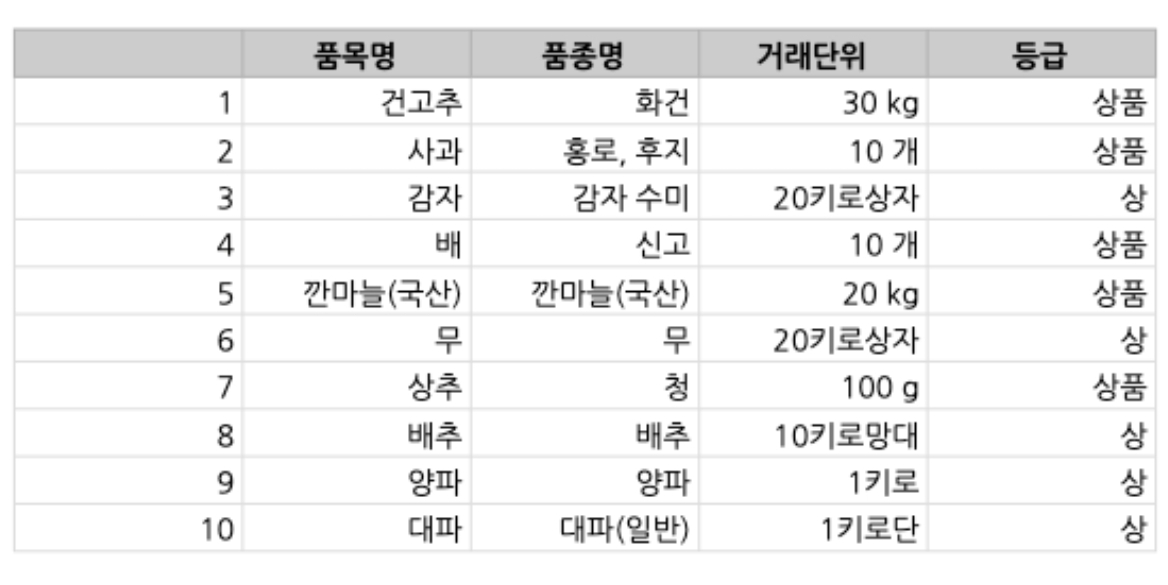

In [3]:
import os
import socket

def check_environment():
    # 1. Check for /.dockerenv file
    in_docker = os.path.exists('/.dockerenv')
    
    # 2. Check hostname
    hostname = socket.gethostname()
    
    # 3. Check cgroup
    try:
        with open('/proc/1/cgroup', 'r') as f:
            cgroup = f.read()
        docker_cgroup = 'docker' in cgroup
    except:
        docker_cgroup = False
    
    # 4. Check environment variables
    docker_env = any(var.startswith('DOCKER_') for var in os.environ)
    
    # Determine the environment
    if in_docker or docker_cgroup or docker_env:
        print("This code is running inside a Docker container.")
        print(f"Container hostname: {hostname}")
    else:
        print("This code is running on the local system.")
        print(f"System hostname: {hostname}")
    
    # Print current working directory
    print(f"Current working directory: {os.getcwd()}")

# Run the check
check_environment()

This code is running on the local system.
System hostname: 뀨잉뀨잉머신
Current working directory: c:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction


In [4]:
# 필요한 패키지 임포트
# !pip install neuralforecast
# !pip install optuna
# !pip install statsmodels
# !pip install joblib
# !pip install scikit-learn

import os
import json  # 추가: 모델 파라미터 저장을 위해 필요
import joblib
import pandas as pd
import numpy as np
import optuna
from typing import Dict, Any
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT, NHITS, NBEATS, DeepAR
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import logging
from typing import List, Tuple

c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-19 03:37:31,323	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-19 03:37:31,600	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
products_df = pd.DataFrame({'품목명': ['건고추', '사과', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파'],
                            '품종명': ['화건', '홍로', '후지', '감자 수미', '신고', '깐마늘(국산)', '무', '청', '배추', '양파', '대파(일반)'],
                            '거래단위': ['30 kg', '10 개', '10 개', '20키로상자', '10 개', '20 kg', '20키로상자', '100 g', '10키로망대', '1키로', '1키로단'],
                            '등급': ['상품', '상품', '상품', '상', '상품', '상품', '상', '상품', '상', '상', '상']})

products_df

품목명      품종명    거래단위  등급
0       건고추       화건   30 kg  상품
1        사과       홍로    10 개  상품
2        사과       후지    10 개  상품
3        감자    감자 수미  20키로상자   상
4         배       신고    10 개  상품
5   깐마늘(국산)  깐마늘(국산)   20 kg  상품
6         무        무  20키로상자   상
7        상추        청   100 g  상품
8        배추       배추  10키로망대   상
9        양파       양파     1키로   상
10       대파   대파(일반)    1키로단   상

# 조건 요약

상단 사진으로 품목 정의, 개월 별로 상중하 3개 순이 존재하므로 T ~ T-8의 9개 데이터셋으로 T+1, T+2, T+3 3개 데이터를 출력하면 된다.

근데 test 데이터셋 자체는 왤케 길지? input은 inference의 input이라고 생각하면 되나.

In [6]:
train_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\train\train.csv")

test_00_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_00.csv")
test_01_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_01.csv")
test_02_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_02.csv")
test_03_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_03.csv")
test_04_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_04.csv")
test_05_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_05.csv")
test_06_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_06.csv")
test_07_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_07.csv")
test_08_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_08.csv")
test_09_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_09.csv")
test_10_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_10.csv")
test_11_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_11.csv")
test_12_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_12.csv")
test_13_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_13.csv")
test_14_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_14.csv")
test_15_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_15.csv")
test_16_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_16.csv")
test_17_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_17.csv")
test_18_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_18.csv")
test_19_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_19.csv")
test_20_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_20.csv")
test_21_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_21.csv")
test_22_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_22.csv")
test_23_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_23.csv")
test_24_df = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\test\TEST_24.csv")

sample_submission = pd.read_csv(r"C:\Users\aingc\Desktop\coding\simple projects\torch container\agriculture_price_prediction\crops data\sample_submission.csv")

In [7]:
# 그룹화
grouped = train_df.groupby(['품목명', '품종명', '거래단위', '등급'])

# 각 그룹을 개별 DataFrame으로 저장 (예시로 딕셔너리에 저장)
grouped_product_data = {name: group for name, group in grouped}

for row in range(products_df.shape[0]):
    display(grouped_product_data[tuple(products_df.iloc[row])])

시점  품목명 품종명   거래단위  등급     평년 평균가격(원)   평균가격(원)
0    201801상순  건고추  화건  30 kg  상품  381666.666667  590000.0
1    201801중순  건고추  화건  30 kg  상품  380809.666667  590000.0
2    201801하순  건고추  화건  30 kg  상품  380000.000000  590000.0
3    201802상순  건고추  화건  30 kg  상품  380000.000000  590000.0
4    201802중순  건고추  화건  30 kg  상품  376666.666667  590000.0
..        ...  ...  ..    ...  ..            ...       ...
139  202111중순  건고추  화건  30 kg  상품  552944.333333  558000.0
140  202111하순  건고추  화건  30 kg  상품  554071.333333  565143.0
141  202112상순  건고추  화건  30 kg  상품  559000.000000  570500.0
142  202112중순  건고추  화건  30 kg  상품  552000.000000  570500.0
143  202112하순  건고추  화건  30 kg  상품  540555.333333  560778.0

[144 rows x 7 columns]

시점 품목명 품종명  거래단위  등급    평년 평균가격(원)  평균가격(원)
1177  201809중순  사과  홍로  10 개  상품  22201.333333  26228.0
1178  201809하순  사과  홍로  10 개  상품  21663.333333  26219.0
1179  201810상순  사과  홍로  10 개  상품  20847.666667  25411.0
1180  201810중순  사과  홍로  10 개  상품  19957.000000  22474.0
1213  201909중순  사과  홍로  10 개  상품  22687.333333  22939.0
1214  201909하순  사과  홍로  10 개  상품  21663.333333  20127.0
1215  201910상순  사과  홍로  10 개  상품  21509.666667  18516.0
1216  201910중순  사과  홍로  10 개  상품  20813.666667  17644.0
1248  202009상순  사과  홍로  10 개  상품  23844.333333  30369.0
1249  202009중순  사과  홍로  10 개  상품  23123.000000  29944.0
1250  202009하순  사과  홍로  10 개  상품  21663.333333  32610.0
1251  202010상순  사과  홍로  10 개  상품  21509.666667  30579.0
1252  202010중순  사과  홍로  10 개  상품  20813.666667  29534.0
1284  202109상순  사과  홍로  10 개  상품  24993.000000  24907.0
1285  202109중순  사과  홍로  10 개  상품  24813.000000  26407.0
1286  202109하순  사과  홍로  10 개  상품  23096.333333  27970.0
1287  202110상순  사과  홍로  10 개  상품  22781.333333  25009.0
1288  202110중순  사과  홍로  10 개  상품  21546.333333  23608.0
1289  202110하순  사과  홍로  10 개  상품  20838.000000  24748.5

시점 품목명 품종명  거래단위  등급    평년 평균가격(원)  평균가격(원)
1152  201801상순  사과  후지  10 개  상품  21461.666667  20361.0
1153  201801중순  사과  후지  10 개  상품  22179.666667  20359.0
1154  201801하순  사과  후지  10 개  상품  22917.666667  20653.0
1155  201802상순  사과  후지  10 개  상품  23424.666667  20563.0
1156  201802중순  사과  후지  10 개  상품  23201.666667  21779.0
...        ...  ..  ..   ...  ..           ...      ...
1291  202111중순  사과  후지  10 개  상품  20743.666667  26004.0
1292  202111하순  사과  후지  10 개  상품  20673.000000  25494.0
1293  202112상순  사과  후지  10 개  상품  20539.666667  26144.0
1294  202112중순  사과  후지  10 개  상품  20197.000000  26177.0
1295  202112하순  사과  후지  10 개  상품  20237.333333  25952.0

[125 rows x 7 columns]

시점 품목명    품종명    거래단위 등급    평년 평균가격(원)       평균가격(원)
1872  201801상순  감자  감자 수미  20키로상자  상  24660.031746  44170.285714
1873  201801중순  감자  감자 수미  20키로상자  상  23299.444444  48283.777778
1874  201801하순  감자  감자 수미  20키로상자  상  25218.007407  50243.000000
1875  201802상순  감자  감자 수미  20키로상자  상  28703.875000  55380.666667
1876  201802중순  감자  감자 수미  20키로상자  상  27419.882275  59133.000000
...        ...  ..    ...     ... ..           ...           ...
2011  202111중순  감자  감자 수미  20키로상자  상  30634.777778  33761.333333
2012  202111하순  감자  감자 수미  20키로상자  상  32139.787037  36023.875000
2013  202112상순  감자  감자 수미  20키로상자  상  31688.643519  35233.666667
2014  202112중순  감자  감자 수미  20키로상자  상  33251.916667  32679.125000
2015  202112하순  감자  감자 수미  20키로상자  상  34313.181481  42440.600000

[144 rows x 7 columns]

시점 품목명 품종명  거래단위  등급    평년 평균가격(원)  평균가격(원)
6624  201801상순   배  신고  10 개  상품  30268.000000  28312.0
6625  201801중순   배  신고  10 개  상품  30860.666667  28290.0
6626  201801하순   배  신고  10 개  상품  31317.000000  28324.0
6627  201802상순   배  신고  10 개  상품  31357.666667  28113.0
6628  201802중순   배  신고  10 개  상품  31211.666667  28294.0
...        ...  ..  ..   ...  ..           ...      ...
6763  202111중순   배  신고  10 개  상품  31598.333333  30859.0
6764  202111하순   배  신고  10 개  상품  31642.666667  32239.0
6765  202112상순   배  신고  10 개  상품  31927.666667  33333.0
6766  202112중순   배  신고  10 개  상품  32345.000000  33593.0
6767  202112하순   배  신고  10 개  상품  32753.666667  35900.0

[144 rows x 7 columns]

시점      품목명      품종명   거래단위  등급  평년 평균가격(원)        평균가격(원)
7200  201801상순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  130666.666667
7201  201801중순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  130600.000000
7202  201801하순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  130600.000000
7203  201802상순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  134614.500000
7204  201802중순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  137100.000000
...        ...      ...      ...    ...  ..         ...            ...
7339  202111중순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  167200.000000
7340  202111하순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  169100.000000
7341  202112상순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  169100.000000
7342  202112중순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  169100.000000
7343  202112하순  깐마늘(국산)  깐마늘(국산)  20 kg  상품         0.0  168033.500000

[144 rows x 7 columns]

시점 품목명 품종명    거래단위 등급  평년 평균가격(원)       평균가격(원)
7488  201801상순   무   무  20키로상자  상         0.0   9283.571429
7489  201801중순   무   무  20키로상자  상         0.0   9259.888889
7490  201801하순   무   무  20키로상자  상         0.0  10576.111111
7491  201802상순   무   무  20키로상자  상         0.0  18371.444444
7492  201802중순   무   무  20키로상자  상         0.0  19545.666667
...        ...  ..  ..     ... ..         ...           ...
7627  202111중순   무   무  20키로상자  상         0.0  12581.111111
7628  202111하순   무   무  20키로상자  상         0.0  11107.375000
7629  202112상순   무   무  20키로상자  상         0.0  11457.666667
7630  202112중순   무   무  20키로상자  상         0.0  10597.750000
7631  202112하순   무   무  20키로상자  상         0.0  10748.200000

[144 rows x 7 columns]

시점 품목명 품종명   거래단위  등급   평년 평균가격(원)  평균가격(원)
12240  201801상순  상추   청  100 g  상품  1034.666667    940.0
12241  201801중순  상추   청  100 g  상품   921.666667    981.0
12242  201801하순  상추   청  100 g  상품   850.000000    983.0
12243  201802상순  상추   청  100 g  상품   850.000000   1009.0
12244  201802중순  상추   청  100 g  상품   844.666667   1022.0
...         ...  ..  ..    ...  ..          ...      ...
12379  202111중순  상추   청  100 g  상품   843.000000   1208.0
12380  202111하순  상추   청  100 g  상품   762.666667   1062.0
12381  202112상순  상추   청  100 g  상품   717.000000    946.0
12382  202112중순  상추   청  100 g  상품   742.666667    931.0
12383  202112하순  상추   청  100 g  상품   815.333333    988.0

[144 rows x 7 columns]

시점 품목명 품종명    거래단위 등급   평년 평균가격(원)       평균가격(원)
12816  201801상순  배추  배추  10키로망대  상  6071.726190   5419.857143
12817  201801중순  배추  배추  10키로망대  상  5938.143519   5319.333333
12818  201801하순  배추  배추  10키로망대  상  6245.351852   6734.777778
12819  201802상순  배추  배추  10키로망대  상  6413.720238   8942.222222
12820  201802중순  배추  배추  10키로망대  상  7099.146825   7247.166667
...         ...  ..  ..     ... ..          ...           ...
12955  202111중순  배추  배추  10키로망대  상  6978.472222  10626.888889
12956  202111하순  배추  배추  10키로망대  상  6501.689815   9273.250000
12957  202112상순  배추  배추  10키로망대  상  5969.171296   8281.777778
12958  202112중순  배추  배추  10키로망대  상  5978.449074   7667.375000
12959  202112하순  배추  배추  10키로망대  상  5828.822222   7763.200000

[144 rows x 7 columns]

시점 품목명 품종명 거래단위 등급   평년 평균가격(원)      평균가격(원)
16560  201801상순  양파  양파  1키로  상  1149.125000  1144.428571
16561  201801중순  양파  양파  1키로  상  1125.013889  1041.222222
16562  201801하순  양파  양파  1키로  상  1180.733333  1036.444444
16563  201802상순  양파  양파  1키로  상  1192.203704  1045.777778
16564  201802중순  양파  양파  1키로  상  1133.856481  1098.166667
...         ...  ..  ..  ... ..          ...          ...
16699  202111중순  양파  양파  1키로  상   975.958333   908.666667
16700  202111하순  양파  양파  1키로  상   952.703704   855.000000
16701  202112상순  양파  양파  1키로  상   986.458333   816.333333
16702  202112중순  양파  양파  1키로  상   960.250000   734.875000
16703  202112하순  양파  양파  1키로  상   978.629630   695.100000

[144 rows x 7 columns]

시점 품목명     품종명  거래단위 등급   평년 평균가격(원)      평균가격(원)
26352  201801상순  대파  대파(일반)  1키로단  상  1620.029101  1685.285714
26353  201801중순  대파  대파(일반)  1키로단  상  1422.509259  1624.888889
26354  201801하순  대파  대파(일반)  1키로단  상  1520.266667  1834.333333
26355  201802상순  대파  대파(일반)  1키로단  상  1793.421296  2530.111111
26356  201802중순  대파  대파(일반)  1키로단  상  1977.732143  1537.833333
...         ...  ..     ...   ... ..          ...          ...
26491  202111중순  대파  대파(일반)  1키로단  상  1934.819444  1754.222222
26492  202111하순  대파  대파(일반)  1키로단  상  1774.898148  1460.250000
26493  202112상순  대파  대파(일반)  1키로단  상  1728.379630  1619.000000
26494  202112중순  대파  대파(일반)  1키로단  상  1677.643519  1217.125000
26495  202112하순  대파  대파(일반)  1키로단  상  1581.411111  1322.200000

[144 rows x 7 columns]

# TFT 모델

## TFT 데이터 형태 정확

### optimize와 forecast 구분

In [8]:
import os
import json
import logging
import joblib
import numpy as np
import pandas as pd
from typing import Any, Dict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import optuna

# 환경 변수 설정 (NeuralForecast 임포트 전에)
os.environ['NIXTLA_ID_AS_COL'] = '1'

from neuralforecast import NeuralForecast
from neuralforecast.models import TFT

# 로깅 설정
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

class DateParser:
    @staticmethod # 따로 객체(instance) 지정 없이 메서드를 해당 class로 바로 사용 가능
    def parse_date(s):
        """시점 문자열을 datetime 형식으로 변환합니다."""
        try:
            # 테스트 데이터 형식 처리 ('T-8순', 'T-7순', ..., 'T')
            if s.startswith('T'):
                base_date = pd.Timestamp('2100-01-01')  # 임의의 기준 날짜 설정
                if s == 'T':
                    date = base_date
                elif s.startswith('T-') and s.endswith('순'):
                    n = int(s[2:-1])  # 'T-8순'에서 숫자 8 추출
                    date = base_date - pd.Timedelta(days=(n * 10))  # 각 '순'을 10일로 가정
                else:
                    logging.error(f"Unexpected date format: {s}")
                    return pd.NaT
                return date
            else:
                # 기존 훈련 데이터 형식 처리 ('YYYYMM상순', 'YYYYMM중순', 'YYYYMM하순')
                year = int(s[:4])
                month = int(s[4:6])
                period = s[6:]
                if period == '상순':
                    day = 1
                elif period == '중순':
                    day = 11
                elif period == '하순':
                    day = 21
                else:
                    day = 1  # 기본값 설정
                return pd.Timestamp(year=year, month=month, day=day)
        except Exception as e:
            logging.error(f"Error parsing date '{s}': {e}")
            return pd.NaT

class DataPreprocessor:
    """데이터 전처리 및 스케일링을 담당하는 클래스"""

    def __init__(self):
        self.scalers = {}  # 각 제품별 스케일러 저장

    def preprocess(self, data, unique_id, fit_scaler=True):
        """
        데이터 전처리를 수행하고 스케일링합니다.

        Args:
            data (pd.DataFrame): 원본 데이터
            unique_id (str): 제품 식별자
            fit_scaler (bool): True이면 새로운 스케일러를 학습하고, False이면 기존 스케일러를 사용합니다.

        Returns:
            pd.DataFrame: 전처리 및 스케일링된 데이터
        """
        df = data[['시점', '평균가격(원)']].copy()

        df['ds'] = df['시점'].apply(DateParser.parse_date) # 상중하순 처리

        df = df.dropna(subset=['ds', '평균가격(원)'])
        df = df[['ds', '평균가격(원)']].rename(columns={'평균가격(원)': 'y'}) # 시점과 가격만 `ds` `y`로 남긴다
        df['unique_id'] = unique_id

        df = df.sort_values('ds').reset_index(drop=True)

        if fit_scaler or unique_id not in self.scalers:
            scaler = MinMaxScaler()
            df['y'] = scaler.fit_transform(df[['y']])
            self.scalers[unique_id] = scaler
            self.save_scaler(scaler, unique_id)
        else:
            scaler = self.load_scaler(unique_id)
            if scaler is not None:
                df['y'] = scaler.transform(df[['y']])
            else:
                logging.warning(f"No scaler found for {unique_id}. Please fit the scaler first.")
                return pd.DataFrame()

        return df


    def save_scaler(self, scaler: MinMaxScaler, unique_id: str, directory: str = 'scalers'):
        """스케일러를 파일로 저장합니다."""
        if not os.path.exists(directory):
            os.makedirs(directory)
        scaler_path = os.path.join(directory, f"{unique_id}_scaler.save")
        joblib.dump(scaler, scaler_path)

    def load_scaler(self, unique_id: str, directory: str = 'scalers') -> MinMaxScaler:
        """파일에서 스케일러를 로드합니다."""
        scaler_path = os.path.join(directory, f"{unique_id}_scaler.save")
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            self.scalers[unique_id] = scaler
            return scaler
        else:
            return None

class ModelManager:
    """모델의 저장 및 로드를 담당하는 클래스"""

    def save_model(self, nf: NeuralForecast, unique_id: str, directory: str = 'models'):
        """학습된 모델을 파일로 저장합니다."""
        if not os.path.exists(directory):
            os.makedirs(directory)
        model_path = os.path.join(directory, f"{unique_id}_model.pkl")
        joblib.dump(nf, model_path)
        logging.info(f"Model saved at {model_path}")

    def load_model(self, unique_id: str, directory: str = 'models') -> NeuralForecast:
        """파일에서 모델을 로드합니다."""
        model_path = os.path.join(directory, f"{unique_id}_model.pkl")
        if os.path.exists(model_path):
            nf = joblib.load(model_path)
            return nf
        else:
            return None

    def save_model_params(self, params: Dict[str, Any], unique_id: str, directory: str = 'model_params'):
        """모델의 하이퍼파라미터를 파일로 저장합니다."""
        if not os.path.exists(directory):
            os.makedirs(directory)
        params_path = os.path.join(directory, f"{unique_id}_params.json")
        with open(params_path, 'w') as f:
            json.dump(params, f)
        logging.info(f"Model parameters saved at {params_path}")

    def load_model_params(self, unique_id: str, directory: str = 'model_params') -> Dict[str, Any]:
        """파일에서 모델의 하이퍼파라미터를 로드합니다."""
        params_path = os.path.join(directory, f"{unique_id}_params.json")
        if os.path.exists(params_path):
            with open(params_path, 'r') as f:
                params = json.load(f)
            return params
        else:
            return None

class ModelOptimizer:
    """Optuna를 사용하여 모델의 하이퍼파라미터를 최적화하는 클래스"""

    def __init__(self, input_size, h):
        self.input_size = input_size
        self.h = h

    def objective(self, trial, df, unique_id):
        """
        Optuna 최적화를 위한 목적 함수입니다.

        Args:
            trial (optuna.Trial): Optuna 시도(trial) 객체
            df (pd.DataFrame): 데이터프레임
            unique_id (str): 제품 식별자

        Returns:
            float: RMSE 값
        """
        # 하이퍼파라미터 탐색
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        n_head = trial.suggest_int('n_head', 1, 4)
        hidden_size_multiplier = trial.suggest_int('hidden_size_multiplier', 8, 32, step=8)
        hidden_size = n_head * hidden_size_multiplier
        dropout = trial.suggest_float('dropout', 0.0, 0.5)
        max_steps = trial.suggest_int('max_steps', 50, 150)

        model = TFT(
            h=self.h,
            input_size=self.input_size,
            learning_rate=learning_rate,
            hidden_size=hidden_size,
            n_head=n_head,
            dropout=dropout,
            max_steps=max_steps
        )

        nf = NeuralForecast(models=[model], freq='10D')

        # 데이터 분할
        train_df = df.iloc[:-self.h]
        test_df = df.iloc[-(self.input_size + self.h):]

        try:
            nf.fit(train_df)
            forecasts = nf.predict(test_df)

            y_true = test_df['y'].values[-self.h:]
            # 예측 결과에서 unique_id에 해당하는 부분만 선택
            y_pred = forecasts.loc[forecasts['unique_id'] == unique_id, 'TFT'].values[-self.h:]

            # RMSE 계산
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            return rmse
        except Exception as e:
            logging.error(f"Error during optimization: {e}")
            return float('inf')

class PriceForecasterTFT:
    """가격 예측을 위한 메인 클래스"""

    def __init__(self, input_size=9, h=3):
        self.input_size = input_size
        self.h = h
        self.preprocessor = DataPreprocessor()
        self.model_manager = ModelManager()
        self.results = []

    def train(self, products_df, grouped_product_data):
        """
        각 제품에 대해 모델을 훈련하고 저장합니다.

        Args:
            products_df (pd.DataFrame): 제품 정보 데이터프레임
            grouped_product_data (dict): 제품별로 그룹화된 데이터 딕셔너리
        """
        total_products = products_df.shape[0]

        for idx in range(total_products):
            product = tuple(map(str, products_df.iloc[idx]))
            unique_id = str(product)
            logging.info(f"Processing product {idx+1}/{total_products}: {product}")

            if product not in grouped_product_data:
                logging.warning(f"No data found for product: {product}")
                continue

            data = grouped_product_data[product]
            df = self.preprocessor.preprocess(data, unique_id)

            if len(df) < self.input_size + self.h:
                logging.warning(f"Not enough data points for {product}. Required: {self.input_size + self.h}, Available: {len(df)}")
                continue

            optimizer = ModelOptimizer(self.input_size, self.h)
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: optimizer.objective(trial, df, unique_id), n_trials=50)

            best_params = study.best_params
            logging.info(f'Best hyperparameters for {product}: {best_params}')
            logging.info(f'Best RMSE: {study.best_value}')

            # 최적의 하이퍼파라미터로 모델 재훈련
            model_params = {
                'h': self.h,
                'input_size': self.input_size,
                'learning_rate': best_params['learning_rate'],
                'hidden_size': best_params['n_head'] * best_params['hidden_size_multiplier'],
                'n_head': best_params['n_head'],
                'dropout': best_params['dropout'],
                'max_steps': best_params['max_steps']
            }

            model = TFT(**model_params)

            nf = NeuralForecast(models=[model], freq='10D')

            try:
                nf.fit(df)
                logging.info(f"Model training completed for product: {product}")
            except Exception as e:
                logging.error(f"Error training model for product {product}: {e}")
                continue

            # 모델 및 파라미터 저장
            self.model_manager.save_model(nf, unique_id)
            self.model_manager.save_model_params(model_params, unique_id)

            self.results.append((product, best_params, study.best_value))

    def infer(self, products_df, grouped_product_data):
        """
        각 제품에 대해 미래를 예측하고 결과를 출력하며, 모든 예측 결과를 저장합니다.

        Args:
            products_df (pd.DataFrame): 제품 정보 데이터프레임
            grouped_product_data (dict): 제품별로 그룹화된 데이터 딕셔너리

        Returns:
            dict: 각 제품별 예측 결과 데이터프레임을 담은 딕셔너리
        """

        total_products = len(grouped_product_data)
        logging.info(f"Total products to infer: {total_products}")

        # 제품별 예측 결과를 저장할 딕셔너리 초기화
        predictions_dict = {}

        for idx, (product, data) in enumerate(grouped_product_data.items()):
            unique_id = str(product)
            logging.info(f"Inferencing model for product {idx+1}/{total_products}: {product}")

            # 모델 및 스케일러 로드
            nf = self.model_manager.load_model(unique_id)
            scaler = self.preprocessor.load_scaler(unique_id)

            if nf is None or scaler is None:
                logging.warning(f"No trained model or scaler found for product: {product}")
                continue

            # 데이터 전처리 (fit_scaler=False로 설정하여 기존 스케일러 사용)
            data = data.copy()
            preprocessed_data = self.preprocessor.preprocess(data, unique_id, fit_scaler=False)

            if preprocessed_data.empty or len(preprocessed_data) < self.input_size:
                logging.warning(f"Not enough data points for {product}. Required: {self.input_size}, Available: {len(preprocessed_data)}")
                continue

            # 모델 예측
            try:
                forecasts = nf.predict(preprocessed_data)
                logging.info(f"Prediction completed for product: {product}")
            except Exception as e:
                logging.error(f"Error during prediction for product {product}: {e}")
                continue

            # 예측값 추출 및 역변환
            model_name = nf.models[0].__class__.__name__
            y_pred_scaled = forecasts.loc[forecasts['unique_id'] == unique_id, model_name][-self.h:]

            # 저장된 스케일러로 역변환
            predictions = scaler.inverse_transform(y_pred_scaled.values.reshape(-1, 1)).flatten()

            # 미래 날짜 생성
            last_date = preprocessed_data['ds'].max()
            future_dates = pd.date_range(
                start=last_date + pd.Timedelta(days=10),
                periods=self.h,
                freq='10D'
            )

            # 예측 결과 데이터프레임 생성
            predictions_df = pd.DataFrame({
                'ds': future_dates,
                'Predicted_Price': predictions
            })

            print(f"\nProduct: {product}\nPredictions:")
            print(predictions_df)

            # 예측 결과 시각화
            self.visualize_forecast(preprocessed_data, predictions_df, unique_id)

            # 각 제품의 예측 결과를 딕셔너리에 저장
            predictions_dict[product] = predictions_df

        # 모든 제품의 예측 결과를 반환
        return predictions_dict


    def visualize_forecast(self, historical_data, predictions_df, unique_id):
        """
        예측 결과를 시각화하고 이미지로 저장합니다.

        Args:
            forecasts (pd.DataFrame): 예측 결과 데이터프레임
            historical_data (pd.DataFrame): 히스토리컬 데이터프레임
            predictions_df (pd.DataFrame): 예측 결과 데이터프레임
            unique_id (str): 제품 식별자
        """
        plt.figure(figsize=(12, 6))

        scaler = self.preprocessor.scalers.get(unique_id)
        if scaler is None:
            logging.warning(f"No scaler found for product: {unique_id}")
            return

        historical_data['y'] = scaler.inverse_transform(historical_data[['y']])

        forecast_dates = predictions_df['ds']
        forecast_values = predictions_df['Predicted_Price']

        plt.plot(historical_data['ds'], historical_data['y'], label='Historical')
        plt.plot(forecast_dates, forecast_values, label='Forecast', marker='o')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Forecast for {unique_id}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'forecast_{unique_id}.png')
        plt.close()
        logging.info(f"Forecast plot saved for product: {unique_id}")

In [9]:
forecaster_TFT = PriceForecasterTFT()
forecaster_TFT.train(products_df, grouped_product_data)

2024-10-19 03:38:44,828 - INFO - Processing product 1/11: ('건고추', '화건', '30 kg', '상품')
[I 2024-10-19 03:38:44,832] A new study created in memory with name: no-name-b5723c81-1218-432e-b080-be93aa578df7
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPa

Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=14, train_loss_step=13.50, train_loss_epoch=13.50]

`Trainer.fit` stopped: `max_steps=139` reached.


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=14, train_loss_step=13.50, train_loss_epoch=13.50]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.15it/s]

[I 2024-10-19 03:38:48,089] Trial 0 finished with value: 0.01914774874255719 and parameters: {'learning_rate': 0.00016873111284073747, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.4180706073825707, 'max_steps': 139}. Best is trial 0 with value: 0.01914774874255719.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Total estimated mo

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=16, train_loss_step=8.750, train_loss_epoch=8.750] 

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=16, train_loss_step=8.750, train_loss_epoch=8.750]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

[I 2024-10-19 03:38:49,742] Trial 1 finished with value: 0.016196283750327688 and parameters: {'learning_rate': 0.008736458787476024, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.36865141464407647, 'max_steps': 105}. Best is trial 1 with value: 0.016196283750327688.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=18, train_loss_step=13.90, train_loss_epoch=13.90]

`Trainer.fit` stopped: `max_steps=111` reached.


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=18, train_loss_step=13.90, train_loss_epoch=13.90]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s]


[I 2024-10-19 03:38:51,491] Trial 2 finished with value: 0.01645543223409866 and parameters: {'learning_rate': 4.112609271653378e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.0002664497820948908, 'max_steps': 111}. Best is trial 1 with value: 0.016196283750327688.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s, v_num=20, train_loss_step=13.00, train_loss_epoch=13.00]

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s, v_num=20, train_loss_step=13.00, train_loss_epoch=13.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


[I 2024-10-19 03:38:52,492] Trial 3 finished with value: 0.01996968079572794 and parameters: {'learning_rate': 0.00034031207066661053, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.04439853942076005, 'max_steps': 55}. Best is trial 1 with value: 0.016196283750327688.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalF

Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=22, train_loss_step=10.90, train_loss_epoch=10.90]

`Trainer.fit` stopped: `max_steps=137` reached.


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=22, train_loss_step=10.90, train_loss_epoch=10.90]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:38:54,578] Trial 4 finished with value: 0.02675162184456348 and parameters: {'learning_rate': 0.0007269108714578544, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.042011571225924915, 'max_steps': 137}. Best is trial 1 with value: 0.016196283750327688.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter       

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=24, train_loss_step=12.60, train_loss_epoch=12.60]

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=24, train_loss_step=12.60, train_loss_epoch=12.60]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:38:55,771] Trial 5 finished with value: 0.016369010384233128 and parameters: {'learning_rate': 0.0017312968067986795, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.2017725206047732, 'max_steps': 77}. Best is trial 1 with value: 0.016196283750327688.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=26, train_loss_step=16.10, train_loss_epoch=16.10]

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=26, train_loss_step=16.10, train_loss_epoch=16.10]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:38:57,390] Trial 6 finished with value: 0.010591859214083267 and parameters: {'learning_rate': 5.522204553164836e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.27756166545875277, 'max_steps': 108}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter       

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=28, train_loss_step=14.10, train_loss_epoch=14.10] 

`Trainer.fit` stopped: `max_steps=53` reached.


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=28, train_loss_step=14.10, train_loss_epoch=14.10]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]

[I 2024-10-19 03:38:58,213] Trial 7 finished with value: 0.030033766286790806 and parameters: {'learning_rate': 0.00020386981087645831, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.33029437393259414, 'max_steps': 53}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter       

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=30, train_loss_step=10.90, train_loss_epoch=10.90] 

`Trainer.fit` stopped: `max_steps=90` reached.


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=30, train_loss_step=10.90, train_loss_epoch=10.90]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:38:59,530] Trial 8 finished with value: 0.0263328450761736 and parameters: {'learning_rate': 0.006987056678158228, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4455274632215436, 'max_steps': 90}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Total estimated mo

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=32, train_loss_step=11.30, train_loss_epoch=11.30] 

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=32, train_loss_step=11.30, train_loss_epoch=11.30]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:39:01,655] Trial 9 finished with value: 0.028965238047981595 and parameters: {'learning_rate': 0.0009913880447261507, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.4730970276913888, 'max_steps': 149}. Best is trial 6 with value: 0.010591859214083267.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s, v_num=34, train_loss_step=15.20, train_loss_epoch=15.20] 

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=34, train_loss_step=15.20, train_loss_epoch=15.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:39:03,387] Trial 10 finished with value: 0.015307596776405377 and parameters: {'learning_rate': 1.4048074933044912e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.18391850071146432, 'max_steps': 120}. Best is trial 6 with value: 0.010591859214083267.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=36, train_loss_step=15.30, train_loss_epoch=15.30]

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=36, train_loss_step=15.30, train_loss_epoch=15.30]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

[I 2024-10-19 03:39:05,217] Trial 11 finished with value: 0.01416592396737814 and parameters: {'learning_rate': 1.0749741882980092e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.2026142853520881, 'max_steps': 120}. Best is trial 6 with value: 0.010591859214083267.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 79.63it/s, v_num=38, train_loss_step=15.90, train_loss_epoch=15.90] 

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s, v_num=38, train_loss_step=15.90, train_loss_epoch=15.90]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]


[I 2024-10-19 03:39:06,945] Trial 12 finished with value: 0.015301896177210816 and parameters: {'learning_rate': 1.3399011483160002e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.2728105124635918, 'max_steps': 123}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s, v_num=40, train_loss_step=15.50, train_loss_epoch=15.50] 

`Trainer.fit` stopped: `max_steps=92` reached.


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s, v_num=40, train_loss_step=15.50, train_loss_epoch=15.50]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:39:08,256] Trial 13 finished with value: 0.020704510752231314 and parameters: {'learning_rate': 5.263629780701555e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.13760628419696844, 'max_steps': 92}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=42, train_loss_step=15.20, train_loss_epoch=15.20] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=42, train_loss_step=15.20, train_loss_epoch=15.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]


[I 2024-10-19 03:39:09,940] Trial 14 finished with value: 0.0252454505795772 and parameters: {'learning_rate': 5.0108567865711006e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.26894452855253403, 'max_steps': 122}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 58.30it/s, v_num=44, train_loss_step=15.50, train_loss_epoch=15.50] 

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s, v_num=44, train_loss_step=15.50, train_loss_epoch=15.50]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:39:11,102] Trial 15 finished with value: 0.012547770647592035 and parameters: {'learning_rate': 2.7670368203294454e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.13700096936315767, 'max_steps': 78}. Best is trial 6 with value: 0.010591859214083267.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 53.70it/s, v_num=46, train_loss_step=13.60, train_loss_epoch=13.60] 

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 50.96it/s, v_num=46, train_loss_step=13.60, train_loss_epoch=13.60]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:39:12,286] Trial 16 finished with value: 0.022569519384419763 and parameters: {'learning_rate': 9.432893834331357e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.11913295243017805, 'max_steps': 77}. Best is trial 6 with value: 0.010591859214083267.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=48, train_loss_step=15.00, train_loss_epoch=15.00] 

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=48, train_loss_step=15.00, train_loss_epoch=15.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]


[I 2024-10-19 03:39:13,398] Trial 17 finished with value: 0.009576071448382618 and parameters: {'learning_rate': 2.6288135602910353e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3252907931933881, 'max_steps': 72}. Best is trial 17 with value: 0.009576071448382618.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=50, train_loss_step=16.00, train_loss_epoch=16.00] 

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=50, train_loss_step=16.00, train_loss_epoch=16.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:39:14,777] Trial 18 finished with value: 0.011715437309486864 and parameters: {'learning_rate': 9.809060506304114e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3264469876400281, 'max_steps': 94}. Best is trial 17 with value: 0.009576071448382618.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=52, train_loss_step=16.10, train_loss_epoch=16.10] 

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=52, train_loss_step=16.10, train_loss_epoch=16.10]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:39:15,758] Trial 19 finished with value: 0.009542375215133552 and parameters: {'learning_rate': 2.550454989631499e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.38473830543462917, 'max_steps': 67}. Best is trial 19 with value: 0.009542375215133552.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=54, train_loss_step=16.40, train_loss_epoch=16.40] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=54, train_loss_step=16.40, train_loss_epoch=16.40]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

[I 2024-10-19 03:39:16,730] Trial 20 finished with value: 0.009506431628232191 and parameters: {'learning_rate': 2.388893910041891e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.37864764728767397, 'max_steps': 63}. Best is trial 20 with value: 0.009506431628232191.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=56, train_loss_step=16.20, train_loss_epoch=16.20] 

`Trainer.fit` stopped: `max_steps=64` reached.


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=56, train_loss_step=16.20, train_loss_epoch=16.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:39:17,704] Trial 21 finished with value: 0.009520115702676952 and parameters: {'learning_rate': 2.47464138142878e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.38342943797524015, 'max_steps': 64}. Best is trial 20 with value: 0.009506431628232191.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=58, train_loss_step=16.40, train_loss_epoch=16.40] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=58, train_loss_step=16.40, train_loss_epoch=16.40]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 03:39:18,687] Trial 22 finished with value: 0.009426227250730725 and parameters: {'learning_rate': 1.6179804380286448e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4008143181573802, 'max_steps': 63}. Best is trial 22 with value: 0.009426227250730725.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=60, train_loss_step=16.10, train_loss_epoch=16.10] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=60, train_loss_step=16.10, train_loss_epoch=16.10]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:39:19,684] Trial 23 finished with value: 0.015714507618345308 and parameters: {'learning_rate': 2.1252961392980094e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.3960312637802378, 'max_steps': 63}. Best is trial 22 with value: 0.009426227250730725.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=62, train_loss_step=16.70, train_loss_epoch=16.70] 

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=62, train_loss_step=16.70, train_loss_epoch=16.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:39:20,631] Trial 24 finished with value: 0.010603591040798955 and parameters: {'learning_rate': 9.989169838887014e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4921576518139419, 'max_steps': 61}. Best is trial 22 with value: 0.009426227250730725.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=64, train_loss_step=15.70, train_loss_epoch=15.70] 

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=64, train_loss_step=15.70, train_loss_epoch=15.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 03:39:21,900] Trial 25 finished with value: 0.009404988313486724 and parameters: {'learning_rate': 1.0382331227126703e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.43324097112722004, 'max_steps': 85}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=66, train_loss_step=15.20, train_loss_epoch=15.20]

`Trainer.fit` stopped: `max_steps=86` reached.


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=66, train_loss_step=15.20, train_loss_epoch=15.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

[I 2024-10-19 03:39:23,213] Trial 26 finished with value: 0.01564830590523242 and parameters: {'learning_rate': 1.4003559760000192e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.438994495098894, 'max_steps': 86}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=68, train_loss_step=16.20, train_loss_epoch=16.20] 

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=68, train_loss_step=16.20, train_loss_epoch=16.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

[I 2024-10-19 03:39:24,406] Trial 27 finished with value: 0.009502629981389609 and parameters: {'learning_rate': 1.8074848189315922e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3537988182716687, 'max_steps': 82}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=70, train_loss_step=16.60, train_loss_epoch=16.60] 

`Trainer.fit` stopped: `max_steps=84` reached.


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s, v_num=70, train_loss_step=16.60, train_loss_epoch=16.60]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:39:25,640] Trial 28 finished with value: 0.015380945929376017 and parameters: {'learning_rate': 1.0363037464141839e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.3381093222396254, 'max_steps': 84}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=72, train_loss_step=13.50, train_loss_epoch=13.50] 

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=72, train_loss_step=13.50, train_loss_epoch=13.50]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]

[I 2024-10-19 03:39:27,103] Trial 29 finished with value: 0.020806619471474802 and parameters: {'learning_rate': 0.0001830125876751479, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.43011458673672176, 'max_steps': 96}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=74, train_loss_step=12.70, train_loss_epoch=12.70] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=74, train_loss_step=12.70, train_loss_epoch=12.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:39:27,941] Trial 30 finished with value: 0.017559366475946536 and parameters: {'learning_rate': 0.004438046067837919, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.45812964926770117, 'max_steps': 50}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=76, train_loss_step=14.90, train_loss_epoch=14.90] 

`Trainer.fit` stopped: `max_steps=68` reached.


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=76, train_loss_step=14.90, train_loss_epoch=14.90]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.15it/s]


[I 2024-10-19 03:39:29,050] Trial 31 finished with value: 0.009445881295637303 and parameters: {'learning_rate': 1.6803997422735237e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4078808366554109, 'max_steps': 68}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=78, train_loss_step=16.70, train_loss_epoch=16.70]

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=78, train_loss_step=16.70, train_loss_epoch=16.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]

[I 2024-10-19 03:39:30,173] Trial 32 finished with value: 0.009458403326929696 and parameters: {'learning_rate': 1.718263764034541e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.41092757498870447, 'max_steps': 71}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=80, train_loss_step=16.70, train_loss_epoch=16.70] 

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=80, train_loss_step=16.70, train_loss_epoch=16.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

[I 2024-10-19 03:39:31,306] Trial 33 finished with value: 0.009779564979152328 and parameters: {'learning_rate': 4.098436939569727e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.40904533318644426, 'max_steps': 71}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=82, train_loss_step=15.40, train_loss_epoch=15.40]

`Trainer.fit` stopped: `max_steps=57` reached.


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=82, train_loss_step=15.40, train_loss_epoch=15.40]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:39:32,218] Trial 34 finished with value: 0.009607038143729154 and parameters: {'learning_rate': 3.625715884259391e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.49483435492335714, 'max_steps': 57}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=84, train_loss_step=16.20, train_loss_epoch=16.20] 

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=84, train_loss_step=16.20, train_loss_epoch=16.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:39:33,317] Trial 35 finished with value: 0.016618264913324025 and parameters: {'learning_rate': 6.936298844831731e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2976025975910044, 'max_steps': 71}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=86, train_loss_step=15.30, train_loss_epoch=15.30] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=86, train_loss_step=15.30, train_loss_epoch=15.30]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:39:34,793] Trial 36 finished with value: 0.019600521178189063 and parameters: {'learning_rate': 0.00043735843462328885, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4234644971827997, 'max_steps': 100}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=88, train_loss_step=15.70, train_loss_epoch=15.70] 

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=88, train_loss_step=15.70, train_loss_epoch=15.70]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

[I 2024-10-19 03:39:35,686] Trial 37 finished with value: 0.014681135133294864 and parameters: {'learning_rate': 1.6961058991528238e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.46897857971258805, 'max_steps': 58}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=90, train_loss_step=16.80, train_loss_epoch=16.80] 

`Trainer.fit` stopped: `max_steps=70` reached.


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, v_num=90, train_loss_step=16.80, train_loss_epoch=16.80]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]


[I 2024-10-19 03:39:36,771] Trial 38 finished with value: 0.009675734335428796 and parameters: {'learning_rate': 3.441978402410731e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.35929722563344857, 'max_steps': 70}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=92, train_loss_step=14.40, train_loss_epoch=14.40] 

`Trainer.fit` stopped: `max_steps=79` reached.


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=92, train_loss_step=14.40, train_loss_epoch=14.40]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]


[I 2024-10-19 03:39:37,992] Trial 39 finished with value: 0.01369443565235801 and parameters: {'learning_rate': 1.0177406540884821e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.409035669353199, 'max_steps': 79}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=94, train_loss_step=13.10, train_loss_epoch=13.10] 

`Trainer.fit` stopped: `max_steps=87` reached.


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s, v_num=94, train_loss_step=13.10, train_loss_epoch=13.10]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:39:39,335] Trial 40 finished with value: 0.01758992051157702 and parameters: {'learning_rate': 0.0024866943917266826, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.30035604099846, 'max_steps': 87}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler              

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=96, train_loss_step=16.00, train_loss_epoch=16.00]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=96, train_loss_step=16.00, train_loss_epoch=16.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:39:40,649] Trial 41 finished with value: 0.009473089736250924 and parameters: {'learning_rate': 1.5761189594906676e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.36674732437783075, 'max_steps': 83}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=98, train_loss_step=16.20, train_loss_epoch=16.20]

`Trainer.fit` stopped: `max_steps=74` reached.


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=98, train_loss_step=16.20, train_loss_epoch=16.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:39:41,825] Trial 42 finished with value: 0.009464862847875795 and parameters: {'learning_rate': 1.7022632387784412e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.41518746238410376, 'max_steps': 74}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=100, train_loss_step=16.20, train_loss_epoch=16.20] 

`Trainer.fit` stopped: `max_steps=74` reached.


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=100, train_loss_step=16.20, train_loss_epoch=16.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.80it/s]

[I 2024-10-19 03:39:42,968] Trial 43 finished with value: 0.00948314282805369 and parameters: {'learning_rate': 1.8515370491683683e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4495952270751356, 'max_steps': 74}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=102, train_loss_step=16.00, train_loss_epoch=16.00] 

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=102, train_loss_step=16.00, train_loss_epoch=16.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:39:43,957] Trial 44 finished with value: 0.010237340236540205 and parameters: {'learning_rate': 7.132403380038423e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4134056133075016, 'max_steps': 67}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=104, train_loss_step=15.60, train_loss_epoch=15.60] 

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=104, train_loss_step=15.60, train_loss_epoch=15.60]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]


[I 2024-10-19 03:39:45,067] Trial 45 finished with value: 0.011637963681167833 and parameters: {'learning_rate': 1.3160301343480875e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4768135190481966, 'max_steps': 76}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=106, train_loss_step=15.20, train_loss_epoch=15.20] 

`Trainer.fit` stopped: `max_steps=53` reached.


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=106, train_loss_step=15.20, train_loss_epoch=15.20]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:39:46,089] Trial 46 finished with value: 0.014628523374573156 and parameters: {'learning_rate': 3.274176250585921e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.4409737278074379, 'max_steps': 53}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | Temporal


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=108, train_loss_step=15.60, train_loss_epoch=15.60]

`Trainer.fit` stopped: `max_steps=104` reached.


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=108, train_loss_step=15.60, train_loss_epoch=15.60]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:39:47,533] Trial 47 finished with value: 0.009434964914110562 and parameters: {'learning_rate': 1.0343167520410865e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4077685774752155, 'max_steps': 104}. Best is trial 25 with value: 0.009404988313486724.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 56.98it/s, v_num=110, train_loss_step=14.00, train_loss_epoch=14.00] 

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s, v_num=110, train_loss_step=14.00, train_loss_epoch=14.00]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:39:48,952] Trial 48 finished with value: 0.015628079593977467 and parameters: {'learning_rate': 1.225301852546669e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.3488534943175039, 'max_steps': 99}. Best is trial 25 with value: 0.009404988313486724.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Tota

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=112, train_loss_step=14.90, train_loss_epoch=14.90]

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=112, train_loss_step=14.90, train_loss_epoch=14.90]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:39:50,493] Trial 49 finished with value: 0.024955191882976405 and parameters: {'learning_rate': 0.000293302891582813, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.22366102302599866, 'max_steps': 106}. Best is trial 25 with value: 0.009404988313486724.
2024-10-19 03:39:50,494 - INFO - Best hyperparameters for ('건고추', '화건', '30 kg', '상품'): {'learning_rate': 1.0382331227126703e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.43324097112722004, 'max_steps': 85}
2024-10-19 03:39:50,494 - INFO - Best RMSE: 0.009404988313486724
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=114, train_loss_step=15.70, train_loss_epoch=15.70] 

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=114, train_loss_step=15.70, train_loss_epoch=15.70]


2024-10-19 03:39:51,651 - INFO - Model training completed for product: ('건고추', '화건', '30 kg', '상품')
2024-10-19 03:39:51,687 - INFO - Model saved at models\('건고추', '화건', '30 kg', '상품')_model.pkl
2024-10-19 03:39:51,688 - INFO - Model parameters saved at model_params\('건고추', '화건', '30 kg', '상품')_params.json
2024-10-19 03:39:51,689 - INFO - Processing product 2/11: ('사과', '홍로', '10 개', '상품')
[I 2024-10-19 03:39:51,692] A new study created in memory with name: no-name-0cc494f1-1c6d-4e77-8ff1-125bf9dc51bf
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
---------------

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 53.75it/s, v_num=115, train_loss_step=0.137, train_loss_epoch=0.137] 

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 51.01it/s, v_num=115, train_loss_step=0.137, train_loss_epoch=0.137]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:39:53,070] Trial 0 finished with value: 0.13070692780719068 and parameters: {'learning_rate': 0.00048482355219992874, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.48156242218722844, 'max_steps': 96}. Best is trial 0 with value: 0.13070692780719068.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=117, train_loss_step=0.113, train_loss_epoch=0.113] 

`Trainer.fit` stopped: `max_steps=74` reached.


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=117, train_loss_step=0.113, train_loss_epoch=0.113]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

[I 2024-10-19 03:39:54,134] Trial 1 finished with value: 0.10864933656003452 and parameters: {'learning_rate': 0.00500521588008521, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.42827516267357196, 'max_steps': 74}. Best is trial 1 with value: 0.10864933656003452.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Total estimated mo

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.96it/s, v_num=119, train_loss_step=0.139, train_loss_epoch=0.139] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s, v_num=119, train_loss_step=0.139, train_loss_epoch=0.139]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


[I 2024-10-19 03:39:55,538] Trial 2 finished with value: 0.12821938294839638 and parameters: {'learning_rate': 0.0007711399354927934, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.26175590127343396, 'max_steps': 100}. Best is trial 1 with value: 0.10864933656003452.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=121, train_loss_step=1.440, train_loss_epoch=1.440] 

`Trainer.fit` stopped: `max_steps=65` reached.


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s, v_num=121, train_loss_step=1.440, train_loss_epoch=1.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]


[I 2024-10-19 03:39:56,489] Trial 3 finished with value: 0.18933973900968332 and parameters: {'learning_rate': 3.866762039307568e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.23540319382889552, 'max_steps': 65}. Best is trial 1 with value: 0.10864933656003452.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler              

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=123, train_loss_step=1.160, train_loss_epoch=1.160] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=123, train_loss_step=1.160, train_loss_epoch=1.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:39:57,413] Trial 4 finished with value: 0.12927383902296158 and parameters: {'learning_rate': 6.580351792325655e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.36884571745192435, 'max_steps': 63}. Best is trial 1 with value: 0.10864933656003452.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler              

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=125, train_loss_step=0.105, train_loss_epoch=0.105] 

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=125, train_loss_step=0.105, train_loss_epoch=0.105]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 03:39:58,263] Trial 5 finished with value: 0.09645873592596599 and parameters: {'learning_rate': 0.004240414901104424, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.09337936936006697, 'max_steps': 55}. Best is trial 5 with value: 0.09645873592596599.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter       

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=127, train_loss_step=0.125, train_loss_epoch=0.125]  

`Trainer.fit` stopped: `max_steps=86` reached.


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=127, train_loss_step=0.125, train_loss_epoch=0.125]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]


[I 2024-10-19 03:39:59,540] Trial 6 finished with value: 0.08204609712884815 and parameters: {'learning_rate': 0.009157232963617434, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.2629161923555866, 'max_steps': 86}. Best is trial 6 with value: 0.08204609712884815.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusio

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s, v_num=129, train_loss_step=0.0497, train_loss_epoch=0.0497] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=129, train_loss_step=0.0497, train_loss_epoch=0.0497]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.84it/s]

[I 2024-10-19 03:40:01,250] Trial 7 finished with value: 0.10562210469222602 and parameters: {'learning_rate': 0.004505730400237539, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3259533852748753, 'max_steps': 121}. Best is trial 6 with value: 0.08204609712884815.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=131, train_loss_step=0.427, train_loss_epoch=0.427] 

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=131, train_loss_step=0.427, train_loss_epoch=0.427]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

[I 2024-10-19 03:40:03,043] Trial 8 finished with value: 0.09277189439860925 and parameters: {'learning_rate': 0.00020015948119281698, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.2537386006642898, 'max_steps': 123}. Best is trial 6 with value: 0.08204609712884815.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated mo

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=133, train_loss_step=0.646, train_loss_epoch=0.646] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=133, train_loss_step=0.646, train_loss_epoch=0.646]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:40:04,810] Trial 9 finished with value: 0.06867319126152388 and parameters: {'learning_rate': 0.00038606443852056235, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.37830346151854904, 'max_steps': 121}. Best is trial 9 with value: 0.06867319126152388.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=135, train_loss_step=1.160, train_loss_epoch=1.160] 

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=135, train_loss_step=1.160, train_loss_epoch=1.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:40:06,865] Trial 10 finished with value: 0.10023889539845632 and parameters: {'learning_rate': 1.2298692477466148e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.045386529839709144, 'max_steps': 149}. Best is trial 9 with value: 0.06867319126152388.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=137, train_loss_step=0.148, train_loss_epoch=0.148] 

`Trainer.fit` stopped: `max_steps=87` reached.


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=137, train_loss_step=0.148, train_loss_epoch=0.148]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:40:08,137] Trial 11 finished with value: 0.11242272626255968 and parameters: {'learning_rate': 0.0013637371853762927, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.17411402084226757, 'max_steps': 87}. Best is trial 9 with value: 0.06867319126152388.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=139, train_loss_step=0.603, train_loss_epoch=0.603] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=139, train_loss_step=0.603, train_loss_epoch=0.603]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:40:09,783] Trial 12 finished with value: 0.043734785791637386 and parameters: {'learning_rate': 0.00016326737312107034, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.3670421153428234, 'max_steps': 115}. Best is trial 12 with value: 0.043734785791637386.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=141, train_loss_step=0.611, train_loss_epoch=0.611] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=141, train_loss_step=0.611, train_loss_epoch=0.611]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]


[I 2024-10-19 03:40:11,534] Trial 13 finished with value: 0.05197185842522013 and parameters: {'learning_rate': 0.00018135775782048352, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.38228089469630316, 'max_steps': 124}. Best is trial 12 with value: 0.043734785791637386.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=143, train_loss_step=0.614, train_loss_epoch=0.614] 

`Trainer.fit` stopped: `max_steps=141` reached.


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=143, train_loss_step=0.614, train_loss_epoch=0.614]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:40:13,490] Trial 14 finished with value: 0.04276207044779788 and parameters: {'learning_rate': 0.00012166625266198943, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.4876032670647238, 'max_steps': 141}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=145, train_loss_step=0.740, train_loss_epoch=0.740]

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=145, train_loss_step=0.740, train_loss_epoch=0.740]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[I 2024-10-19 03:40:15,615] Trial 15 finished with value: 0.05162653525265939 and parameters: {'learning_rate': 6.744118444043792e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.48622007954295726, 'max_steps': 149}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=147, train_loss_step=0.885, train_loss_epoch=0.885] 

`Trainer.fit` stopped: `max_steps=136` reached.


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=147, train_loss_step=0.885, train_loss_epoch=0.885]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:40:17,626] Trial 16 finished with value: 0.07753932892619844 and parameters: {'learning_rate': 2.0013071914514562e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.43821900026743743, 'max_steps': 136}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=149, train_loss_step=0.448, train_loss_epoch=0.448]

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=149, train_loss_step=0.448, train_loss_epoch=0.448]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:40:19,316] Trial 17 finished with value: 0.07618304750841083 and parameters: {'learning_rate': 0.00012884756115912705, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.32488421657195854, 'max_steps': 110}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=151, train_loss_step=0.490, train_loss_epoch=0.490]

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=151, train_loss_step=0.490, train_loss_epoch=0.490]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:40:21,384] Trial 18 finished with value: 0.06659306456698633 and parameters: {'learning_rate': 9.499673667094016e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.4273299554181389, 'max_steps': 134}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=153, train_loss_step=0.0996, train_loss_epoch=0.0996]

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, v_num=153, train_loss_step=0.0996, train_loss_epoch=0.0996]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]


[I 2024-10-19 03:40:23,147] Trial 19 finished with value: 0.09430587631577123 and parameters: {'learning_rate': 0.0017209212062415217, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.497600529238639, 'max_steps': 110}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=155, train_loss_step=0.678, train_loss_epoch=0.678]

`Trainer.fit` stopped: `max_steps=136` reached.


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=155, train_loss_step=0.678, train_loss_epoch=0.678]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]


[I 2024-10-19 03:40:25,305] Trial 20 finished with value: 0.05864873396971292 and parameters: {'learning_rate': 4.0090472584221536e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.32152757801783716, 'max_steps': 136}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=157, train_loss_step=0.790, train_loss_epoch=0.790]

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s, v_num=157, train_loss_step=0.790, train_loss_epoch=0.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]


[I 2024-10-19 03:40:27,615] Trial 21 finished with value: 0.05708163853700332 and parameters: {'learning_rate': 5.604882184952712e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.47297891783578194, 'max_steps': 149}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=159, train_loss_step=1.060, train_loss_epoch=1.060]

`Trainer.fit` stopped: `max_steps=145` reached.


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=159, train_loss_step=1.060, train_loss_epoch=1.060]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:40:29,850] Trial 22 finished with value: 0.08425004195449043 and parameters: {'learning_rate': 2.2151127336246333e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.44059907762973083, 'max_steps': 145}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=161, train_loss_step=0.495, train_loss_epoch=0.495]

`Trainer.fit` stopped: `max_steps=140` reached.


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=161, train_loss_step=0.495, train_loss_epoch=0.495]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:40:31,983] Trial 23 finished with value: 0.07229399836318054 and parameters: {'learning_rate': 0.0002416761513942142, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.39955113464865166, 'max_steps': 140}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=163, train_loss_step=0.604, train_loss_epoch=0.604]

`Trainer.fit` stopped: `max_steps=129` reached.


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=163, train_loss_step=0.604, train_loss_epoch=0.604]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:40:34,029] Trial 24 finished with value: 0.04756208442011593 and parameters: {'learning_rate': 0.00010239578020232931, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4930880668090819, 'max_steps': 129}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=165, train_loss_step=0.588, train_loss_epoch=0.588]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=165, train_loss_step=0.588, train_loss_epoch=0.588]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:40:35,843] Trial 25 finished with value: 0.0489544226753439 and parameters: {'learning_rate': 0.00012589319539059788, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.44170106972206363, 'max_steps': 112}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=167, train_loss_step=0.253, train_loss_epoch=0.253]

`Trainer.fit` stopped: `max_steps=131` reached.


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=167, train_loss_step=0.253, train_loss_epoch=0.253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

[I 2024-10-19 03:40:37,947] Trial 26 finished with value: 0.0987008141285115 and parameters: {'learning_rate': 0.00046959921991415575, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.351147842925952, 'max_steps': 131}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=169, train_loss_step=0.592, train_loss_epoch=0.592]

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=169, train_loss_step=0.592, train_loss_epoch=0.592]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.16it/s]

[I 2024-10-19 03:40:39,974] Trial 27 finished with value: 0.04984658807483351 and parameters: {'learning_rate': 0.00011396004754016928, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.40507537909513985, 'max_steps': 128}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 73.77it/s, v_num=171, train_loss_step=0.532, train_loss_epoch=0.532]

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 64.29it/s, v_num=171, train_loss_step=0.532, train_loss_epoch=0.532]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


[I 2024-10-19 03:40:41,806] Trial 28 finished with value: 0.0690389806272463 and parameters: {'learning_rate': 0.0007591523700234099, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3053347810016941, 'max_steps': 116}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=173, train_loss_step=0.228, train_loss_epoch=0.228]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=173, train_loss_step=0.228, train_loss_epoch=0.228]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:40:43,529] Trial 29 finished with value: 0.08149344781404294 and parameters: {'learning_rate': 0.0002591670242609223, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.4658386821173307, 'max_steps': 105}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=175, train_loss_step=0.785, train_loss_epoch=0.785]

`Trainer.fit` stopped: `max_steps=91` reached.


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=175, train_loss_step=0.785, train_loss_epoch=0.785]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:40:44,976] Trial 30 finished with value: 0.07491688155427478 and parameters: {'learning_rate': 3.1688627347684386e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.20732969668142254, 'max_steps': 91}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=177, train_loss_step=0.591, train_loss_epoch=0.591]

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=177, train_loss_step=0.591, train_loss_epoch=0.591]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


[I 2024-10-19 03:40:46,788] Trial 31 finished with value: 0.0535875268230392 and parameters: {'learning_rate': 0.0001437390767212513, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.45758697432591405, 'max_steps': 113}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=179, train_loss_step=0.639, train_loss_epoch=0.639]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=179, train_loss_step=0.639, train_loss_epoch=0.639]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

[I 2024-10-19 03:40:48,421] Trial 32 finished with value: 0.04332581561058844 and parameters: {'learning_rate': 9.130365472671592e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4971819957081286, 'max_steps': 102}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=181, train_loss_step=0.636, train_loss_epoch=0.636]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=181, train_loss_step=0.636, train_loss_epoch=0.636]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.21it/s]

[I 2024-10-19 03:40:50,024] Trial 33 finished with value: 0.043290088488457 and parameters: {'learning_rate': 8.802745255694589e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.49689124029104853, 'max_steps': 100}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 53.80it/s, v_num=183, train_loss_step=0.402, train_loss_epoch=0.402]

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 48.58it/s, v_num=183, train_loss_step=0.402, train_loss_epoch=0.402]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]

[I 2024-10-19 03:40:51,624] Trial 34 finished with value: 0.0713011120281604 and parameters: {'learning_rate': 0.00033501559759152913, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.4088064200842824, 'max_steps': 99}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=185, train_loss_step=0.722, train_loss_epoch=0.722]

`Trainer.fit` stopped: `max_steps=79` reached.


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=185, train_loss_step=0.722, train_loss_epoch=0.722]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


[I 2024-10-19 03:40:52,939] Trial 35 finished with value: 0.04800162947451223 and parameters: {'learning_rate': 7.053333099429161e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.46760428132219906, 'max_steps': 79}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=187, train_loss_step=0.482, train_loss_epoch=0.482]

`Trainer.fit` stopped: `max_steps=103` reached.


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s, v_num=187, train_loss_step=0.482, train_loss_epoch=0.482]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:40:54,549] Trial 36 finished with value: 0.0694081826256664 and parameters: {'learning_rate': 0.0006597154968208418, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.41835698100755664, 'max_steps': 103}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=189, train_loss_step=0.950, train_loss_epoch=0.950]

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=189, train_loss_step=0.950, train_loss_epoch=0.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:40:56,009] Trial 37 finished with value: 0.07086933150256679 and parameters: {'learning_rate': 5.28227843620247e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.4539393141245374, 'max_steps': 94}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=191, train_loss_step=0.637, train_loss_epoch=0.637]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=191, train_loss_step=0.637, train_loss_epoch=0.637]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

[I 2024-10-19 03:40:57,321] Trial 38 finished with value: 0.0438955256573455 and parameters: {'learning_rate': 8.630003137968284e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.2848004699518398, 'max_steps': 83}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=193, train_loss_step=0.556, train_loss_epoch=0.556]

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=193, train_loss_step=0.556, train_loss_epoch=0.556]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

[I 2024-10-19 03:40:58,542] Trial 39 finished with value: 0.0763094153344926 and parameters: {'learning_rate': 0.00017954191698490212, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.35406210367909646, 'max_steps': 76}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=195, train_loss_step=1.440, train_loss_epoch=1.440]

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=195, train_loss_step=1.440, train_loss_epoch=1.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:40:59,684] Trial 40 finished with value: 0.18943264570683568 and parameters: {'learning_rate': 3.468017098913074e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.1640235837399799, 'max_steps': 71}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=197, train_loss_step=0.666, train_loss_epoch=0.666]

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=197, train_loss_step=0.666, train_loss_epoch=0.666]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.73it/s]

[I 2024-10-19 03:41:00,980] Trial 41 finished with value: 0.04393059965016409 and parameters: {'learning_rate': 8.685149985866261e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.27539696798110475, 'max_steps': 82}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=199, train_loss_step=0.708, train_loss_epoch=0.708]

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=199, train_loss_step=0.708, train_loss_epoch=0.708]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:41:02,508] Trial 42 finished with value: 0.05158129965968174 and parameters: {'learning_rate': 4.895181952870286e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.22528530247466733, 'max_steps': 96}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=201, train_loss_step=0.877, train_loss_epoch=0.877]

`Trainer.fit` stopped: `max_steps=64` reached.


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=201, train_loss_step=0.877, train_loss_epoch=0.877]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

[I 2024-10-19 03:41:03,558] Trial 43 finished with value: 0.07863686004974403 and parameters: {'learning_rate': 8.566253898743325e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.281674192216046, 'max_steps': 64}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=203, train_loss_step=0.597, train_loss_epoch=0.597]

`Trainer.fit` stopped: `max_steps=52` reached.


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, v_num=203, train_loss_step=0.597, train_loss_epoch=0.597]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:41:04,418] Trial 44 finished with value: 0.04434771015812262 and parameters: {'learning_rate': 0.0002571111085504608, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4959762733634404, 'max_steps': 52}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=205, train_loss_step=0.463, train_loss_epoch=0.463]

`Trainer.fit` stopped: `max_steps=87` reached.


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=205, train_loss_step=0.463, train_loss_epoch=0.463]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:41:05,788] Trial 45 finished with value: 0.07843002092694634 and parameters: {'learning_rate': 0.00016710743890275482, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.3560195392361167, 'max_steps': 87}. Best is trial 14 with value: 0.04276207044779788.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=207, train_loss_step=0.952, train_loss_epoch=0.952]

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=207, train_loss_step=0.952, train_loss_epoch=0.952]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

[I 2024-10-19 03:41:07,574] Trial 46 finished with value: 0.0892375014190899 and parameters: {'learning_rate': 7.521562904670552e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.2954856375902755, 'max_steps': 117}. Best is trial 14 with value: 0.04276207044779788.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=209, train_loss_step=0.670, train_loss_epoch=0.670]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, v_num=209, train_loss_step=0.670, train_loss_epoch=0.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:41:09,170] Trial 47 finished with value: 0.04212254413593143 and parameters: {'learning_rate': 2.6560325014911143e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.00428407564509764, 'max_steps': 102}. Best is trial 47 with value: 0.04212254413593143.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s, v_num=211, train_loss_step=0.826, train_loss_epoch=0.826] 

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 79.70it/s, v_num=211, train_loss_step=0.826, train_loss_epoch=0.826]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


[I 2024-10-19 03:41:10,911] Trial 48 finished with value: 0.05513163260594326 and parameters: {'learning_rate': 1.0377174815376326e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.011508885812108752, 'max_steps': 105}. Best is trial 47 with value: 0.04212254413593143.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | Tempor

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=213, train_loss_step=0.828, train_loss_epoch=0.828] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=213, train_loss_step=0.828, train_loss_epoch=0.828]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:41:12,359] Trial 49 finished with value: 0.08285207108241242 and parameters: {'learning_rate': 2.4434234780808632e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.11245402340044276, 'max_steps': 100}. Best is trial 47 with value: 0.04212254413593143.
2024-10-19 03:41:12,359 - INFO - Best hyperparameters for ('사과', '홍로', '10 개', '상품'): {'learning_rate': 2.6560325014911143e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.00428407564509764, 'max_steps': 102}
2024-10-19 03:41:12,360 - INFO - Best RMSE: 0.04212254413593143
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=215, train_loss_step=0.874, train_loss_epoch=0.874]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=215, train_loss_step=0.874, train_loss_epoch=0.874]


2024-10-19 03:41:13,749 - INFO - Model training completed for product: ('사과', '홍로', '10 개', '상품')
2024-10-19 03:41:13,787 - INFO - Model saved at models\('사과', '홍로', '10 개', '상품')_model.pkl
2024-10-19 03:41:13,788 - INFO - Model parameters saved at model_params\('사과', '홍로', '10 개', '상품')_params.json
2024-10-19 03:41:13,788 - INFO - Processing product 3/11: ('사과', '후지', '10 개', '상품')
[I 2024-10-19 03:41:13,792] A new study created in memory with name: no-name-6d65101a-f7b5-4efe-8693-74e71814d150
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
---------------------

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=216, train_loss_step=4.110, train_loss_epoch=4.110] 

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=216, train_loss_step=4.110, train_loss_epoch=4.110]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.15it/s]

[I 2024-10-19 03:41:14,853] Trial 0 finished with value: 0.006237788889799298 and parameters: {'learning_rate': 0.0006989959807875085, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.4062404513370771, 'max_steps': 72}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated mo

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s, v_num=218, train_loss_step=3.580, train_loss_epoch=3.580] 

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=218, train_loss_step=3.580, train_loss_epoch=3.580]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:41:16,431] Trial 1 finished with value: 0.011493557164470904 and parameters: {'learning_rate': 0.0009458775966848602, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.4982463699174824, 'max_steps': 110}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter       

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=220, train_loss_step=3.620, train_loss_epoch=3.620] 

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=220, train_loss_step=3.620, train_loss_epoch=3.620]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:41:17,665] Trial 2 finished with value: 0.015017075637823826 and parameters: {'learning_rate': 0.005488277291235465, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.008516296120167244, 'max_steps': 85}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter       

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=222, train_loss_step=5.130, train_loss_epoch=5.130] 

`Trainer.fit` stopped: `max_steps=64` reached.


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=222, train_loss_step=5.130, train_loss_epoch=5.130]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


[I 2024-10-19 03:41:18,646] Trial 3 finished with value: 0.00790545594200282 and parameters: {'learning_rate': 6.25807159371763e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.33410080032326905, 'max_steps': 64}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusi

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=224, train_loss_step=3.660, train_loss_epoch=3.660] 

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, v_num=224, train_loss_step=3.660, train_loss_epoch=3.660]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

[I 2024-10-19 03:41:20,320] Trial 4 finished with value: 0.008854663823209428 and parameters: {'learning_rate': 0.0030996856763947428, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.44659532601836904, 'max_steps': 116}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=226, train_loss_step=5.190, train_loss_epoch=5.190] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=226, train_loss_step=5.190, train_loss_epoch=5.190]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.79it/s]


[I 2024-10-19 03:41:21,289] Trial 5 finished with value: 0.012517561126623567 and parameters: {'learning_rate': 2.3735923131267288e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.2590261025826766, 'max_steps': 62}. Best is trial 0 with value: 0.006237788889799298.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=228, train_loss_step=4.610, train_loss_epoch=4.610] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=228, train_loss_step=4.610, train_loss_epoch=4.610]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:41:23,157] Trial 6 finished with value: 0.00588871145149753 and parameters: {'learning_rate': 0.00037727465718347136, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.38242525864135013, 'max_steps': 128}. Best is trial 6 with value: 0.00588871145149753.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s, v_num=230, train_loss_step=3.950, train_loss_epoch=3.950] 

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 53.93it/s, v_num=230, train_loss_step=3.950, train_loss_epoch=3.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 03:41:24,408] Trial 7 finished with value: 0.015978353183858 and parameters: {'learning_rate': 0.0032695885753275056, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.47119571626372325, 'max_steps': 85}. Best is trial 6 with value: 0.00588871145149753.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter       

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=232, train_loss_step=3.270, train_loss_epoch=3.270] 

`Trainer.fit` stopped: `max_steps=68` reached.


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=232, train_loss_step=3.270, train_loss_epoch=3.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:41:25,491] Trial 8 finished with value: 0.036691147818833446 and parameters: {'learning_rate': 0.006867000768627461, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.25435254191201634, 'max_steps': 68}. Best is trial 6 with value: 0.00588871145149753.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, v_num=234, train_loss_step=4.770, train_loss_epoch=4.770] 

`Trainer.fit` stopped: `max_steps=56` reached.


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=234, train_loss_step=4.770, train_loss_epoch=4.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.63it/s]

[I 2024-10-19 03:41:26,341] Trial 9 finished with value: 0.005730759945986634 and parameters: {'learning_rate': 0.0008614776341261862, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.09249632744963565, 'max_steps': 56}. Best is trial 9 with value: 0.005730759945986634.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.972     Tota

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=236, train_loss_step=4.230, train_loss_epoch=4.230] 

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=236, train_loss_step=4.230, train_loss_epoch=4.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

[I 2024-10-19 03:41:28,281] Trial 10 finished with value: 0.006215847340946422 and parameters: {'learning_rate': 9.88206513643074e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.04760904594595265, 'max_steps': 135}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, v_num=238, train_loss_step=4.180, train_loss_epoch=4.180] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=238, train_loss_step=4.180, train_loss_epoch=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.69it/s]

[I 2024-10-19 03:41:30,196] Trial 11 finished with value: 0.008779557437144467 and parameters: {'learning_rate': 0.00034206988916684505, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.14347901580498368, 'max_steps': 138}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=240, train_loss_step=4.260, train_loss_epoch=4.260] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=240, train_loss_step=4.260, train_loss_epoch=4.260]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]


[I 2024-10-19 03:41:31,941] Trial 12 finished with value: 0.008810010314047725 and parameters: {'learning_rate': 0.00017927167781148253, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.12700481386661838, 'max_steps': 124}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=242, train_loss_step=4.340, train_loss_epoch=4.340] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=242, train_loss_step=4.340, train_loss_epoch=4.340]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:41:33,362] Trial 13 finished with value: 0.00786163464707297 and parameters: {'learning_rate': 0.0007502674323128302, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.36337144167228513, 'max_steps': 100}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=244, train_loss_step=2.570, train_loss_epoch=2.570] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=244, train_loss_step=2.570, train_loss_epoch=2.570]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.84it/s]


[I 2024-10-19 03:41:35,518] Trial 14 finished with value: 0.055248360652160024 and parameters: {'learning_rate': 0.0014764632800307739, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.152847253546576, 'max_steps': 150}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=246, train_loss_step=4.150, train_loss_epoch=4.150]

`Trainer.fit` stopped: `max_steps=54` reached.


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=246, train_loss_step=4.150, train_loss_epoch=4.150]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[I 2024-10-19 03:41:36,396] Trial 15 finished with value: 0.007924573945059238 and parameters: {'learning_rate': 0.00033458432994964234, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.3151698348777192, 'max_steps': 54}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=248, train_loss_step=5.480, train_loss_epoch=5.480]

`Trainer.fit` stopped: `max_steps=104` reached.


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=248, train_loss_step=5.480, train_loss_epoch=5.480]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.82it/s]

[I 2024-10-19 03:41:38,024] Trial 16 finished with value: 0.006380894128449005 and parameters: {'learning_rate': 1.8826269301783404e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.19215661765907768, 'max_steps': 104}. Best is trial 9 with value: 0.005730759945986634.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=250, train_loss_step=5.400, train_loss_epoch=5.400]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=250, train_loss_step=5.400, train_loss_epoch=5.400]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

[I 2024-10-19 03:41:39,409] Trial 17 finished with value: 0.00948128995961948 and parameters: {'learning_rate': 0.00016900032328892088, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.07707757730149792, 'max_steps': 83}. Best is trial 9 with value: 0.005730759945986634.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=252, train_loss_step=5.410, train_loss_epoch=5.410] 

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=252, train_loss_step=5.410, train_loss_epoch=5.410]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:41:40,777] Trial 18 finished with value: 0.005660260369388381 and parameters: {'learning_rate': 4.6591677105185114e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2048479977618446, 'max_steps': 94}. Best is trial 18 with value: 0.005660260369388381.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=254, train_loss_step=5.090, train_loss_epoch=5.090] 

`Trainer.fit` stopped: `max_steps=51` reached.


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=254, train_loss_step=5.090, train_loss_epoch=5.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.81it/s]


[I 2024-10-19 03:41:41,584] Trial 19 finished with value: 0.006024817249603533 and parameters: {'learning_rate': 4.1543961772689056e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.20175882429022216, 'max_steps': 51}. Best is trial 18 with value: 0.005660260369388381.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler        

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=256, train_loss_step=5.150, train_loss_epoch=5.150] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=256, train_loss_step=5.150, train_loss_epoch=5.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.77it/s]


[I 2024-10-19 03:41:42,975] Trial 20 finished with value: 0.012031720640954402 and parameters: {'learning_rate': 3.778836609719155e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.08283295737153347, 'max_steps': 95}. Best is trial 18 with value: 0.005660260369388381.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=258, train_loss_step=5.240, train_loss_epoch=5.240] 

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=258, train_loss_step=5.240, train_loss_epoch=5.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]

[I 2024-10-19 03:41:44,760] Trial 21 finished with value: 0.0055484101325795525 and parameters: {'learning_rate': 1.1425180990062127e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2922354836048178, 'max_steps': 125}. Best is trial 21 with value: 0.0055484101325795525.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=260, train_loss_step=5.960, train_loss_epoch=5.960] 

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=260, train_loss_step=5.960, train_loss_epoch=5.960]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:41:46,518] Trial 22 finished with value: 0.005551229734068336 and parameters: {'learning_rate': 1.0378670377001294e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.21222636471678824, 'max_steps': 117}. Best is trial 21 with value: 0.0055484101325795525.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temp

Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=262, train_loss_step=5.870, train_loss_epoch=5.870] 

`Trainer.fit` stopped: `max_steps=114` reached.


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=262, train_loss_step=5.870, train_loss_epoch=5.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]


[I 2024-10-19 03:41:48,178] Trial 23 finished with value: 0.005544150090104767 and parameters: {'learning_rate': 1.968412494070076e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.21142861955155517, 'max_steps': 114}. Best is trial 23 with value: 0.005544150090104767.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=264, train_loss_step=5.110, train_loss_epoch=5.110]

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 66.65it/s, v_num=264, train_loss_step=5.110, train_loss_epoch=5.110]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]


[I 2024-10-19 03:41:49,964] Trial 24 finished with value: 0.005547008908608257 and parameters: {'learning_rate': 1.3077809933994295e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2866789730173758, 'max_steps': 118}. Best is trial 23 with value: 0.005544150090104767.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | Tempor

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=266, train_loss_step=4.650, train_loss_epoch=4.650]

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=266, train_loss_step=4.650, train_loss_epoch=4.650]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.01it/s]

[I 2024-10-19 03:41:52,043] Trial 25 finished with value: 0.005515039058191904 and parameters: {'learning_rate': 1.0708622760860086e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.28660178857779595, 'max_steps': 124}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=268, train_loss_step=4.850, train_loss_epoch=4.850]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s, v_num=268, train_loss_step=4.850, train_loss_epoch=4.850]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]


[I 2024-10-19 03:41:53,692] Trial 26 finished with value: 0.005832805934699132 and parameters: {'learning_rate': 1.7077945959165094e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.28895511165946103, 'max_steps': 112}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | Tempo

Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=270, train_loss_step=4.630, train_loss_epoch=4.630] 

`Trainer.fit` stopped: `max_steps=139` reached.


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=270, train_loss_step=4.630, train_loss_epoch=4.630]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:41:55,705] Trial 27 finished with value: 0.015450081428861909 and parameters: {'learning_rate': 2.3507948458440608e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.24295721985706323, 'max_steps': 139}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=272, train_loss_step=4.860, train_loss_epoch=4.860] 

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=272, train_loss_step=4.860, train_loss_epoch=4.860]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


[I 2024-10-19 03:41:57,394] Trial 28 finished with value: 0.005526720954550395 and parameters: {'learning_rate': 1.0407215756029373e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3407533247338655, 'max_steps': 120}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | Tempor

Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=274, train_loss_step=4.030, train_loss_epoch=4.030] 

`Trainer.fit` stopped: `max_steps=148` reached.


Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=274, train_loss_step=4.030, train_loss_epoch=4.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:41:59,451] Trial 29 finished with value: 0.007736681875966169 and parameters: {'learning_rate': 8.352546346529033e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.4180500066458643, 'max_steps': 148}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=276, train_loss_step=4.790, train_loss_epoch=4.790] 

`Trainer.fit` stopped: `max_steps=132` reached.


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=276, train_loss_step=4.790, train_loss_epoch=4.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:42:01,319] Trial 30 finished with value: 0.010125624680918453 and parameters: {'learning_rate': 2.8398170004016884e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.35003694859309287, 'max_steps': 132}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | Tempo

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=278, train_loss_step=4.430, train_loss_epoch=4.430] 

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=278, train_loss_step=4.430, train_loss_epoch=4.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:42:03,010] Trial 31 finished with value: 0.005552746594431301 and parameters: {'learning_rate': 1.3000038922302043e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.2951586046891048, 'max_steps': 119}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 90.88it/s, v_num=280, train_loss_step=4.630, train_loss_epoch=4.630] 

`Trainer.fit` stopped: `max_steps=107` reached.


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=280, train_loss_step=4.630, train_loss_epoch=4.630]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:42:04,539] Trial 32 finished with value: 0.005588893200514415 and parameters: {'learning_rate': 1.5234784218006846e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.38229187122064384, 'max_steps': 107}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | Tempo

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=282, train_loss_step=4.830, train_loss_epoch=4.830] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=282, train_loss_step=4.830, train_loss_epoch=4.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]


[I 2024-10-19 03:42:06,223] Trial 33 finished with value: 0.006334564475590875 and parameters: {'learning_rate': 1.02745893908433e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.2420851360212281, 'max_steps': 121}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=284, train_loss_step=4.880, train_loss_epoch=4.880] 

`Trainer.fit` stopped: `max_steps=111` reached.


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=284, train_loss_step=4.880, train_loss_epoch=4.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:42:07,778] Trial 34 finished with value: 0.008318570169625113 and parameters: {'learning_rate': 2.773634408761805e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.32719168978099844, 'max_steps': 111}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.965     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=286, train_loss_step=3.940, train_loss_epoch=3.940] 

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=286, train_loss_step=3.940, train_loss_epoch=3.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.77it/s]

[I 2024-10-19 03:42:09,605] Trial 35 finished with value: 0.01972686017749223 and parameters: {'learning_rate': 5.840505649776072e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.2737541344442112, 'max_steps': 130}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=288, train_loss_step=5.240, train_loss_epoch=5.240]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=288, train_loss_step=5.240, train_loss_epoch=5.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:42:11,335] Trial 36 finished with value: 0.005543588330091733 and parameters: {'learning_rate': 1.8209070302563946e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2302776842094479, 'max_steps': 112}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=290, train_loss_step=4.740, train_loss_epoch=4.740]

`Trainer.fit` stopped: `max_steps=101` reached.


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=290, train_loss_step=4.740, train_loss_epoch=4.740]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

[I 2024-10-19 03:42:12,884] Trial 37 finished with value: 0.0057485777666758135 and parameters: {'learning_rate': 3.2251904990693834e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.22256022592755187, 'max_steps': 101}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=292, train_loss_step=4.620, train_loss_epoch=4.620] 

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=292, train_loss_step=4.620, train_loss_epoch=4.620]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:42:14,461] Trial 38 finished with value: 0.00554363158964051 and parameters: {'learning_rate': 2.0604677185253156e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.174419925274455, 'max_steps': 108}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s, v_num=294, train_loss_step=4.780, train_loss_epoch=4.780] 

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 51.10it/s, v_num=294, train_loss_step=4.780, train_loss_epoch=4.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:42:15,657] Trial 39 finished with value: 0.018157661376247018 and parameters: {'learning_rate': 0.0001098381576817963, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.17755940392743666, 'max_steps': 78}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=296, train_loss_step=5.430, train_loss_epoch=5.430] 

`Trainer.fit` stopped: `max_steps=92` reached.


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=296, train_loss_step=5.430, train_loss_epoch=5.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.87it/s]

[I 2024-10-19 03:42:17,043] Trial 40 finished with value: 0.006826629352629256 and parameters: {'learning_rate': 1.9295445877203232e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.41179757206433515, 'max_steps': 92}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=298, train_loss_step=5.440, train_loss_epoch=5.440] 

`Trainer.fit` stopped: `max_steps=111` reached.


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=298, train_loss_step=5.440, train_loss_epoch=5.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]

[I 2024-10-19 03:42:18,658] Trial 41 finished with value: 0.00554398981574171 and parameters: {'learning_rate': 2.0659597912425266e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.16303853480973157, 'max_steps': 111}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=300, train_loss_step=5.310, train_loss_epoch=5.310]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=300, train_loss_step=5.310, train_loss_epoch=5.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 03:42:20,215] Trial 42 finished with value: 0.006097927259625222 and parameters: {'learning_rate': 5.8772454031560015e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.17862383058439266, 'max_steps': 105}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Total estimated mo

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 83.29it/s, v_num=302, train_loss_step=5.200, train_loss_epoch=5.200] 

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=302, train_loss_step=5.200, train_loss_epoch=5.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:42:21,785] Trial 43 finished with value: 0.005544872956539092 and parameters: {'learning_rate': 1.5658661742405997e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.15394004706017064, 'max_steps': 109}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempo

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s, v_num=304, train_loss_step=5.090, train_loss_epoch=5.090] 

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=304, train_loss_step=5.090, train_loss_epoch=5.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:42:23,545] Trial 44 finished with value: 0.005562879998168316 and parameters: {'learning_rate': 2.455600254148545e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.11778801925914308, 'max_steps': 125}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=306, train_loss_step=4.870, train_loss_epoch=4.870] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=306, train_loss_step=4.870, train_loss_epoch=4.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:42:24,991] Trial 45 finished with value: 0.009767474722574663 and parameters: {'learning_rate': 3.622729771061524e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.2412613417160283, 'max_steps': 100}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Tota

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=308, train_loss_step=4.290, train_loss_epoch=4.290] 

`Trainer.fit` stopped: `max_steps=142` reached.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=308, train_loss_step=4.290, train_loss_epoch=4.290]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]


[I 2024-10-19 03:42:26,960] Trial 46 finished with value: 0.006575371853524146 and parameters: {'learning_rate': 0.0005301837906189033, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.31841482512201325, 'max_steps': 142}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=310, train_loss_step=5.510, train_loss_epoch=5.510] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=310, train_loss_step=5.510, train_loss_epoch=5.510]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.13it/s]

[I 2024-10-19 03:42:28,623] Trial 47 finished with value: 0.008566463675775893 and parameters: {'learning_rate': 1.0194047446872582e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.03319174309017864, 'max_steps': 115}. Best is trial 25 with value: 0.005515039058191904.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=312, train_loss_step=4.820, train_loss_epoch=4.820] 

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=312, train_loss_step=4.820, train_loss_epoch=4.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:42:30,350] Trial 48 finished with value: 0.014169003788328534 and parameters: {'learning_rate': 7.425760409311089e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.17436179821058762, 'max_steps': 123}. Best is trial 25 with value: 0.005515039058191904.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=314, train_loss_step=4.350, train_loss_epoch=4.350] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=314, train_loss_step=4.350, train_loss_epoch=4.350]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]


[I 2024-10-19 03:42:32,116] Trial 49 finished with value: 0.011604513311728367 and parameters: {'learning_rate': 0.0013551600571192252, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.11998219213032699, 'max_steps': 128}. Best is trial 25 with value: 0.005515039058191904.
2024-10-19 03:42:32,116 - INFO - Best hyperparameters for ('사과', '후지', '10 개', '상품'): {'learning_rate': 1.0708622760860086e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.28660178857779595, 'max_steps': 124}
2024-10-19 03:42:32,117 - INFO - Best RMSE: 0.005515039058191904
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | Constant

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=316, train_loss_step=4.630, train_loss_epoch=4.630] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=316, train_loss_step=4.630, train_loss_epoch=4.630]

2024-10-19 03:42:33,836 - INFO - Model training completed for product: ('사과', '후지', '10 개', '상품')


2024-10-19 03:42:34,047 - INFO - Model saved at models\('사과', '후지', '10 개', '상품')_model.pkl
2024-10-19 03:42:34,049 - INFO - Model parameters saved at model_params\('사과', '후지', '10 개', '상품')_params.json
2024-10-19 03:42:34,049 - INFO - Processing product 4/11: ('감자', '감자 수미', '20키로상자', '상')
[I 2024-10-19 03:42:34,053] A new study created in memory with name: no-name-aa8e8066-c86e-4d2a-91f4-54c35f3c1c45
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=317, train_loss_step=2.390, train_loss_epoch=2.390] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=317, train_loss_step=2.390, train_loss_epoch=2.390]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.72it/s]

[I 2024-10-19 03:42:36,076] Trial 0 finished with value: 0.0899477100489362 and parameters: {'learning_rate': 0.0077702783573397926, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4112980617396088, 'max_steps': 150}. Best is trial 0 with value: 0.0899477100489362.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated mo

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=319, train_loss_step=3.610, train_loss_epoch=3.610] 

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=319, train_loss_step=3.610, train_loss_epoch=3.610]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:42:37,915] Trial 1 finished with value: 0.058197473438484304 and parameters: {'learning_rate': 0.00024573630129571123, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.3210567854796041, 'max_steps': 134}. Best is trial 1 with value: 0.058197473438484304.
Seed set to 1
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)
88        Modules 

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=321, train_loss_step=3.350, train_loss_epoch=3.350] 

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=321, train_loss_step=3.350, train_loss_epoch=3.350]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:42:39,503] Trial 2 finished with value: 0.09055484226767645 and parameters: {'learning_rate': 0.0008868756989909806, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2550647296435188, 'max_steps': 113}. Best is trial 1 with value: 0.058197473438484304.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.972     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=323, train_loss_step=2.370, train_loss_epoch=2.370]

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=323, train_loss_step=2.370, train_loss_epoch=2.370]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[I 2024-10-19 03:42:41,050] Trial 3 finished with value: 0.09432281849092386 and parameters: {'learning_rate': 0.0009199337239226045, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.4069652801605614, 'max_steps': 108}. Best is trial 1 with value: 0.058197473438484304.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=325, train_loss_step=2.890, train_loss_epoch=2.890] 

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=325, train_loss_step=2.890, train_loss_epoch=2.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:42:42,200] Trial 4 finished with value: 0.09402869006977516 and parameters: {'learning_rate': 0.009278944028537644, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.35599640162177476, 'max_steps': 80}. Best is trial 1 with value: 0.058197473438484304.
Seed set to 1
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Total estimated model params size (MB)
88        Modules 

Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=327, train_loss_step=4.030, train_loss_epoch=4.030] 

`Trainer.fit` stopped: `max_steps=145` reached.


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=327, train_loss_step=4.030, train_loss_epoch=4.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

[I 2024-10-19 03:42:44,185] Trial 5 finished with value: 0.0429846661773472 and parameters: {'learning_rate': 3.92340638219002e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.48878669532756347, 'max_steps': 145}. Best is trial 5 with value: 0.0429846661773472.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter       

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=329, train_loss_step=3.490, train_loss_epoch=3.490] 

`Trainer.fit` stopped: `max_steps=87` reached.


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=329, train_loss_step=3.490, train_loss_epoch=3.490]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]


[I 2024-10-19 03:42:45,457] Trial 6 finished with value: 0.056843359997655094 and parameters: {'learning_rate': 0.00012793302120140518, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.010262037777387212, 'max_steps': 87}. Best is trial 5 with value: 0.0429846661773472.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=331, train_loss_step=3.990, train_loss_epoch=3.990] 

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=331, train_loss_step=3.990, train_loss_epoch=3.990]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:42:46,736] Trial 7 finished with value: 0.048891920922227466 and parameters: {'learning_rate': 4.9439932940848e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.25868322260300314, 'max_steps': 88}. Best is trial 5 with value: 0.0429846661773472.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=333, train_loss_step=3.270, train_loss_epoch=3.270] 

`Trainer.fit` stopped: `max_steps=145` reached.


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=333, train_loss_step=3.270, train_loss_epoch=3.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]

[I 2024-10-19 03:42:48,713] Trial 8 finished with value: 0.08602740621186573 and parameters: {'learning_rate': 0.0014905793304139526, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.10359714597387143, 'max_steps': 145}. Best is trial 5 with value: 0.0429846661773472.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter       

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=335, train_loss_step=4.200, train_loss_epoch=4.200] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=335, train_loss_step=4.200, train_loss_epoch=4.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.27it/s]

[I 2024-10-19 03:42:49,513] Trial 9 finished with value: 0.05184965447409317 and parameters: {'learning_rate': 2.067247439397581e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.3563390795459622, 'max_steps': 50}. Best is trial 5 with value: 0.0429846661773472.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=337, train_loss_step=4.300, train_loss_epoch=4.300] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=337, train_loss_step=4.300, train_loss_epoch=4.300]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]


[I 2024-10-19 03:42:51,267] Trial 10 finished with value: 0.04810765093168627 and parameters: {'learning_rate': 1.336199817657779e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.49223742376978585, 'max_steps': 124}. Best is trial 5 with value: 0.0429846661773472.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=339, train_loss_step=4.180, train_loss_epoch=4.180] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=339, train_loss_step=4.180, train_loss_epoch=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

[I 2024-10-19 03:42:53,055] Trial 11 finished with value: 0.048776134670763034 and parameters: {'learning_rate': 1.1724250213774928e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.492244936804618, 'max_steps': 128}. Best is trial 5 with value: 0.0429846661773472.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=341, train_loss_step=3.890, train_loss_epoch=3.890] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=341, train_loss_step=3.890, train_loss_epoch=3.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.60it/s]


[I 2024-10-19 03:42:54,835] Trial 12 finished with value: 0.04209097221036774 and parameters: {'learning_rate': 2.8850352886711087e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.48921047397512946, 'max_steps': 128}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | Tempora

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 90.88it/s, v_num=343, train_loss_step=3.480, train_loss_epoch=3.480] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=343, train_loss_step=3.480, train_loss_epoch=3.480]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:42:56,766] Trial 13 finished with value: 0.05290474128355404 and parameters: {'learning_rate': 6.029546813441421e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.1580332067855345, 'max_steps': 138}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.972     Total estimated mo

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=345, train_loss_step=3.650, train_loss_epoch=3.650] 

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=345, train_loss_step=3.650, train_loss_epoch=3.650]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.23it/s]

[I 2024-10-19 03:42:58,480] Trial 14 finished with value: 0.055543679959169076 and parameters: {'learning_rate': 4.019816633501038e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.4359333496577517, 'max_steps': 120}. Best is trial 12 with value: 0.04209097221036774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=347, train_loss_step=3.480, train_loss_epoch=3.480]

`Trainer.fit` stopped: `max_steps=101` reached.


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=347, train_loss_step=3.480, train_loss_epoch=3.480]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]


[I 2024-10-19 03:42:59,925] Trial 15 finished with value: 0.056551070790588326 and parameters: {'learning_rate': 0.00011525548163583284, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.4622673461645455, 'max_steps': 101}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | Tempora

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=349, train_loss_step=3.600, train_loss_epoch=3.600] 

`Trainer.fit` stopped: `max_steps=140` reached.


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=349, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:43:01,913] Trial 16 finished with value: 0.04904908527984307 and parameters: {'learning_rate': 2.863362072425023e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.18318040749055792, 'max_steps': 140}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=351, train_loss_step=3.550, train_loss_epoch=3.550] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=351, train_loss_step=3.550, train_loss_epoch=3.550]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:43:03,975] Trial 17 finished with value: 0.053525630620407286 and parameters: {'learning_rate': 0.00010265591936175753, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3448193812728607, 'max_steps': 150}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=353, train_loss_step=3.240, train_loss_epoch=3.240] 

`Trainer.fit` stopped: `max_steps=65` reached.


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=353, train_loss_step=3.240, train_loss_epoch=3.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]

[I 2024-10-19 03:43:04,935] Trial 18 finished with value: 0.0941575133792689 and parameters: {'learning_rate': 0.00039208490529135816, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.3034799775651183, 'max_steps': 65}. Best is trial 12 with value: 0.04209097221036774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.972     Tota

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=355, train_loss_step=3.100, train_loss_epoch=3.100] 

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=355, train_loss_step=3.100, train_loss_epoch=3.100]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:43:06,620] Trial 19 finished with value: 0.09680043292454477 and parameters: {'learning_rate': 0.00024801791764789973, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.39205128485034857, 'max_steps': 118}. Best is trial 12 with value: 0.04209097221036774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=357, train_loss_step=3.870, train_loss_epoch=3.870] 

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=357, train_loss_step=3.870, train_loss_epoch=3.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:43:08,455] Trial 20 finished with value: 0.053045535055746884 and parameters: {'learning_rate': 2.3050282798944277e-05, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.4610697987860351, 'max_steps': 130}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Total estimated mo

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=359, train_loss_step=4.310, train_loss_epoch=4.310] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=359, train_loss_step=4.310, train_loss_epoch=4.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.14it/s]


[I 2024-10-19 03:43:10,207] Trial 21 finished with value: 0.04881676974344578 and parameters: {'learning_rate': 1.203792018810643e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.4889914696110787, 'max_steps': 124}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalF

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=361, train_loss_step=4.230, train_loss_epoch=4.230]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=361, train_loss_step=4.230, train_loss_epoch=4.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]


[I 2024-10-19 03:43:11,706] Trial 22 finished with value: 0.051268153795087465 and parameters: {'learning_rate': 1.4445751580084785e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.4984563374033749, 'max_steps': 105}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=363, train_loss_step=3.530, train_loss_epoch=3.530] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=363, train_loss_step=3.530, train_loss_epoch=3.530]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


[I 2024-10-19 03:43:13,644] Trial 23 finished with value: 0.046126269128680945 and parameters: {'learning_rate': 5.504843741234406e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.4417648061370957, 'max_steps': 138}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 82.72it/s, v_num=365, train_loss_step=3.510, train_loss_epoch=3.510] 

`Trainer.fit` stopped: `max_steps=139` reached.


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 73.54it/s, v_num=365, train_loss_step=3.510, train_loss_epoch=3.510]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


[I 2024-10-19 03:43:15,601] Trial 24 finished with value: 0.1025658547830775 and parameters: {'learning_rate': 7.642270423712115e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.428296105585392, 'max_steps': 139}. Best is trial 12 with value: 0.04209097221036774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=367, train_loss_step=3.710, train_loss_epoch=3.710] 

`Trainer.fit` stopped: `max_steps=132` reached.


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=367, train_loss_step=3.710, train_loss_epoch=3.710]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:43:17,447] Trial 25 finished with value: 0.04180632357574351 and parameters: {'learning_rate': 3.3254479523696945e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.385299656361494, 'max_steps': 132}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=369, train_loss_step=3.590, train_loss_epoch=3.590] 

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=369, train_loss_step=3.590, train_loss_epoch=3.590]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:43:19,032] Trial 26 finished with value: 0.041814851975065695 and parameters: {'learning_rate': 3.588486810816512e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3813524464348183, 'max_steps': 112}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=371, train_loss_step=3.690, train_loss_epoch=3.690] 

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=371, train_loss_step=3.690, train_loss_epoch=3.690]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

[I 2024-10-19 03:43:20,639] Trial 27 finished with value: 0.042536579472228435 and parameters: {'learning_rate': 2.7770915766414533e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.38300645487618673, 'max_steps': 112}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=373, train_loss_step=3.220, train_loss_epoch=3.220] 

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=373, train_loss_step=3.220, train_loss_epoch=3.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:43:22,054] Trial 28 finished with value: 0.07103440478671508 and parameters: {'learning_rate': 0.0002038283573003386, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.28169975416676574, 'max_steps': 98}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=375, train_loss_step=3.630, train_loss_epoch=3.630] 

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=375, train_loss_step=3.630, train_loss_epoch=3.630]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.82it/s]


[I 2024-10-19 03:43:23,413] Trial 29 finished with value: 0.0418323774762766 and parameters: {'learning_rate': 0.0004441256917807537, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.38995013077912877, 'max_steps': 96}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=377, train_loss_step=3.050, train_loss_epoch=3.050] 

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=377, train_loss_step=3.050, train_loss_epoch=3.050]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

[I 2024-10-19 03:43:24,760] Trial 30 finished with value: 0.08223045151211596 and parameters: {'learning_rate': 0.003982399631916453, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.19952964029786324, 'max_steps': 93}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=379, train_loss_step=4.020, train_loss_epoch=4.020] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=379, train_loss_step=4.020, train_loss_epoch=4.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

[I 2024-10-19 03:43:26,389] Trial 31 finished with value: 0.043372863166151424 and parameters: {'learning_rate': 0.00047588608901131114, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3800390825207408, 'max_steps': 115}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=381, train_loss_step=3.500, train_loss_epoch=3.500] 

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=381, train_loss_step=3.500, train_loss_epoch=3.500]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]

[I 2024-10-19 03:43:28,198] Trial 32 finished with value: 0.04454160866502597 and parameters: {'learning_rate': 0.000171275885943876, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.30534562079585204, 'max_steps': 130}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=383, train_loss_step=3.270, train_loss_epoch=3.270] 

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=383, train_loss_step=3.270, train_loss_epoch=3.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:43:29,382] Trial 33 finished with value: 0.04207028875116149 and parameters: {'learning_rate': 0.000566909813029407, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.32900055244572396, 'max_steps': 82}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=385, train_loss_step=3.740, train_loss_epoch=3.740] 

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=385, train_loss_step=3.740, train_loss_epoch=3.740]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:43:30,527] Trial 34 finished with value: 0.042183747263604895 and parameters: {'learning_rate': 0.0006201614635040355, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3632643644603972, 'max_steps': 77}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=387, train_loss_step=3.610, train_loss_epoch=3.610] 

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=387, train_loss_step=3.610, train_loss_epoch=3.610]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:43:31,669] Trial 35 finished with value: 0.05229940648775442 and parameters: {'learning_rate': 0.0013078168957251686, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3208803363262014, 'max_steps': 77}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=389, train_loss_step=3.380, train_loss_epoch=3.380] 

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=389, train_loss_step=3.380, train_loss_epoch=3.380]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

[I 2024-10-19 03:43:32,729] Trial 36 finished with value: 0.08887058459192879 and parameters: {'learning_rate': 0.003928040157791314, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.40947819524039425, 'max_steps': 71}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter       

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=391, train_loss_step=3.740, train_loss_epoch=3.740] 

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=391, train_loss_step=3.740, train_loss_epoch=3.740]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]


[I 2024-10-19 03:43:34,081] Trial 37 finished with value: 0.06700633485202331 and parameters: {'learning_rate': 0.0007136533455480478, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.3343757093423911, 'max_steps': 94}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=393, train_loss_step=3.910, train_loss_epoch=3.910] 

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=393, train_loss_step=3.910, train_loss_epoch=3.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:43:35,614] Trial 38 finished with value: 0.04241287266990446 and parameters: {'learning_rate': 0.00029084017341204747, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.2797499136484544, 'max_steps': 108}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=395, train_loss_step=3.180, train_loss_epoch=3.180] 

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s, v_num=395, train_loss_step=3.180, train_loss_epoch=3.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:43:36,891] Trial 39 finished with value: 0.08359646313622679 and parameters: {'learning_rate': 0.0020580533056835945, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.22706811173635558, 'max_steps': 88}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=397, train_loss_step=3.860, train_loss_epoch=3.860] 

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=397, train_loss_step=3.860, train_loss_epoch=3.860]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:43:37,820] Trial 40 finished with value: 0.04491483656447549 and parameters: {'learning_rate': 0.00035663112998619753, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.40852369173717745, 'max_steps': 61}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=399, train_loss_step=3.890, train_loss_epoch=3.890] 

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=399, train_loss_step=3.890, train_loss_epoch=3.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:43:39,046] Trial 41 finished with value: 0.044008679750659134 and parameters: {'learning_rate': 8.247241590955855e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.4580021944038789, 'max_steps': 83}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Tota

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=401, train_loss_step=4.230, train_loss_epoch=4.230]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=401, train_loss_step=4.230, train_loss_epoch=4.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:43:40,563] Trial 42 finished with value: 0.05092849136548449 and parameters: {'learning_rate': 3.654490827383802e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.37009506527642, 'max_steps': 105}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Tota

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=403, train_loss_step=3.880, train_loss_epoch=3.880] 

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=403, train_loss_step=3.880, train_loss_epoch=3.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:43:42,290] Trial 43 finished with value: 0.04191198309846935 and parameters: {'learning_rate': 1.8826257324062624e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.4200611873357566, 'max_steps': 123}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 86.24it/s, v_num=405, train_loss_step=4.110, train_loss_epoch=4.110] 

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 79.40it/s, v_num=405, train_loss_step=4.110, train_loss_epoch=4.110]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:43:43,885] Trial 44 finished with value: 0.048116396490840076 and parameters: {'learning_rate': 1.8057065087333347e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4014754690194068, 'max_steps': 113}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Tota

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=407, train_loss_step=3.600, train_loss_epoch=3.600] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=407, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:43:45,613] Trial 45 finished with value: 0.05479260704328807 and parameters: {'learning_rate': 0.00014892728052740996, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3356639257237002, 'max_steps': 122}. Best is trial 25 with value: 0.04180632357574351.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=409, train_loss_step=3.340, train_loss_epoch=3.340] 

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=409, train_loss_step=3.340, train_loss_epoch=3.340]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]


[I 2024-10-19 03:43:47,019] Trial 46 finished with value: 0.0863992846994906 and parameters: {'learning_rate': 0.0009695386966609214, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.031327845681775046, 'max_steps': 98}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=411, train_loss_step=3.320, train_loss_epoch=3.320] 

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=411, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]


[I 2024-10-19 03:43:48,895] Trial 47 finished with value: 0.09049690579244886 and parameters: {'learning_rate': 0.0005253902789009446, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.42490726347294117, 'max_steps': 134}. Best is trial 25 with value: 0.04180632357574351.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 56.95it/s, v_num=413, train_loss_step=3.710, train_loss_epoch=3.710] 

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s, v_num=413, train_loss_step=3.710, train_loss_epoch=3.710]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

[I 2024-10-19 03:43:50,276] Trial 48 finished with value: 0.041643322804947966 and parameters: {'learning_rate': 1.6446319481823376e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.36075156394646646, 'max_steps': 93}. Best is trial 48 with value: 0.041643322804947966.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Tota

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=415, train_loss_step=3.920, train_loss_epoch=3.920]

`Trainer.fit` stopped: `max_steps=104` reached.


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=415, train_loss_step=3.920, train_loss_epoch=3.920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.82it/s]

[I 2024-10-19 03:43:51,811] Trial 49 finished with value: 0.04671568910894111 and parameters: {'learning_rate': 1.0032911244570843e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.35767419569737574, 'max_steps': 104}. Best is trial 48 with value: 0.041643322804947966.
2024-10-19 03:43:51,811 - INFO - Best hyperparameters for ('감자', '감자 수미', '20키로상자', '상'): {'learning_rate': 1.6446319481823376e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.36075156394646646, 'max_steps': 93}
2024-10-19 03:43:51,812 - INFO - Best RMSE: 0.041643322804947966
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter       

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=417, train_loss_step=3.870, train_loss_epoch=3.870] 

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=417, train_loss_step=3.870, train_loss_epoch=3.870]


2024-10-19 03:43:53,138 - INFO - Model training completed for product: ('감자', '감자 수미', '20키로상자', '상')
2024-10-19 03:43:53,348 - INFO - Model saved at models\('감자', '감자 수미', '20키로상자', '상')_model.pkl
2024-10-19 03:43:53,349 - INFO - Model parameters saved at model_params\('감자', '감자 수미', '20키로상자', '상')_params.json
2024-10-19 03:43:53,349 - INFO - Processing product 5/11: ('배', '신고', '10 개', '상품')
[I 2024-10-19 03:43:53,353] A new study created in memory with name: no-name-4361614f-795b-4587-8fef-630769af8d1c
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
----------

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=418, train_loss_step=4.750, train_loss_epoch=4.750] 

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=418, train_loss_step=4.750, train_loss_epoch=4.750]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:43:54,338] Trial 0 finished with value: 0.05094027281086552 and parameters: {'learning_rate': 1.5668035679541346e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3828766749700281, 'max_steps': 66}. Best is trial 0 with value: 0.05094027281086552.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated mo

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=420, train_loss_step=3.880, train_loss_epoch=3.880] 

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 76.89it/s, v_num=420, train_loss_step=3.880, train_loss_epoch=3.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

[I 2024-10-19 03:43:55,884] Trial 1 finished with value: 0.09181295402178842 and parameters: {'learning_rate': 0.0009080700000745291, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.25550875600733064, 'max_steps': 109}. Best is trial 0 with value: 0.05094027281086552.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s, v_num=422, train_loss_step=4.820, train_loss_epoch=4.820] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s, v_num=422, train_loss_step=4.820, train_loss_epoch=4.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.12it/s]

[I 2024-10-19 03:43:56,829] Trial 2 finished with value: 0.042864599794179774 and parameters: {'learning_rate': 0.0001599404921922555, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.33989772389520223, 'max_steps': 62}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter       

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=424, train_loss_step=5.440, train_loss_epoch=5.440] 

`Trainer.fit` stopped: `max_steps=75` reached.


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=424, train_loss_step=5.440, train_loss_epoch=5.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:43:57,925] Trial 3 finished with value: 0.0689333445253177 and parameters: {'learning_rate': 1.943761778286931e-05, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.08005717979165927, 'max_steps': 75}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=426, train_loss_step=4.220, train_loss_epoch=4.220] 

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=426, train_loss_step=4.220, train_loss_epoch=4.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:43:59,189] Trial 4 finished with value: 0.053840820441813715 and parameters: {'learning_rate': 0.00031808101261325333, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4314063852855182, 'max_steps': 88}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter       

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=428, train_loss_step=5.180, train_loss_epoch=5.180] 

`Trainer.fit` stopped: `max_steps=79` reached.


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=428, train_loss_step=5.180, train_loss_epoch=5.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]


[I 2024-10-19 03:44:00,363] Trial 5 finished with value: 0.04386255514333934 and parameters: {'learning_rate': 3.628854071723803e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.12079453516827587, 'max_steps': 79}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=430, train_loss_step=2.770, train_loss_epoch=2.770] 

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=430, train_loss_step=2.770, train_loss_epoch=2.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]

[I 2024-10-19 03:44:02,433] Trial 6 finished with value: 0.1080477215437017 and parameters: {'learning_rate': 0.0016614746249144464, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.048869980957911285, 'max_steps': 149}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter       

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 56.88it/s, v_num=432, train_loss_step=5.200, train_loss_epoch=5.200] 

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 53.82it/s, v_num=432, train_loss_step=5.200, train_loss_epoch=5.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:44:03,812] Trial 7 finished with value: 0.06740327595346732 and parameters: {'learning_rate': 2.6583642494558054e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.2679555858909835, 'max_steps': 96}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter       

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=434, train_loss_step=3.050, train_loss_epoch=3.050] 

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=434, train_loss_step=3.050, train_loss_epoch=3.050]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:44:04,808] Trial 8 finished with value: 0.13433450879658435 and parameters: {'learning_rate': 0.0016874885837784453, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.32823996540248, 'max_steps': 66}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 79.65it/s, v_num=436, train_loss_step=4.460, train_loss_epoch=4.460] 

`Trainer.fit` stopped: `max_steps=137` reached.


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s, v_num=436, train_loss_step=4.460, train_loss_epoch=4.460]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]

[I 2024-10-19 03:44:06,700] Trial 9 finished with value: 0.04492118936624625 and parameters: {'learning_rate': 0.00021776225172124566, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.40312317570301526, 'max_steps': 137}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=438, train_loss_step=4.900, train_loss_epoch=4.900] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=438, train_loss_step=4.900, train_loss_epoch=4.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:44:07,503] Trial 10 finished with value: 0.04444937210818378 and parameters: {'learning_rate': 0.00012257317459679902, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.15082245036890735, 'max_steps': 50}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=440, train_loss_step=4.550, train_loss_epoch=4.550] 

`Trainer.fit` stopped: `max_steps=51` reached.


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=440, train_loss_step=4.550, train_loss_epoch=4.550]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:44:08,328] Trial 11 finished with value: 0.04629234543564026 and parameters: {'learning_rate': 8.087008713000776e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.183072150107821, 'max_steps': 51}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 79.50it/s, v_num=442, train_loss_step=1.780, train_loss_epoch=1.780] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 68.60it/s, v_num=442, train_loss_step=1.780, train_loss_epoch=1.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:44:09,977] Trial 12 finished with value: 0.13255345246937095 and parameters: {'learning_rate': 0.00563769212006726, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.48482965527911254, 'max_steps': 115}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s, v_num=444, train_loss_step=4.660, train_loss_epoch=4.660] 

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s, v_num=444, train_loss_step=4.660, train_loss_epoch=4.660]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

[I 2024-10-19 03:44:11,205] Trial 13 finished with value: 0.04638533871818574 and parameters: {'learning_rate': 5.0913525791142516e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.1549186940047093, 'max_steps': 82}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=446, train_loss_step=3.790, train_loss_epoch=3.790] 

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=446, train_loss_step=3.790, train_loss_epoch=3.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:44:12,198] Trial 14 finished with value: 0.10556045673519873 and parameters: {'learning_rate': 0.000470289683795908, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.3069472859751745, 'max_steps': 66}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s, v_num=448, train_loss_step=5.050, train_loss_epoch=5.050] 

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 53.92it/s, v_num=448, train_loss_step=5.050, train_loss_epoch=5.050]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 03:44:13,656] Trial 15 finished with value: 0.055449843840471844 and parameters: {'learning_rate': 4.005900492003752e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.0019724642417849325, 'max_steps': 99}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=450, train_loss_step=4.580, train_loss_epoch=4.580] 

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=450, train_loss_step=4.580, train_loss_epoch=4.580]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:44:14,779] Trial 16 finished with value: 0.04414138568459707 and parameters: {'learning_rate': 0.0001084755126648268, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.1885587479184495, 'max_steps': 76}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=452, train_loss_step=4.780, train_loss_epoch=4.780] 

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=452, train_loss_step=4.780, train_loss_epoch=4.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:44:16,435] Trial 17 finished with value: 0.06932685517325088 and parameters: {'learning_rate': 1.0071049298668291e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.11108115492055465, 'max_steps': 117}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 53.84it/s, v_num=454, train_loss_step=4.740, train_loss_epoch=4.740] 

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s, v_num=454, train_loss_step=4.740, train_loss_epoch=4.740]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:44:17,340] Trial 18 finished with value: 0.05519873213557309 and parameters: {'learning_rate': 0.00018770797327636167, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.34565768781789963, 'max_steps': 58}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=456, train_loss_step=4.440, train_loss_epoch=4.440] 

`Trainer.fit` stopped: `max_steps=89` reached.


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=456, train_loss_step=4.440, train_loss_epoch=4.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 03:44:18,673] Trial 19 finished with value: 0.059742162197630004 and parameters: {'learning_rate': 5.0789093348817104e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.2217520320136593, 'max_steps': 89}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter       

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=458, train_loss_step=4.150, train_loss_epoch=4.150] 

`Trainer.fit` stopped: `max_steps=73` reached.


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=458, train_loss_step=4.150, train_loss_epoch=4.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:44:19,767] Trial 20 finished with value: 0.05484370635138994 and parameters: {'learning_rate': 0.00043230351705405597, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.47068031416845907, 'max_steps': 73}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=460, train_loss_step=4.600, train_loss_epoch=4.600] 

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=460, train_loss_step=4.600, train_loss_epoch=4.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.91it/s]

[I 2024-10-19 03:44:20,926] Trial 21 finished with value: 0.04441478820900968 and parameters: {'learning_rate': 0.00010262917985511029, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.19800957604631556, 'max_steps': 78}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=462, train_loss_step=4.890, train_loss_epoch=4.890] 

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=462, train_loss_step=4.890, train_loss_epoch=4.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:44:21,864] Trial 22 finished with value: 0.050038821547563846 and parameters: {'learning_rate': 8.286267782882899e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.10515350042824517, 'max_steps': 61}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=464, train_loss_step=4.270, train_loss_epoch=4.270] 

`Trainer.fit` stopped: `max_steps=86` reached.


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=464, train_loss_step=4.270, train_loss_epoch=4.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


[I 2024-10-19 03:44:23,131] Trial 23 finished with value: 0.0717178869236212 and parameters: {'learning_rate': 0.00017451663685494565, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.26394889497552576, 'max_steps': 86}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=466, train_loss_step=4.870, train_loss_epoch=4.870] 

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=466, train_loss_step=4.870, train_loss_epoch=4.870]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:44:24,212] Trial 24 finished with value: 0.0564973650621507 and parameters: {'learning_rate': 3.727314345582149e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.15611269168719275, 'max_steps': 72}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=468, train_loss_step=3.810, train_loss_epoch=3.810] 

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=468, train_loss_step=3.810, train_loss_epoch=3.810]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:44:25,564] Trial 25 finished with value: 0.15313499458691862 and parameters: {'learning_rate': 0.0007451977643389003, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.2970460119342578, 'max_steps': 93}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.965     Tota

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=470, train_loss_step=4.280, train_loss_epoch=4.280] 

`Trainer.fit` stopped: `max_steps=104` reached.


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=470, train_loss_step=4.280, train_loss_epoch=4.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.88it/s]

[I 2024-10-19 03:44:27,090] Trial 26 finished with value: 0.05667683498546894 and parameters: {'learning_rate': 6.185810761168023e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.21241817004200392, 'max_steps': 104}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, v_num=472, train_loss_step=4.840, train_loss_epoch=4.840] 

`Trainer.fit` stopped: `max_steps=57` reached.


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s, v_num=472, train_loss_step=4.840, train_loss_epoch=4.840]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]


[I 2024-10-19 03:44:27,991] Trial 27 finished with value: 0.04387311906012854 and parameters: {'learning_rate': 0.00014448628805579792, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.03759569835149339, 'max_steps': 57}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=474, train_loss_step=5.350, train_loss_epoch=5.350] 

`Trainer.fit` stopped: `max_steps=57` reached.


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=474, train_loss_step=5.350, train_loss_epoch=5.350]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.26it/s]

[I 2024-10-19 03:44:28,903] Trial 28 finished with value: 0.06811069235525274 and parameters: {'learning_rate': 2.747633734286761e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.016174963454575433, 'max_steps': 57}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=476, train_loss_step=4.880, train_loss_epoch=4.880] 

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=476, train_loss_step=4.880, train_loss_epoch=4.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:44:29,927] Trial 29 finished with value: 0.05945009408472691 and parameters: {'learning_rate': 1.4850074855188754e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.0691042381849373, 'max_steps': 66}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=478, train_loss_step=2.790, train_loss_epoch=2.790] 

`Trainer.fit` stopped: `max_steps=57` reached.


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=478, train_loss_step=2.790, train_loss_epoch=2.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:44:30,833] Trial 30 finished with value: 0.1839246028236411 and parameters: {'learning_rate': 0.008491423373326245, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.04575522612738861, 'max_steps': 57}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s, v_num=480, train_loss_step=4.670, train_loss_epoch=4.670] 

`Trainer.fit` stopped: `max_steps=69` reached.


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 53.89it/s, v_num=480, train_loss_step=4.670, train_loss_epoch=4.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:44:31,891] Trial 31 finished with value: 0.04355589025496721 and parameters: {'learning_rate': 0.00012799976379316357, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.11529202293443484, 'max_steps': 69}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=482, train_loss_step=4.490, train_loss_epoch=4.490] 

`Trainer.fit` stopped: `max_steps=69` reached.


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=482, train_loss_step=4.490, train_loss_epoch=4.490]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]

[I 2024-10-19 03:44:32,954] Trial 32 finished with value: 0.04676188718947695 and parameters: {'learning_rate': 0.0002460645623114132, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.11470357872351848, 'max_steps': 69}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=484, train_loss_step=4.870, train_loss_epoch=4.870] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=484, train_loss_step=4.870, train_loss_epoch=4.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]

[I 2024-10-19 03:44:33,924] Trial 33 finished with value: 0.044403443969808824 and parameters: {'learning_rate': 0.00013062811175408424, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.3802756478596059, 'max_steps': 62}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=486, train_loss_step=4.910, train_loss_epoch=4.910] 

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=486, train_loss_step=4.910, train_loss_epoch=4.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:44:34,781] Trial 34 finished with value: 0.0542789456035977 and parameters: {'learning_rate': 0.00034043312180704856, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.08128303474153911, 'max_steps': 55}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=488, train_loss_step=3.830, train_loss_epoch=3.830] 

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=488, train_loss_step=3.830, train_loss_epoch=3.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.35it/s]

[I 2024-10-19 03:44:35,978] Trial 35 finished with value: 0.10700980105304049 and parameters: {'learning_rate': 0.000987746815996473, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.12860028881302693, 'max_steps': 80}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=490, train_loss_step=4.550, train_loss_epoch=4.550] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=490, train_loss_step=4.550, train_loss_epoch=4.550]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


[I 2024-10-19 03:44:36,941] Trial 36 finished with value: 0.05212242962181934 and parameters: {'learning_rate': 0.0001559865905416126, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.03564629127455504, 'max_steps': 63}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=492, train_loss_step=4.950, train_loss_epoch=4.950] 

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=492, train_loss_step=4.950, train_loss_epoch=4.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


[I 2024-10-19 03:44:38,020] Trial 37 finished with value: 0.060322818970014444 and parameters: {'learning_rate': 2.1460784263492078e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.08215783578475311, 'max_steps': 71}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=494, train_loss_step=4.780, train_loss_epoch=4.780] 

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=494, train_loss_step=4.780, train_loss_epoch=4.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]


[I 2024-10-19 03:44:39,251] Trial 38 finished with value: 0.04412105022326303 and parameters: {'learning_rate': 7.291735919851884e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.3642208827198097, 'max_steps': 83}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=496, train_loss_step=4.570, train_loss_epoch=4.570] 

`Trainer.fit` stopped: `max_steps=51` reached.


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=496, train_loss_step=4.570, train_loss_epoch=4.570]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]


[I 2024-10-19 03:44:40,070] Trial 39 finished with value: 0.04400313179048128 and parameters: {'learning_rate': 0.0002671675101864569, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.23119629327067132, 'max_steps': 51}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=498, train_loss_step=3.250, train_loss_epoch=3.250] 

`Trainer.fit` stopped: `max_steps=68` reached.


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=498, train_loss_step=3.250, train_loss_epoch=3.250]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:44:41,130] Trial 40 finished with value: 0.15335024416683407 and parameters: {'learning_rate': 0.0006720825285396276, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.028951453313717124, 'max_steps': 68}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=500, train_loss_step=4.770, train_loss_epoch=4.770] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=500, train_loss_step=4.770, train_loss_epoch=4.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]

[I 2024-10-19 03:44:41,933] Trial 41 finished with value: 0.04400580406623253 and parameters: {'learning_rate': 0.0002728449379561467, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.25605607633125516, 'max_steps': 50}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=502, train_loss_step=4.560, train_loss_epoch=4.560] 

`Trainer.fit` stopped: `max_steps=56` reached.


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=502, train_loss_step=4.560, train_loss_epoch=4.560]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.88it/s]

[I 2024-10-19 03:44:42,820] Trial 42 finished with value: 0.05119378328725633 and parameters: {'learning_rate': 0.00041593358590697176, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.23254026719923548, 'max_steps': 56}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s, v_num=504, train_loss_step=4.940, train_loss_epoch=4.940] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=504, train_loss_step=4.940, train_loss_epoch=4.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.11it/s]

[I 2024-10-19 03:44:43,791] Trial 43 finished with value: 0.048592297829981354 and parameters: {'learning_rate': 0.00020522852653321317, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.06352562525256876, 'max_steps': 62}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=506, train_loss_step=5.010, train_loss_epoch=5.010] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=506, train_loss_step=5.010, train_loss_epoch=5.010]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.11it/s]

[I 2024-10-19 03:44:44,595] Trial 44 finished with value: 0.050349704633376346 and parameters: {'learning_rate': 9.81934646817391e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.16804176405477855, 'max_steps': 50}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=508, train_loss_step=3.510, train_loss_epoch=3.510] 

`Trainer.fit` stopped: `max_steps=53` reached.


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=508, train_loss_step=3.510, train_loss_epoch=3.510]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:44:45,448] Trial 45 finished with value: 0.16892710790597018 and parameters: {'learning_rate': 0.0017801567239324326, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.13385558559787075, 'max_steps': 53}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 58.85it/s, v_num=510, train_loss_step=4.580, train_loss_epoch=4.580] 

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s, v_num=510, train_loss_step=4.580, train_loss_epoch=4.580]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:44:46,572] Trial 46 finished with value: 0.044337957938149 and parameters: {'learning_rate': 0.0005777962313280507, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.2995625623710371, 'max_steps': 76}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=512, train_loss_step=3.930, train_loss_epoch=3.930] 

`Trainer.fit` stopped: `max_steps=141` reached.


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=512, train_loss_step=3.930, train_loss_epoch=3.930]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:44:48,580] Trial 47 finished with value: 0.09758640312432902 and parameters: {'learning_rate': 0.0001452501995494353, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.44193552207815456, 'max_steps': 141}. Best is trial 2 with value: 0.042864599794179774.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=514, train_loss_step=3.830, train_loss_epoch=3.830] 

`Trainer.fit` stopped: `max_steps=60` reached.


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=514, train_loss_step=3.830, train_loss_epoch=3.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:44:49,513] Trial 48 finished with value: 0.13088652831641426 and parameters: {'learning_rate': 0.0011697546095617937, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.4104948399942252, 'max_steps': 60}. Best is trial 2 with value: 0.042864599794179774.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=516, train_loss_step=4.140, train_loss_epoch=4.140] 

`Trainer.fit` stopped: `max_steps=126` reached.


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=516, train_loss_step=4.140, train_loss_epoch=4.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:44:51,312] Trial 49 finished with value: 0.07165346067409008 and parameters: {'learning_rate': 0.0003461394369424067, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.3256231973195558, 'max_steps': 126}. Best is trial 2 with value: 0.042864599794179774.
2024-10-19 03:44:51,313 - INFO - Best hyperparameters for ('배', '신고', '10 개', '상품'): {'learning_rate': 0.0001599404921922555, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.33989772389520223, 'max_steps': 62}
2024-10-19 03:44:51,313 - INFO - Best RMSE: 0.042864599794179774


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=518, train_loss_step=4.900, train_loss_epoch=4.900] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=518, train_loss_step=4.900, train_loss_epoch=4.900]

2024-10-19 03:44:52,201 - INFO - Model training completed for product: ('배', '신고', '10 개', '상품')
2024-10-19 03:44:52,241 - INFO - Model saved at models\('배', '신고', '10 개', '상품')_model.pkl


2024-10-19 03:44:52,241 - INFO - Model parameters saved at model_params\('배', '신고', '10 개', '상품')_params.json
2024-10-19 03:44:52,242 - INFO - Processing product 6/11: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
[I 2024-10-19 03:44:52,246] A new study created in memory with name: no-name-edb3a15c-a085-4640-a6c5-80e23597e0dc
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d        

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=519, train_loss_step=662.0, train_loss_epoch=662.0]     

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=519, train_loss_step=662.0, train_loss_epoch=662.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:44:53,186] Trial 0 finished with value: 0.034062431595127673 and parameters: {'learning_rate': 0.00012918829415485845, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3504854287882621, 'max_steps': 50}. Best is trial 0 with value: 0.034062431595127673.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter       

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=521, train_loss_step=922.0, train_loss_epoch=922.0]     

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=521, train_loss_step=922.0, train_loss_epoch=922.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:44:54,076] Trial 1 finished with value: 0.021320067149539844 and parameters: {'learning_rate': 0.0020575789344895374, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.4447287921087067, 'max_steps': 58}. Best is trial 1 with value: 0.021320067149539844.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=523, train_loss_step=829.0, train_loss_epoch=829.0]    

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=523, train_loss_step=829.0, train_loss_epoch=829.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:44:55,586] Trial 2 finished with value: 0.005452354471352923 and parameters: {'learning_rate': 2.661236828712807e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.17372914285329683, 'max_steps': 106}. Best is trial 2 with value: 0.005452354471352923.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=525, train_loss_step=1.02e+3, train_loss_epoch=1.02e+3] 

`Trainer.fit` stopped: `max_steps=54` reached.


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=525, train_loss_step=1.02e+3, train_loss_epoch=1.02e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 03:44:56,430] Trial 3 finished with value: 0.010419518227079766 and parameters: {'learning_rate': 1.001027670135835e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.38968787076190237, 'max_steps': 54}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter       

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=527, train_loss_step=851.0, train_loss_epoch=851.0]    

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=527, train_loss_step=851.0, train_loss_epoch=851.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]


[I 2024-10-19 03:44:57,696] Trial 4 finished with value: 0.012725123848858823 and parameters: {'learning_rate': 1.420512557465109e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.20167272792910812, 'max_steps': 85}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s, v_num=529, train_loss_step=918.0, train_loss_epoch=918.0]     

`Trainer.fit` stopped: `max_steps=59` reached.


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 53.89it/s, v_num=529, train_loss_step=918.0, train_loss_epoch=918.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.78it/s]


[I 2024-10-19 03:44:58,611] Trial 5 finished with value: 0.024905284407131748 and parameters: {'learning_rate': 0.0038061568270856406, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.46479477616741904, 'max_steps': 59}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=531, train_loss_step=853.0, train_loss_epoch=853.0]     

`Trainer.fit` stopped: `max_steps=143` reached.


Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=531, train_loss_step=853.0, train_loss_epoch=853.0]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:45:00,598] Trial 6 finished with value: 0.00959737489138675 and parameters: {'learning_rate': 1.2318947739319078e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.11026492217122774, 'max_steps': 143}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=533, train_loss_step=900.0, train_loss_epoch=900.0]     

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=533, train_loss_step=900.0, train_loss_epoch=900.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]


[I 2024-10-19 03:45:01,738] Trial 7 finished with value: 0.012726992594178957 and parameters: {'learning_rate': 0.007578349228699805, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.34213896770841495, 'max_steps': 76}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=535, train_loss_step=1e+3, train_loss_epoch=1e+3]       

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=535, train_loss_step=1e+3, train_loss_epoch=1e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:45:02,894] Trial 8 finished with value: 0.011485590026029382 and parameters: {'learning_rate': 0.008117240367921458, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.42222089721415523, 'max_steps': 78}. Best is trial 2 with value: 0.005452354471352923.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=537, train_loss_step=834.0, train_loss_epoch=834.0]     

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=537, train_loss_step=834.0, train_loss_epoch=834.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.82it/s]

[I 2024-10-19 03:45:04,587] Trial 9 finished with value: 0.011725957696949181 and parameters: {'learning_rate': 0.004395547757849952, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.02339013570240417, 'max_steps': 120}. Best is trial 2 with value: 0.005452354471352923.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 79.62it/s, v_num=539, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 73.73it/s, v_num=539, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:45:06,204] Trial 10 finished with value: 0.00537690550514677 and parameters: {'learning_rate': 8.785579430683083e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.22849458191049063, 'max_steps': 115}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, v_num=541, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3] 

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=541, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]


[I 2024-10-19 03:45:07,815] Trial 11 finished with value: 0.005494098291447216 and parameters: {'learning_rate': 8.35439722538958e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2232628010277944, 'max_steps': 113}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=543, train_loss_step=670.0, train_loss_epoch=670.0]    

`Trainer.fit` stopped: `max_steps=107` reached.


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=543, train_loss_step=670.0, train_loss_epoch=670.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:45:09,346] Trial 12 finished with value: 0.010708917774819342 and parameters: {'learning_rate': 4.906243058285892e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.1429206522389259, 'max_steps': 107}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=545, train_loss_step=731.0, train_loss_epoch=731.0]     

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=545, train_loss_step=731.0, train_loss_epoch=731.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]

[I 2024-10-19 03:45:11,157] Trial 13 finished with value: 0.009222628581409719 and parameters: {'learning_rate': 0.0006212575591469515, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.26824600763218875, 'max_steps': 130}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=547, train_loss_step=486.0, train_loss_epoch=486.0]     

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=547, train_loss_step=486.0, train_loss_epoch=486.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:45:12,527] Trial 14 finished with value: 0.015469058967272223 and parameters: {'learning_rate': 0.00031266342785107583, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.2865703220140374, 'max_steps': 94}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=549, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=549, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.34it/s]


[I 2024-10-19 03:45:14,349] Trial 15 finished with value: 0.014596190439462406 and parameters: {'learning_rate': 3.5780621852078836e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.13734113557154332, 'max_steps': 128}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, v_num=551, train_loss_step=523.0, train_loss_epoch=523.0]     

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=551, train_loss_step=523.0, train_loss_epoch=523.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]


[I 2024-10-19 03:45:15,784] Trial 16 finished with value: 0.019632763870596415 and parameters: {'learning_rate': 0.00022386443243242854, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.04835924467732414, 'max_steps': 100}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=553, train_loss_step=690.0, train_loss_epoch=690.0]     

`Trainer.fit` stopped: `max_steps=140` reached.


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=553, train_loss_step=690.0, train_loss_epoch=690.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:45:17,713] Trial 17 finished with value: 0.010953750098923397 and parameters: {'learning_rate': 3.155017801209818e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.19578177363674398, 'max_steps': 140}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=555, train_loss_step=958.0, train_loss_epoch=958.0]    

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=555, train_loss_step=958.0, train_loss_epoch=958.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]


[I 2024-10-19 03:45:19,397] Trial 18 finished with value: 0.019732323626526577 and parameters: {'learning_rate': 0.0005945603662262149, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.07755983065401045, 'max_steps': 118}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=557, train_loss_step=564.0, train_loss_epoch=564.0]     

`Trainer.fit` stopped: `max_steps=92` reached.


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=557, train_loss_step=564.0, train_loss_epoch=564.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:45:20,746] Trial 19 finished with value: 0.0067360851964247456 and parameters: {'learning_rate': 8.744037246210513e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.29972328958386596, 'max_steps': 92}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=559, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3] 

`Trainer.fit` stopped: `max_steps=132` reached.


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=559, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:45:22,591] Trial 20 finished with value: 0.008180869145635795 and parameters: {'learning_rate': 2.4503886410722643e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.17017587721847405, 'max_steps': 132}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=561, train_loss_step=964.0, train_loss_epoch=964.0]    

`Trainer.fit` stopped: `max_steps=111` reached.


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=561, train_loss_step=964.0, train_loss_epoch=964.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:45:24,157] Trial 21 finished with value: 0.005555922531032087 and parameters: {'learning_rate': 8.27907130978983e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2262996138224893, 'max_steps': 111}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 86.52it/s, v_num=563, train_loss_step=769.0, train_loss_epoch=769.0]    

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 79.64it/s, v_num=563, train_loss_step=769.0, train_loss_epoch=769.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:45:25,708] Trial 22 finished with value: 0.009765849018941808 and parameters: {'learning_rate': 0.00012674748667245063, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.2502211048704289, 'max_steps': 108}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=565, train_loss_step=959.0, train_loss_epoch=959.0]    

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=565, train_loss_step=959.0, train_loss_epoch=959.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:45:27,411] Trial 23 finished with value: 0.007636507913961543 and parameters: {'learning_rate': 5.0823706886410556e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2148692270140241, 'max_steps': 118}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=567, train_loss_step=977.0, train_loss_epoch=977.0]     

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=567, train_loss_step=977.0, train_loss_epoch=977.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:45:28,837] Trial 24 finished with value: 0.008452662764926606 and parameters: {'learning_rate': 2.2055688703892324e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.16438882754934458, 'max_steps': 98}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Tota

Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 86.32it/s, v_num=569, train_loss_step=964.0, train_loss_epoch=964.0]    

`Trainer.fit` stopped: `max_steps=111` reached.


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 73.61it/s, v_num=569, train_loss_step=964.0, train_loss_epoch=964.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

[I 2024-10-19 03:45:30,432] Trial 25 finished with value: 0.00904537576225571 and parameters: {'learning_rate': 0.00018223633484123656, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.09716107572892252, 'max_steps': 111}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=571, train_loss_step=507.0, train_loss_epoch=507.0]    

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 76.95it/s, v_num=571, train_loss_step=507.0, train_loss_epoch=507.0]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]


[I 2024-10-19 03:45:32,241] Trial 26 finished with value: 0.03837769330435952 and parameters: {'learning_rate': 7.177262836305814e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3316584718279287, 'max_steps': 125}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=573, train_loss_step=967.0, train_loss_epoch=967.0]    

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=573, train_loss_step=967.0, train_loss_epoch=967.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]


[I 2024-10-19 03:45:34,364] Trial 27 finished with value: 0.008684950536590278 and parameters: {'learning_rate': 0.0005907864519146373, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.23657155691015652, 'max_steps': 150}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=575, train_loss_step=780.0, train_loss_epoch=780.0]    

`Trainer.fit` stopped: `max_steps=103` reached.


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=575, train_loss_step=780.0, train_loss_epoch=780.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:45:35,854] Trial 28 finished with value: 0.011964768130600944 and parameters: {'learning_rate': 1.8085348864414022e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.3083175395473938, 'max_steps': 103}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Total estimated mo

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=577, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=577, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

[I 2024-10-19 03:45:37,530] Trial 29 finished with value: 0.017308943666987747 and parameters: {'learning_rate': 0.00012797115205385123, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3883354651348753, 'max_steps': 115}. Best is trial 10 with value: 0.00537690550514677.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=579, train_loss_step=900.0, train_loss_epoch=900.0]     

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s, v_num=579, train_loss_step=900.0, train_loss_epoch=900.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:45:38,817] Trial 30 finished with value: 0.007404742725401413 and parameters: {'learning_rate': 5.644265048303252e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.18011143810730149, 'max_steps': 88}. Best is trial 10 with value: 0.00537690550514677.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=581, train_loss_step=781.0, train_loss_epoch=781.0]    

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=581, train_loss_step=781.0, train_loss_epoch=781.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

[I 2024-10-19 03:45:40,419] Trial 31 finished with value: 0.0053525034054509365 and parameters: {'learning_rate': 9.262743265393653e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2304850241332845, 'max_steps': 112}. Best is trial 31 with value: 0.0053525034054509365.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=583, train_loss_step=1.1e+3, train_loss_epoch=1.1e+3]   

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=583, train_loss_step=1.1e+3, train_loss_epoch=1.1e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

[I 2024-10-19 03:45:42,165] Trial 32 finished with value: 0.011451344470252355 and parameters: {'learning_rate': 0.00019585752145556646, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.27555790811721464, 'max_steps': 123}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated mo

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 90.93it/s, v_num=585, train_loss_step=687.0, train_loss_epoch=687.0]    

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=585, train_loss_step=687.0, train_loss_epoch=687.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.77it/s]

[I 2024-10-19 03:45:43,665] Trial 33 finished with value: 0.006538696885749799 and parameters: {'learning_rate': 0.00010595907368641056, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.13421740293547224, 'max_steps': 105}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=587, train_loss_step=593.0, train_loss_epoch=593.0]     

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=587, train_loss_step=593.0, train_loss_epoch=593.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]


[I 2024-10-19 03:45:45,583] Trial 34 finished with value: 0.007888078716328113 and parameters: {'learning_rate': 3.9828517675129454e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.22531581746442703, 'max_steps': 135}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempo

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, v_num=589, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=589, train_loss_step=1.13e+3, train_loss_epoch=1.13e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:45:47,238] Trial 35 finished with value: 0.014420660332034372 and parameters: {'learning_rate': 0.0003654560504004508, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2546473746319038, 'max_steps': 115}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler        

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=591, train_loss_step=841.0, train_loss_epoch=841.0]     

`Trainer.fit` stopped: `max_steps=97` reached.


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=591, train_loss_step=841.0, train_loss_epoch=841.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

[I 2024-10-19 03:45:48,642] Trial 36 finished with value: 0.024227693493033272 and parameters: {'learning_rate': 1.5902537729984825e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.19135550681045224, 'max_steps': 97}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter       

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=593, train_loss_step=590.0, train_loss_epoch=590.0]     

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=593, train_loss_step=590.0, train_loss_epoch=590.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:45:49,863] Trial 37 finished with value: 0.010385789706954456 and parameters: {'learning_rate': 0.001137544053102605, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.15381513848704012, 'max_steps': 82}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s, v_num=595, train_loss_step=572.0, train_loss_epoch=572.0]     

`Trainer.fit` stopped: `max_steps=69` reached.


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s, v_num=595, train_loss_step=572.0, train_loss_epoch=572.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:45:50,922] Trial 38 finished with value: 0.010328375979949551 and parameters: {'learning_rate': 6.532253405755344e-05, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.11884102064384752, 'max_steps': 69}. Best is trial 31 with value: 0.0053525034054509365.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=597, train_loss_step=781.0, train_loss_epoch=781.0]    

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=597, train_loss_step=781.0, train_loss_epoch=781.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:45:52,547] Trial 39 finished with value: 0.005320769732210584 and parameters: {'learning_rate': 1.036250421195726e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.3184809058515621, 'max_steps': 112}. Best is trial 39 with value: 0.005320769732210584.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 79.66it/s, v_num=599, train_loss_step=779.0, train_loss_epoch=779.0]    

`Trainer.fit` stopped: `max_steps=103` reached.


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s, v_num=599, train_loss_step=779.0, train_loss_epoch=779.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:45:54,046] Trial 40 finished with value: 0.005463420249414997 and parameters: {'learning_rate': 1.030425097881415e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.35942341855650134, 'max_steps': 103}. Best is trial 39 with value: 0.005320769732210584.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=601, train_loss_step=765.0, train_loss_epoch=765.0]   

`Trainer.fit` stopped: `max_steps=101` reached.


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=601, train_loss_step=765.0, train_loss_epoch=765.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:45:55,515] Trial 41 finished with value: 0.005385152273533961 and parameters: {'learning_rate': 1.2256920577656244e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.37419679523702, 'max_steps': 101}. Best is trial 39 with value: 0.005320769732210584.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=603, train_loss_step=665.0, train_loss_epoch=665.0]    

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=603, train_loss_step=665.0, train_loss_epoch=665.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

[I 2024-10-19 03:45:57,234] Trial 42 finished with value: 0.0055432005632505684 and parameters: {'learning_rate': 2.585904495017812e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4312814887164416, 'max_steps': 121}. Best is trial 39 with value: 0.005320769732210584.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s, v_num=605, train_loss_step=924.0, train_loss_epoch=924.0]    

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=605, train_loss_step=924.0, train_loss_epoch=924.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.91it/s]

[I 2024-10-19 03:45:58,810] Trial 43 finished with value: 0.005276025670679126 and parameters: {'learning_rate': 1.4592702187928648e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.3793175212836396, 'max_steps': 109}. Best is trial 43 with value: 0.005276025670679126.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 56.91it/s, v_num=607, train_loss_step=852.0, train_loss_epoch=852.0]     

`Trainer.fit` stopped: `max_steps=91` reached.


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 53.82it/s, v_num=607, train_loss_step=852.0, train_loss_epoch=852.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.81it/s]

[I 2024-10-19 03:46:00,155] Trial 44 finished with value: 0.00535851502376116 and parameters: {'learning_rate': 1.4166462540148787e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.38626696578584635, 'max_steps': 91}. Best is trial 43 with value: 0.005276025670679126.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=609, train_loss_step=899.0, train_loss_epoch=899.0]     

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=609, train_loss_step=899.0, train_loss_epoch=899.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:46:01,464] Trial 45 finished with value: 0.00555101003922136 and parameters: {'learning_rate': 1.911216386247369e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.4930680339608507, 'max_steps': 88}. Best is trial 43 with value: 0.005276025670679126.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=611, train_loss_step=848.0, train_loss_epoch=848.0]     

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=611, train_loss_step=848.0, train_loss_epoch=848.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]


[I 2024-10-19 03:46:02,491] Trial 46 finished with value: 0.005655029240759884 and parameters: {'learning_rate': 1.0326617964646869e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4073972242568854, 'max_steps': 67}. Best is trial 43 with value: 0.005276025670679126.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 86.58it/s, v_num=613, train_loss_step=924.0, train_loss_epoch=924.0]    

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 79.69it/s, v_num=613, train_loss_step=924.0, train_loss_epoch=924.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:46:04,139] Trial 47 finished with value: 0.006761735225731253 and parameters: {'learning_rate': 1.3952010433979318e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.46072089417934003, 'max_steps': 109}. Best is trial 43 with value: 0.005276025670679126.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter       

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=615, train_loss_step=804.0, train_loss_epoch=804.0]     

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=615, train_loss_step=804.0, train_loss_epoch=804.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:46:05,510] Trial 48 finished with value: 0.011222092517252884 and parameters: {'learning_rate': 3.924638962541356e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.3310045198142624, 'max_steps': 93}. Best is trial 43 with value: 0.005276025670679126.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 83.38it/s, v_num=617, train_loss_step=507.0, train_loss_epoch=507.0]    

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 71.47it/s, v_num=617, train_loss_step=507.0, train_loss_epoch=507.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:46:07,295] Trial 49 finished with value: 0.005229196975512534 and parameters: {'learning_rate': 1.565750278890723e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.31163956998671216, 'max_steps': 125}. Best is trial 49 with value: 0.005229196975512534.
2024-10-19 03:46:07,295 - INFO - Best hyperparameters for ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품'): {'learning_rate': 1.565750278890723e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.31163956998671216, 'max_steps': 125}
2024-10-19 03:46:07,296 - INFO - Best RMSE: 0.005229196975512534
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=619, train_loss_step=719.0, train_loss_epoch=719.0]     

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=619, train_loss_step=719.0, train_loss_epoch=719.0]


2024-10-19 03:46:09,024 - INFO - Model training completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
2024-10-19 03:46:09,064 - INFO - Model saved at models\('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')_model.pkl
2024-10-19 03:46:09,065 - INFO - Model parameters saved at model_params\('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')_params.json
2024-10-19 03:46:09,065 - INFO - Processing product 7/11: ('무', '무', '20키로상자', '상')
[I 2024-10-19 03:46:09,069] A new study created in memory with name: no-name-ae244d35-366f-4790-a672-414ef6b40277
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Para

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=620, train_loss_step=3.120, train_loss_epoch=3.120] 

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=620, train_loss_step=3.120, train_loss_epoch=3.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:46:10,436] Trial 0 finished with value: 0.01722365358239284 and parameters: {'learning_rate': 2.454718919979308e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.46094462795209445, 'max_steps': 83}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=622, train_loss_step=2.440, train_loss_epoch=2.440]

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=622, train_loss_step=2.440, train_loss_epoch=2.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:46:11,994] Trial 1 finished with value: 0.025252289503115293 and parameters: {'learning_rate': 0.00155254542859217, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.31826741032856504, 'max_steps': 108}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter       

Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=624, train_loss_step=2.890, train_loss_epoch=2.890] 

`Trainer.fit` stopped: `max_steps=68` reached.


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=624, train_loss_step=2.890, train_loss_epoch=2.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]

[I 2024-10-19 03:46:13,028] Trial 2 finished with value: 0.02278844884132238 and parameters: {'learning_rate': 8.106871028980735e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.09633452843036888, 'max_steps': 68}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Total estimated model params size (MB)
88        Modules 

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s, v_num=626, train_loss_step=1.470, train_loss_epoch=1.470]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=626, train_loss_step=1.470, train_loss_epoch=1.470]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.01it/s]

[I 2024-10-19 03:46:14,501] Trial 3 finished with value: 0.023246860128508934 and parameters: {'learning_rate': 0.009271424661344056, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.05502526615010589, 'max_steps': 102}. Best is trial 0 with value: 0.01722365358239284.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=628, train_loss_step=2.750, train_loss_epoch=2.750] 

`Trainer.fit` stopped: `max_steps=91` reached.


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=628, train_loss_step=2.750, train_loss_epoch=2.750]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.55it/s]


[I 2024-10-19 03:46:15,819] Trial 4 finished with value: 0.02333088866965579 and parameters: {'learning_rate': 0.00016310743229093312, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.1412860474585526, 'max_steps': 91}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s, v_num=630, train_loss_step=1.790, train_loss_epoch=1.790] 

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=630, train_loss_step=1.790, train_loss_epoch=1.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:46:17,376] Trial 5 finished with value: 0.041475323400832764 and parameters: {'learning_rate': 0.006918119722729884, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.26192572649895346, 'max_steps': 109}. Best is trial 0 with value: 0.01722365358239284.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=632, train_loss_step=2.940, train_loss_epoch=2.940] 

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=632, train_loss_step=2.940, train_loss_epoch=2.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:46:19,058] Trial 6 finished with value: 0.022806638093351223 and parameters: {'learning_rate': 0.00012400110133496762, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.44440434461541384, 'max_steps': 117}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter       

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=634, train_loss_step=2.720, train_loss_epoch=2.720] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=634, train_loss_step=2.720, train_loss_epoch=2.720]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

[I 2024-10-19 03:46:20,451] Trial 7 finished with value: 0.018555628401401344 and parameters: {'learning_rate': 0.0012127686385913178, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.15106713330174992, 'max_steps': 95}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter       

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=636, train_loss_step=1.420, train_loss_epoch=1.420] 

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=636, train_loss_step=1.420, train_loss_epoch=1.420]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]

[I 2024-10-19 03:46:21,871] Trial 8 finished with value: 0.033800341671864166 and parameters: {'learning_rate': 0.00639702727225748, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.32433257711413954, 'max_steps': 99}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.965     Total estimated mo

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=638, train_loss_step=2.190, train_loss_epoch=2.190] 

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=638, train_loss_step=2.190, train_loss_epoch=2.190]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:46:23,724] Trial 9 finished with value: 0.027496381473765236 and parameters: {'learning_rate': 0.0003608275237219557, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.2631951392316923, 'max_steps': 130}. Best is trial 0 with value: 0.01722365358239284.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=640, train_loss_step=3.200, train_loss_epoch=3.200] 

`Trainer.fit` stopped: `max_steps=51` reached.


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=640, train_loss_step=3.200, train_loss_epoch=3.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:46:24,545] Trial 10 finished with value: 0.023500379874382114 and parameters: {'learning_rate': 1.3611655416555666e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.49467737134392403, 'max_steps': 51}. Best is trial 0 with value: 0.01722365358239284.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=642, train_loss_step=3.370, train_loss_epoch=3.370] 

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=642, train_loss_step=3.370, train_loss_epoch=3.370]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]


[I 2024-10-19 03:46:25,692] Trial 11 finished with value: 0.017180422163078538 and parameters: {'learning_rate': 1.715220709682926e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.15280242217606496, 'max_steps': 77}. Best is trial 11 with value: 0.017180422163078538.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=644, train_loss_step=3.360, train_loss_epoch=3.360] 

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=644, train_loss_step=3.360, train_loss_epoch=3.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.54it/s]


[I 2024-10-19 03:46:26,850] Trial 12 finished with value: 0.018400260587409047 and parameters: {'learning_rate': 2.092295193683997e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.3976906082656121, 'max_steps': 78}. Best is trial 11 with value: 0.017180422163078538.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=646, train_loss_step=2.970, train_loss_epoch=2.970] 

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=646, train_loss_step=2.970, train_loss_epoch=2.970]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]


[I 2024-10-19 03:46:27,939] Trial 13 finished with value: 0.019246980862705983 and parameters: {'learning_rate': 2.7790133862822265e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.17639509828905486, 'max_steps': 72}. Best is trial 11 with value: 0.017180422163078538.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=648, train_loss_step=3.140, train_loss_epoch=3.140] 

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=648, train_loss_step=3.140, train_loss_epoch=3.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:46:28,845] Trial 14 finished with value: 0.021081138543439085 and parameters: {'learning_rate': 4.13251672247537e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.01280136393013312, 'max_steps': 55}. Best is trial 11 with value: 0.017180422163078538.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter       

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=650, train_loss_step=3.160, train_loss_epoch=3.160] 

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=650, train_loss_step=3.160, train_loss_epoch=3.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


[I 2024-10-19 03:46:30,096] Trial 15 finished with value: 0.0254909768141241 and parameters: {'learning_rate': 1.0105705471550844e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.21357293264984115, 'max_steps': 83}. Best is trial 11 with value: 0.017180422163078538.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=652, train_loss_step=3.260, train_loss_epoch=3.260] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=652, train_loss_step=3.260, train_loss_epoch=3.260]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


[I 2024-10-19 03:46:32,180] Trial 16 finished with value: 0.01693624543006975 and parameters: {'learning_rate': 5.44689684682998e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.36225910565667485, 'max_steps': 150}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=654, train_loss_step=2.860, train_loss_epoch=2.860] 

`Trainer.fit` stopped: `max_steps=146` reached.


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=654, train_loss_step=2.860, train_loss_epoch=2.860]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.77it/s]

[I 2024-10-19 03:46:34,228] Trial 17 finished with value: 0.018332998602755685 and parameters: {'learning_rate': 4.5395525106798574e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.35998699447010807, 'max_steps': 146}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated mo

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=656, train_loss_step=2.880, train_loss_epoch=2.880] 

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=656, train_loss_step=2.880, train_loss_epoch=2.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

[I 2024-10-19 03:46:36,308] Trial 18 finished with value: 0.02227594992020247 and parameters: {'learning_rate': 0.00030702405610015694, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.2158841558158035, 'max_steps': 149}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=658, train_loss_step=2.930, train_loss_epoch=2.930] 

`Trainer.fit` stopped: `max_steps=126` reached.


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=658, train_loss_step=2.930, train_loss_epoch=2.930]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:46:38,093] Trial 19 finished with value: 0.018603764494325582 and parameters: {'learning_rate': 6.94821656617821e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.09606365251254867, 'max_steps': 126}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=660, train_loss_step=2.880, train_loss_epoch=2.880] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=660, train_loss_step=2.880, train_loss_epoch=2.880]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.14it/s]

[I 2024-10-19 03:46:40,009] Trial 20 finished with value: 0.02140878127313957 and parameters: {'learning_rate': 0.00027660016264433057, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.31162373444488833, 'max_steps': 138}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=662, train_loss_step=3.230, train_loss_epoch=3.230] 

`Trainer.fit` stopped: `max_steps=65` reached.


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=662, train_loss_step=3.230, train_loss_epoch=3.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:46:41,018] Trial 21 finished with value: 0.017157399853527763 and parameters: {'learning_rate': 2.21091257265976e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.44077553516170265, 'max_steps': 65}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=664, train_loss_step=3.230, train_loss_epoch=3.230] 

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=664, train_loss_step=3.230, train_loss_epoch=3.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 03:46:41,986] Trial 22 finished with value: 0.01711130739090297 and parameters: {'learning_rate': 1.542564148880606e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.3921574565704819, 'max_steps': 62}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=666, train_loss_step=3.250, train_loss_epoch=3.250] 

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=666, train_loss_step=3.250, train_loss_epoch=3.250]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

[I 2024-10-19 03:46:42,934] Trial 23 finished with value: 0.01733685761639956 and parameters: {'learning_rate': 4.580688224209699e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.39372957312795936, 'max_steps': 61}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=668, train_loss_step=2.890, train_loss_epoch=2.890] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=668, train_loss_step=2.890, train_loss_epoch=2.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]


[I 2024-10-19 03:46:43,912] Trial 24 finished with value: 0.019955939077197997 and parameters: {'learning_rate': 1.176707368751683e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.415491269742344, 'max_steps': 63}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=670, train_loss_step=3.190, train_loss_epoch=3.190] 

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=670, train_loss_step=3.190, train_loss_epoch=3.190]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]


[I 2024-10-19 03:46:44,815] Trial 25 finished with value: 0.017200777966561675 and parameters: {'learning_rate': 3.026862363041418e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.35954092514169594, 'max_steps': 58}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=672, train_loss_step=2.840, train_loss_epoch=2.840] 

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=672, train_loss_step=2.840, train_loss_epoch=2.840]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.85it/s]

[I 2024-10-19 03:46:45,832] Trial 26 finished with value: 0.01804417449484564 and parameters: {'learning_rate': 7.433450427384186e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.49338025769723737, 'max_steps': 66}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=674, train_loss_step=3.040, train_loss_epoch=3.040] 

`Trainer.fit` stopped: `max_steps=87` reached.


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=674, train_loss_step=3.040, train_loss_epoch=3.040]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:46:47,130] Trial 27 finished with value: 0.019234801122971337 and parameters: {'learning_rate': 0.00014661361198902215, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4430029844139356, 'max_steps': 87}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, v_num=676, train_loss_step=2.620, train_loss_epoch=2.620] 

`Trainer.fit` stopped: `max_steps=73` reached.


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=676, train_loss_step=2.620, train_loss_epoch=2.620]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:46:48,263] Trial 28 finished with value: 0.018176651770784955 and parameters: {'learning_rate': 0.000625716630162699, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3605496693861328, 'max_steps': 73}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=678, train_loss_step=3.450, train_loss_epoch=3.450] 

`Trainer.fit` stopped: `max_steps=51` reached.


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=678, train_loss_step=3.450, train_loss_epoch=3.450]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.79it/s]

[I 2024-10-19 03:46:49,092] Trial 29 finished with value: 0.017123697469041146 and parameters: {'learning_rate': 2.1994391566400567e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4199423538838799, 'max_steps': 51}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=680, train_loss_step=3.430, train_loss_epoch=3.430] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=680, train_loss_step=3.430, train_loss_epoch=3.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:46:50,807] Trial 30 finished with value: 0.017614074993097494 and parameters: {'learning_rate': 3.3415304013489084e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4077729718071305, 'max_steps': 121}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter       

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s, v_num=682, train_loss_step=3.310, train_loss_epoch=3.310] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s, v_num=682, train_loss_step=3.310, train_loss_epoch=3.310]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:46:51,818] Trial 31 finished with value: 0.01710899191341566 and parameters: {'learning_rate': 2.0370385591793795e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4602526867198648, 'max_steps': 50}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=684, train_loss_step=3.320, train_loss_epoch=3.320]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=684, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:46:52,736] Trial 32 finished with value: 0.017086163332797652 and parameters: {'learning_rate': 1.5653432023836553e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4789875888417161, 'max_steps': 50}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=686, train_loss_step=2.840, train_loss_epoch=2.840]

`Trainer.fit` stopped: `max_steps=56` reached.


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=686, train_loss_step=2.840, train_loss_epoch=2.840]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

[I 2024-10-19 03:46:53,716] Trial 33 finished with value: 0.01880188317393435 and parameters: {'learning_rate': 1.192191443963583e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4736787546950061, 'max_steps': 56}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=688, train_loss_step=3.160, train_loss_epoch=3.160]

`Trainer.fit` stopped: `max_steps=52` reached.


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=688, train_loss_step=3.160, train_loss_epoch=3.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:46:54,642] Trial 34 finished with value: 0.017325952467776722 and parameters: {'learning_rate': 5.7593377678975695e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4669398572877351, 'max_steps': 52}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=690, train_loss_step=3.280, train_loss_epoch=3.280]

`Trainer.fit` stopped: `max_steps=60` reached.


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=690, train_loss_step=3.280, train_loss_epoch=3.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

[I 2024-10-19 03:46:55,650] Trial 35 finished with value: 0.01708131699389838 and parameters: {'learning_rate': 1.6112021354818068e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.33309187513484945, 'max_steps': 60}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter       

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=692, train_loss_step=2.900, train_loss_epoch=2.900]

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=692, train_loss_step=2.900, train_loss_epoch=2.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:46:56,822] Trial 36 finished with value: 0.02456902077687008 and parameters: {'learning_rate': 0.00011783435975640652, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.30728320305027984, 'max_steps': 71}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=694, train_loss_step=3.170, train_loss_epoch=3.170]

`Trainer.fit` stopped: `max_steps=114` reached.


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=694, train_loss_step=3.170, train_loss_epoch=3.170]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:46:58,590] Trial 37 finished with value: 0.017271195082307057 and parameters: {'learning_rate': 1.6972750537378686e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.351111201523224, 'max_steps': 114}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=696, train_loss_step=2.890, train_loss_epoch=2.890]

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=696, train_loss_step=2.890, train_loss_epoch=2.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:46:59,571] Trial 38 finished with value: 0.020358058030131316 and parameters: {'learning_rate': 9.080353208542191e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.278745433342156, 'max_steps': 58}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=698, train_loss_step=2.940, train_loss_epoch=2.940] 

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=698, train_loss_step=2.940, train_loss_epoch=2.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:47:01,156] Trial 39 finished with value: 0.01952348581736189 and parameters: {'learning_rate': 3.1638748201708486e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.28805666199585944, 'max_steps': 106}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Tota

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=700, train_loss_step=1.530, train_loss_epoch=1.530] 

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=700, train_loss_step=1.530, train_loss_epoch=1.530]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

[I 2024-10-19 03:47:03,184] Trial 40 finished with value: 0.04591481093894889 and parameters: {'learning_rate': 0.003238637663153815, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.33646555978201936, 'max_steps': 135}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=702, train_loss_step=3.320, train_loss_epoch=3.320] 

`Trainer.fit` stopped: `max_steps=60` reached.


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=702, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]


[I 2024-10-19 03:47:04,163] Trial 41 finished with value: 0.01710719703514679 and parameters: {'learning_rate': 1.5139498227000877e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.3742593016693878, 'max_steps': 60}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s, v_num=704, train_loss_step=3.330, train_loss_epoch=3.330]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s, v_num=704, train_loss_step=3.330, train_loss_epoch=3.330]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:47:05,011] Trial 42 finished with value: 0.01706640839791172 and parameters: {'learning_rate': 1.0239331080916466e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.43472138392687865, 'max_steps': 50}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s, v_num=706, train_loss_step=3.100, train_loss_epoch=3.100]

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s, v_num=706, train_loss_step=3.100, train_loss_epoch=3.100]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]


[I 2024-10-19 03:47:06,110] Trial 43 finished with value: 0.018826476600510733 and parameters: {'learning_rate': 1.0103139190208209e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.3785407899671101, 'max_steps': 67}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s, v_num=708, train_loss_step=3.220, train_loss_epoch=3.220]

`Trainer.fit` stopped: `max_steps=57` reached.


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 50.03it/s, v_num=708, train_loss_step=3.220, train_loss_epoch=3.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:47:07,069] Trial 44 finished with value: 0.017100831870298788 and parameters: {'learning_rate': 1.573955064903616e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.43544471889026015, 'max_steps': 57}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=710, train_loss_step=3.240, train_loss_epoch=3.240]

`Trainer.fit` stopped: `max_steps=54` reached.


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=710, train_loss_step=3.240, train_loss_epoch=3.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.11it/s]


[I 2024-10-19 03:47:07,973] Trial 45 finished with value: 0.01714899262833224 and parameters: {'learning_rate': 2.5456999810381443e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4281244688969591, 'max_steps': 54}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=712, train_loss_step=2.950, train_loss_epoch=2.950] 

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=712, train_loss_step=2.950, train_loss_epoch=2.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:47:09,246] Trial 46 finished with value: 0.019542796907567557 and parameters: {'learning_rate': 4.099820606297428e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4839652035788347, 'max_steps': 80}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_

Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=714, train_loss_step=3.220, train_loss_epoch=3.220]

`Trainer.fit` stopped: `max_steps=69` reached.


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=714, train_loss_step=3.220, train_loss_epoch=3.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

[I 2024-10-19 03:47:10,386] Trial 47 finished with value: 0.01737587513997393 and parameters: {'learning_rate': 0.0001949043409450823, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4352592382160205, 'max_steps': 69}. Best is trial 16 with value: 0.01693624543006975.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=716, train_loss_step=3.440, train_loss_epoch=3.440] 

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s, v_num=716, train_loss_step=3.440, train_loss_epoch=3.440]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:47:11,938] Trial 48 finished with value: 0.01717268397421297 and parameters: {'learning_rate': 1.4285584237179878e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.3285773866112607, 'max_steps': 98}. Best is trial 16 with value: 0.01693624543006975.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter       

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=718, train_loss_step=2.510, train_loss_epoch=2.510]

`Trainer.fit` stopped: `max_steps=89` reached.


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=718, train_loss_step=2.510, train_loss_epoch=2.510]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:47:13,366] Trial 49 finished with value: 0.019782181283666638 and parameters: {'learning_rate': 0.0006556336977873521, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.45668558113764546, 'max_steps': 89}. Best is trial 16 with value: 0.01693624543006975.
2024-10-19 03:47:13,366 - INFO - Best hyperparameters for ('무', '무', '20키로상자', '상'): {'learning_rate': 5.44689684682998e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.36225910565667485, 'max_steps': 150}
2024-10-19 03:47:13,367 - INFO - Best RMSE: 0.01693624543006975
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d  

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=720, train_loss_step=3.230, train_loss_epoch=3.230]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=720, train_loss_step=3.230, train_loss_epoch=3.230]

2024-10-19 03:47:15,556 - INFO - Model training completed for product: ('무', '무', '20키로상자', '상')


2024-10-19 03:47:15,616 - INFO - Model saved at models\('무', '무', '20키로상자', '상')_model.pkl
2024-10-19 03:47:15,617 - INFO - Model parameters saved at model_params\('무', '무', '20키로상자', '상')_params.json
2024-10-19 03:47:15,618 - INFO - Processing product 8/11: ('상추', '청', '100 g', '상품')
[I 2024-10-19 03:47:15,623] A new study created in memory with name: no-name-4306597b-79b9-4af6-bde7-a49efb5261bc
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE          

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=721, train_loss_step=4.080, train_loss_epoch=4.080]

`Trainer.fit` stopped: `max_steps=81` reached.


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=721, train_loss_step=4.080, train_loss_epoch=4.080]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:47:17,128] Trial 0 finished with value: 0.03866423351754489 and parameters: {'learning_rate': 6.14383303052958e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.4679582392239776, 'max_steps': 81}. Best is trial 0 with value: 0.03866423351754489.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=723, train_loss_step=2.360, train_loss_epoch=2.360]

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=723, train_loss_step=2.360, train_loss_epoch=2.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.10it/s]

[I 2024-10-19 03:47:18,465] Trial 1 finished with value: 0.05343331321442883 and parameters: {'learning_rate': 0.0037699208147272487, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.3056979322271445, 'max_steps': 85}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_adapter       

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=725, train_loss_step=3.860, train_loss_epoch=3.860]

`Trainer.fit` stopped: `max_steps=54` reached.


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=725, train_loss_step=3.860, train_loss_epoch=3.860]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

[I 2024-10-19 03:47:19,356] Trial 2 finished with value: 0.06165839792183387 and parameters: {'learning_rate': 0.0019781949399485838, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.3964251111115567, 'max_steps': 54}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Total estimated model params size (MB)
88        Modules 

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=727, train_loss_step=4.640, train_loss_epoch=4.640] 

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=727, train_loss_step=4.640, train_loss_epoch=4.640]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


[I 2024-10-19 03:47:21,162] Trial 3 finished with value: 0.0687631618537485 and parameters: {'learning_rate': 2.0980045404162803e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.2962096622401956, 'max_steps': 119}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=729, train_loss_step=4.870, train_loss_epoch=4.870] 

`Trainer.fit` stopped: `max_steps=97` reached.


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=729, train_loss_step=4.870, train_loss_epoch=4.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:47:22,632] Trial 4 finished with value: 0.04461918804568493 and parameters: {'learning_rate': 0.0001057269288109415, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4587077036996005, 'max_steps': 97}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler              

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=731, train_loss_step=4.840, train_loss_epoch=4.840]

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=731, train_loss_step=4.840, train_loss_epoch=4.840]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:47:23,916] Trial 5 finished with value: 0.07624506235962603 and parameters: {'learning_rate': 2.8573971301734253e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.36811636885247645, 'max_steps': 82}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter       

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=733, train_loss_step=3.020, train_loss_epoch=3.020] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=733, train_loss_step=3.020, train_loss_epoch=3.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:47:25,390] Trial 6 finished with value: 0.12216813964788709 and parameters: {'learning_rate': 0.0009361037253164156, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.38044742943317483, 'max_steps': 95}. Best is trial 0 with value: 0.03866423351754489.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated mo

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=735, train_loss_step=3.560, train_loss_epoch=3.560] 

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=735, train_loss_step=3.560, train_loss_epoch=3.560]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:47:27,084] Trial 7 finished with value: 0.023160105255361284 and parameters: {'learning_rate': 0.0029835216725477656, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.39515120117129554, 'max_steps': 119}. Best is trial 7 with value: 0.023160105255361284.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=737, train_loss_step=4.230, train_loss_epoch=4.230] 

`Trainer.fit` stopped: `max_steps=90` reached.


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=737, train_loss_step=4.230, train_loss_epoch=4.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

[I 2024-10-19 03:47:28,403] Trial 8 finished with value: 0.032362118397004085 and parameters: {'learning_rate': 9.61234878772371e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3791692379601196, 'max_steps': 90}. Best is trial 7 with value: 0.023160105255361284.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter       

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=739, train_loss_step=4.190, train_loss_epoch=4.190] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=739, train_loss_step=4.190, train_loss_epoch=4.190]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.87it/s]

[I 2024-10-19 03:47:29,435] Trial 9 finished with value: 0.030038388231597664 and parameters: {'learning_rate': 9.893288897327385e-05, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.36404611285928423, 'max_steps': 63}. Best is trial 7 with value: 0.023160105255361284.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=741, train_loss_step=2.070, train_loss_epoch=2.070] 

`Trainer.fit` stopped: `max_steps=146` reached.


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=741, train_loss_step=2.070, train_loss_epoch=2.070]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:47:31,626] Trial 10 finished with value: 0.04637216094510384 and parameters: {'learning_rate': 0.007725948003221294, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.10115006052890846, 'max_steps': 146}. Best is trial 7 with value: 0.023160105255361284.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=743, train_loss_step=3.920, train_loss_epoch=3.920] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=743, train_loss_step=3.920, train_loss_epoch=3.920]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

[I 2024-10-19 03:47:33,500] Trial 11 finished with value: 0.020649941472194247 and parameters: {'learning_rate': 0.00047500376408306276, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.16854165613773447, 'max_steps': 122}. Best is trial 11 with value: 0.020649941472194247.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=745, train_loss_step=3.950, train_loss_epoch=3.950] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=745, train_loss_step=3.950, train_loss_epoch=3.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

[I 2024-10-19 03:47:35,342] Trial 12 finished with value: 0.04962997276472657 and parameters: {'learning_rate': 0.0009994955227615072, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.16041317114934034, 'max_steps': 121}. Best is trial 11 with value: 0.020649941472194247.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=747, train_loss_step=3.970, train_loss_epoch=3.970] 

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=747, train_loss_step=3.970, train_loss_epoch=3.970]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]


[I 2024-10-19 03:47:37,101] Trial 13 finished with value: 0.02970292705617308 and parameters: {'learning_rate': 0.0003787325758521756, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1988060976012281, 'max_steps': 117}. Best is trial 11 with value: 0.020649941472194247.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=749, train_loss_step=4.180, train_loss_epoch=4.180] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=749, train_loss_step=4.180, train_loss_epoch=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:47:39,058] Trial 14 finished with value: 0.049302999778141544 and parameters: {'learning_rate': 0.00040998194870651473, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.008672489539682415, 'max_steps': 138}. Best is trial 11 with value: 0.020649941472194247.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Tota

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=751, train_loss_step=1.690, train_loss_epoch=1.690] 

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=751, train_loss_step=1.690, train_loss_epoch=1.690]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:47:40,994] Trial 15 finished with value: 0.11411588134972826 and parameters: {'learning_rate': 0.007361419896988162, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.24730464138636638, 'max_steps': 134}. Best is trial 11 with value: 0.020649941472194247.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=753, train_loss_step=3.830, train_loss_epoch=3.830] 

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=753, train_loss_step=3.830, train_loss_epoch=3.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]

[I 2024-10-19 03:47:42,555] Trial 16 finished with value: 0.015350069429640106 and parameters: {'learning_rate': 0.0012490473210842229, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.10792837834848207, 'max_steps': 108}. Best is trial 16 with value: 0.015350069429640106.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Total estimated mo

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s, v_num=755, train_loss_step=3.720, train_loss_epoch=3.720] 

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=755, train_loss_step=3.720, train_loss_epoch=3.720]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:47:44,125] Trial 17 finished with value: 0.08321396969406793 and parameters: {'learning_rate': 0.0009286284454542315, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.07685574803376596, 'max_steps': 110}. Best is trial 16 with value: 0.015350069429640106.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s, v_num=757, train_loss_step=4.430, train_loss_epoch=4.430] 

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=757, train_loss_step=4.430, train_loss_epoch=4.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:47:45,666] Trial 18 finished with value: 0.017556980438816365 and parameters: {'learning_rate': 0.00024308856118086862, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.13229324100116818, 'max_steps': 106}. Best is trial 16 with value: 0.015350069429640106.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=759, train_loss_step=4.470, train_loss_epoch=4.470] 

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=759, train_loss_step=4.470, train_loss_epoch=4.470]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:47:47,212] Trial 19 finished with value: 0.025050779511375437 and parameters: {'learning_rate': 0.00020413508280040811, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.09450711002848818, 'max_steps': 106}. Best is trial 16 with value: 0.015350069429640106.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=761, train_loss_step=5.180, train_loss_epoch=5.180] 

`Trainer.fit` stopped: `max_steps=70` reached.


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=761, train_loss_step=5.180, train_loss_epoch=5.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:47:48,283] Trial 20 finished with value: 0.12270093976401684 and parameters: {'learning_rate': 1.1445601963443479e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.02596758975785729, 'max_steps': 70}. Best is trial 16 with value: 0.015350069429640106.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=763, train_loss_step=4.180, train_loss_epoch=4.180] 

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=763, train_loss_step=4.180, train_loss_epoch=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:47:50,139] Trial 21 finished with value: 0.014132922628771213 and parameters: {'learning_rate': 0.0002371949298173259, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.16420373470263844, 'max_steps': 130}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=765, train_loss_step=4.140, train_loss_epoch=4.140] 

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=765, train_loss_step=4.140, train_loss_epoch=4.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.80it/s]

[I 2024-10-19 03:47:52,095] Trial 22 finished with value: 0.015129739677279678 and parameters: {'learning_rate': 0.00020426536905446678, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.13536612380651533, 'max_steps': 134}. Best is trial 21 with value: 0.014132922628771213.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=767, train_loss_step=4.190, train_loss_epoch=4.190]

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=767, train_loss_step=4.190, train_loss_epoch=4.190]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

[I 2024-10-19 03:47:54,276] Trial 23 finished with value: 0.019875436256196758 and parameters: {'learning_rate': 0.00017949949406637983, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.24133514376404513, 'max_steps': 134}. Best is trial 21 with value: 0.014132922628771213.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=769, train_loss_step=2.720, train_loss_epoch=2.720] 

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=769, train_loss_step=2.720, train_loss_epoch=2.720]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:47:56,634] Trial 24 finished with value: 0.026309883805998108 and parameters: {'learning_rate': 0.001655195830746708, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.05831816870512807, 'max_steps': 149}. Best is trial 21 with value: 0.014132922628771213.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=771, train_loss_step=3.770, train_loss_epoch=3.770]

`Trainer.fit` stopped: `max_steps=127` reached.


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=771, train_loss_step=3.770, train_loss_epoch=3.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

[I 2024-10-19 03:47:58,518] Trial 25 finished with value: 0.04359553232873708 and parameters: {'learning_rate': 0.0006101049768437287, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.21263747423642748, 'max_steps': 127}. Best is trial 21 with value: 0.014132922628771213.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, v_num=773, train_loss_step=4.310, train_loss_epoch=4.310]

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=773, train_loss_step=4.310, train_loss_epoch=4.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:48:00,469] Trial 26 finished with value: 0.026501970293787615 and parameters: {'learning_rate': 0.00014481044569252238, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.16220803808537973, 'max_steps': 130}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Total estimated mo

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=775, train_loss_step=4.830, train_loss_epoch=4.830] 

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=775, train_loss_step=4.830, train_loss_epoch=4.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]


[I 2024-10-19 03:48:02,520] Trial 27 finished with value: 0.051558227656963995 and parameters: {'learning_rate': 4.0258766523111274e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.13075441003688335, 'max_steps': 138}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempo

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=777, train_loss_step=3.570, train_loss_epoch=3.570] 

`Trainer.fit` stopped: `max_steps=142` reached.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=777, train_loss_step=3.570, train_loss_epoch=3.570]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:48:04,580] Trial 28 finished with value: 0.01488982475167645 and parameters: {'learning_rate': 0.0006551206384262973, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.04907684408531073, 'max_steps': 142}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=779, train_loss_step=3.850, train_loss_epoch=3.850] 

`Trainer.fit` stopped: `max_steps=144` reached.


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=779, train_loss_step=3.850, train_loss_epoch=3.850]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.22it/s]

[I 2024-10-19 03:48:06,688] Trial 29 finished with value: 0.030876349093994497 and parameters: {'learning_rate': 0.0002881092319912029, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.04947800247513689, 'max_steps': 144}. Best is trial 21 with value: 0.014132922628771213.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=781, train_loss_step=4.360, train_loss_epoch=4.360] 

`Trainer.fit` stopped: `max_steps=142` reached.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=781, train_loss_step=4.360, train_loss_epoch=4.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.98it/s]


[I 2024-10-19 03:48:08,756] Trial 30 finished with value: 0.023012496310582185 and parameters: {'learning_rate': 5.702951470191605e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.20350599590081306, 'max_steps': 142}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=783, train_loss_step=3.600, train_loss_epoch=3.600]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=783, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:48:10,418] Trial 31 finished with value: 0.014208596426038809 and parameters: {'learning_rate': 0.0006654245233295836, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.13303904068640962, 'max_steps': 112}. Best is trial 21 with value: 0.014132922628771213.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 86.61it/s, v_num=785, train_loss_step=3.850, train_loss_epoch=3.850] 

`Trainer.fit` stopped: `max_steps=129` reached.


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 73.80it/s, v_num=785, train_loss_step=3.850, train_loss_epoch=3.850]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:48:12,314] Trial 32 finished with value: 0.012725536907013418 and parameters: {'learning_rate': 0.0006585306701121294, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1371421679955746, 'max_steps': 129}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=787, train_loss_step=3.710, train_loss_epoch=3.710]

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 71.40it/s, v_num=787, train_loss_step=3.710, train_loss_epoch=3.710]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:48:14,030] Trial 33 finished with value: 0.01292209588158275 and parameters: {'learning_rate': 0.0006675010125953844, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.06308384366897928, 'max_steps': 113}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=789, train_loss_step=3.210, train_loss_epoch=3.210]

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=789, train_loss_step=3.210, train_loss_epoch=3.210]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.54it/s]


[I 2024-10-19 03:48:15,726] Trial 34 finished with value: 0.05054800997827849 and parameters: {'learning_rate': 0.0022755641772784527, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.2951658111667033, 'max_steps': 113}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=791, train_loss_step=2.910, train_loss_epoch=2.910] 

`Trainer.fit` stopped: `max_steps=125` reached.


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=791, train_loss_step=2.910, train_loss_epoch=2.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:48:17,580] Trial 35 finished with value: 0.036408120720137604 and parameters: {'learning_rate': 0.00438367011523968, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1784254589493762, 'max_steps': 125}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=793, train_loss_step=3.600, train_loss_epoch=3.600] 

`Trainer.fit` stopped: `max_steps=114` reached.


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=793, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:48:19,278] Trial 36 finished with value: 0.035043409030746736 and parameters: {'learning_rate': 0.0006827634416781821, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.11790781863997685, 'max_steps': 114}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.965     Tota

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=795, train_loss_step=2.440, train_loss_epoch=2.440] 

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=795, train_loss_step=2.440, train_loss_epoch=2.440]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.77it/s]

[I 2024-10-19 03:48:21,228] Trial 37 finished with value: 0.07015459037345269 and parameters: {'learning_rate': 0.0015505431683291236, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.08320778600820455, 'max_steps': 128}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=797, train_loss_step=4.270, train_loss_epoch=4.270] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=797, train_loss_step=4.270, train_loss_epoch=4.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:48:22,676] Trial 38 finished with value: 0.02522654313311507 and parameters: {'learning_rate': 0.00031845668310197565, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.22609886988185612, 'max_steps': 95}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=799, train_loss_step=3.430, train_loss_epoch=3.430] 

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=799, train_loss_step=3.430, train_loss_epoch=3.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:48:24,195] Trial 39 finished with value: 0.04026801605698467 and parameters: {'learning_rate': 0.0005254771633813915, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.27656539155812365, 'max_steps': 99}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=801, train_loss_step=3.960, train_loss_epoch=3.960]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=801, train_loss_step=3.960, train_loss_epoch=3.960]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:48:25,786] Trial 40 finished with value: 0.021580524496586446 and parameters: {'learning_rate': 0.0001336507854017609, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.4790651162414152, 'max_steps': 105}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=803, train_loss_step=3.600, train_loss_epoch=3.600] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=803, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:48:27,957] Trial 41 finished with value: 0.034204531864807756 and parameters: {'learning_rate': 0.0007308099956800997, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.03897849897962136, 'max_steps': 150}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=805, train_loss_step=3.330, train_loss_epoch=3.330] 

`Trainer.fit` stopped: `max_steps=140` reached.


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s, v_num=805, train_loss_step=3.330, train_loss_epoch=3.330]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


[I 2024-10-19 03:48:30,022] Trial 42 finished with value: 0.03618100092706369 and parameters: {'learning_rate': 0.001104884411455513, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.06557732139169051, 'max_steps': 140}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 83.42it/s, v_num=807, train_loss_step=3.900, train_loss_epoch=3.900] 

`Trainer.fit` stopped: `max_steps=131` reached.


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s, v_num=807, train_loss_step=3.900, train_loss_epoch=3.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

[I 2024-10-19 03:48:31,946] Trial 43 finished with value: 0.022056995819075522 and parameters: {'learning_rate': 0.0007631948913198324, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.0038542166296990366, 'max_steps': 131}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=809, train_loss_step=3.320, train_loss_epoch=3.320] 

`Trainer.fit` stopped: `max_steps=89` reached.


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=809, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[I 2024-10-19 03:48:33,303] Trial 44 finished with value: 0.029781504822065596 and parameters: {'learning_rate': 0.0023779493633778416, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.14683535270323195, 'max_steps': 89}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=811, train_loss_step=3.800, train_loss_epoch=3.800] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=811, train_loss_step=3.800, train_loss_epoch=3.800]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]


[I 2024-10-19 03:48:35,162] Trial 45 finished with value: 0.03551017258611011 and parameters: {'learning_rate': 0.000405032440831529, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1855540717659338, 'max_steps': 124}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=813, train_loss_step=4.060, train_loss_epoch=4.060]

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=813, train_loss_step=4.060, train_loss_epoch=4.060]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:48:37,153] Trial 46 finished with value: 0.01545875320778057 and parameters: {'learning_rate': 0.0005374042244059042, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.33200100354289414, 'max_steps': 119}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Temporal


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=815, train_loss_step=3.140, train_loss_epoch=3.140]

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s, v_num=815, train_loss_step=3.140, train_loss_epoch=3.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


[I 2024-10-19 03:48:39,004] Trial 47 finished with value: 0.04811445530533213 and parameters: {'learning_rate': 0.003681041886045077, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.03603882182973395, 'max_steps': 116}. Best is trial 32 with value: 0.012725536907013418.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=817, train_loss_step=4.150, train_loss_epoch=4.150]

`Trainer.fit` stopped: `max_steps=103` reached.


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s, v_num=817, train_loss_step=4.150, train_loss_epoch=4.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

[I 2024-10-19 03:48:40,656] Trial 48 finished with value: 0.014921918741591891 and parameters: {'learning_rate': 0.0003408358071434585, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.4423558349916174, 'max_steps': 103}. Best is trial 32 with value: 0.012725536907013418.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=819, train_loss_step=2.900, train_loss_epoch=2.900]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=819, train_loss_step=2.900, train_loss_epoch=2.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]


[I 2024-10-19 03:48:42,397] Trial 49 finished with value: 0.15090066223940268 and parameters: {'learning_rate': 0.0013548230401505585, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.10876300306626649, 'max_steps': 112}. Best is trial 32 with value: 0.012725536907013418.
2024-10-19 03:48:42,397 - INFO - Best hyperparameters for ('상추', '청', '100 g', '상품'): {'learning_rate': 0.0006585306701121294, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1371421679955746, 'max_steps': 129}
2024-10-19 03:48:42,398 - INFO - Best RMSE: 0.012725536907013418
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=821, train_loss_step=3.820, train_loss_epoch=3.820] 

`Trainer.fit` stopped: `max_steps=129` reached.


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=821, train_loss_step=3.820, train_loss_epoch=3.820]


2024-10-19 03:48:44,240 - INFO - Model training completed for product: ('상추', '청', '100 g', '상품')
2024-10-19 03:48:44,279 - INFO - Model saved at models\('상추', '청', '100 g', '상품')_model.pkl
2024-10-19 03:48:44,280 - INFO - Model parameters saved at model_params\('상추', '청', '100 g', '상품')_params.json
2024-10-19 03:48:44,281 - INFO - Processing product 9/11: ('배추', '배추', '10키로망대', '상')
[I 2024-10-19 03:48:44,285] A new study created in memory with name: no-name-c63283c8-0241-402f-af52-5d301d6abba7
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
--------------------

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=822, train_loss_step=4.300, train_loss_epoch=4.300] 

`Trainer.fit` stopped: `max_steps=90` reached.


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=822, train_loss_step=4.300, train_loss_epoch=4.300]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.84it/s]


[I 2024-10-19 03:48:45,628] Trial 0 finished with value: 0.05202939393869962 and parameters: {'learning_rate': 0.0004042640612341045, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3799668681137567, 'max_steps': 90}. Best is trial 0 with value: 0.05202939393869962.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusi

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=824, train_loss_step=4.180, train_loss_epoch=4.180]

`Trainer.fit` stopped: `max_steps=142` reached.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=824, train_loss_step=4.180, train_loss_epoch=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]


[I 2024-10-19 03:48:47,691] Trial 1 finished with value: 0.017620306052182746 and parameters: {'learning_rate': 7.622024939787705e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.01514998868463413, 'max_steps': 142}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=826, train_loss_step=4.820, train_loss_epoch=4.820] 

`Trainer.fit` stopped: `max_steps=85` reached.


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=826, train_loss_step=4.820, train_loss_epoch=4.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:48:49,003] Trial 2 finished with value: 0.06318418616914694 and parameters: {'learning_rate': 1.688655166550751e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.3801485503749178, 'max_steps': 85}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=828, train_loss_step=4.480, train_loss_epoch=4.480] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=828, train_loss_step=4.480, train_loss_epoch=4.480]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:48:50,832] Trial 3 finished with value: 0.03713290884851965 and parameters: {'learning_rate': 0.00022929528554577652, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.18218694117825684, 'max_steps': 122}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=830, train_loss_step=4.630, train_loss_epoch=4.630]

`Trainer.fit` stopped: `max_steps=62` reached.


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s, v_num=830, train_loss_step=4.630, train_loss_epoch=4.630]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:48:51,863] Trial 4 finished with value: 0.034743579630204614 and parameters: {'learning_rate': 0.00038438238122696916, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.2866853023118915, 'max_steps': 62}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=832, train_loss_step=3.310, train_loss_epoch=3.310] 

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=832, train_loss_step=3.310, train_loss_epoch=3.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.11it/s]

[I 2024-10-19 03:48:52,937] Trial 5 finished with value: 0.09422622507721466 and parameters: {'learning_rate': 0.0034247781243712232, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.44707915072243626, 'max_steps': 67}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter       

Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=834, train_loss_step=3.870, train_loss_epoch=3.870]

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=834, train_loss_step=3.870, train_loss_epoch=3.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:48:53,856] Trial 6 finished with value: 0.044077913306898586 and parameters: {'learning_rate': 0.001145481246156903, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.14471238000132808, 'max_steps': 55}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Total estimated mo

Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=836, train_loss_step=3.320, train_loss_epoch=3.320] 

`Trainer.fit` stopped: `max_steps=145` reached.


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=836, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:48:56,070] Trial 7 finished with value: 0.06686067532210077 and parameters: {'learning_rate': 0.0003705176401924086, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.3547055524740553, 'max_steps': 145}. Best is trial 1 with value: 0.017620306052182746.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=838, train_loss_step=2.340, train_loss_epoch=2.340]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=838, train_loss_step=2.340, train_loss_epoch=2.340]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:48:57,480] Trial 8 finished with value: 0.08897178978682393 and parameters: {'learning_rate': 0.001479377646288656, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.41394632687128197, 'max_steps': 83}. Best is trial 1 with value: 0.017620306052182746.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated mo

Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=840, train_loss_step=5.400, train_loss_epoch=5.400]

`Trainer.fit` stopped: `max_steps=143` reached.


Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=840, train_loss_step=5.400, train_loss_epoch=5.400]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

[I 2024-10-19 03:48:59,603] Trial 9 finished with value: 0.027078980539225132 and parameters: {'learning_rate': 5.97687681537463e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4885490842302114, 'max_steps': 143}. Best is trial 1 with value: 0.017620306052182746.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=842, train_loss_step=4.780, train_loss_epoch=4.780]

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=842, train_loss_step=4.780, train_loss_epoch=4.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

[I 2024-10-19 03:49:01,420] Trial 10 finished with value: 0.014672661312623804 and parameters: {'learning_rate': 1.060110853814088e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.010499392778341391, 'max_steps': 118}. Best is trial 10 with value: 0.014672661312623804.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s, v_num=844, train_loss_step=4.640, train_loss_epoch=4.640]

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 69.14it/s, v_num=844, train_loss_step=4.640, train_loss_epoch=4.640]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.84it/s]


[I 2024-10-19 03:49:03,237] Trial 11 finished with value: 0.014853136232760559 and parameters: {'learning_rate': 1.099114932481791e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.016767197881487582, 'max_steps': 120}. Best is trial 10 with value: 0.014672661312623804.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=846, train_loss_step=4.780, train_loss_epoch=4.780]

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=846, train_loss_step=4.780, train_loss_epoch=4.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.56it/s]

[I 2024-10-19 03:49:05,088] Trial 12 finished with value: 0.014623273747437956 and parameters: {'learning_rate': 1.0695360360144951e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.008661734684883172, 'max_steps': 115}. Best is trial 12 with value: 0.014623273747437956.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=848, train_loss_step=4.220, train_loss_epoch=4.220]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=848, train_loss_step=4.220, train_loss_epoch=4.220]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


[I 2024-10-19 03:49:06,820] Trial 13 finished with value: 0.04749783891144429 and parameters: {'learning_rate': 2.9391726856909724e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.10186271570786955, 'max_steps': 112}. Best is trial 12 with value: 0.014623273747437956.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s, v_num=850, train_loss_step=4.710, train_loss_epoch=4.710]

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 68.73it/s, v_num=850, train_loss_step=4.710, train_loss_epoch=4.710]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:49:08,503] Trial 14 finished with value: 0.034995249757643794 and parameters: {'learning_rate': 4.679167683829961e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.07989277376776208, 'max_steps': 106}. Best is trial 12 with value: 0.014623273747437956.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=852, train_loss_step=4.610, train_loss_epoch=4.610]

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=852, train_loss_step=4.610, train_loss_epoch=4.610]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:49:10,489] Trial 15 finished with value: 0.014820462313091778 and parameters: {'learning_rate': 1.0001940157786982e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.22220655059282535, 'max_steps': 128}. Best is trial 12 with value: 0.014623273747437956.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler        

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=854, train_loss_step=4.410, train_loss_epoch=4.410] 

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=854, train_loss_step=4.410, train_loss_epoch=4.410]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:49:11,985] Trial 16 finished with value: 0.018237341755302543 and parameters: {'learning_rate': 0.00011652633909168818, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.07338058646474273, 'max_steps': 98}. Best is trial 12 with value: 0.014623273747437956.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 73.82it/s, v_num=856, train_loss_step=2.020, train_loss_epoch=2.020] 

`Trainer.fit` stopped: `max_steps=129` reached.


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 64.33it/s, v_num=856, train_loss_step=2.020, train_loss_epoch=2.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:49:13,922] Trial 17 finished with value: 0.1483577832033321 and parameters: {'learning_rate': 0.008520078474873906, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.2829361782003726, 'max_steps': 129}. Best is trial 12 with value: 0.014623273747437956.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=858, train_loss_step=4.490, train_loss_epoch=4.490]

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=858, train_loss_step=4.490, train_loss_epoch=4.490]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

[I 2024-10-19 03:49:15,589] Trial 18 finished with value: 0.0501171538001463 and parameters: {'learning_rate': 2.9202798629782473e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.016223090175064882, 'max_steps': 110}. Best is trial 12 with value: 0.014623273747437956.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=860, train_loss_step=4.790, train_loss_epoch=4.790] 

`Trainer.fit` stopped: `max_steps=133` reached.


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=860, train_loss_step=4.790, train_loss_epoch=4.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

[I 2024-10-19 03:49:17,563] Trial 19 finished with value: 0.013327574140987505 and parameters: {'learning_rate': 2.3354690060461216e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.13505557850684652, 'max_steps': 133}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Tota

Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=862, train_loss_step=4.650, train_loss_epoch=4.650] 

`Trainer.fit` stopped: `max_steps=134` reached.


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=862, train_loss_step=4.650, train_loss_epoch=4.650]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:49:19,554] Trial 20 finished with value: 0.07451773455627635 and parameters: {'learning_rate': 2.3337197200140142e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.13976913993352394, 'max_steps': 134}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=864, train_loss_step=5.070, train_loss_epoch=5.070]

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=864, train_loss_step=5.070, train_loss_epoch=5.070]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:49:21,329] Trial 21 finished with value: 0.017580658259782056 and parameters: {'learning_rate': 1.6343495435475583e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.06075055006973498, 'max_steps': 118}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=866, train_loss_step=4.430, train_loss_epoch=4.430]

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=866, train_loss_step=4.430, train_loss_epoch=4.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:49:23,342] Trial 22 finished with value: 0.024800069479568365 and parameters: {'learning_rate': 3.830625599348469e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.12909787291481142, 'max_steps': 135}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=868, train_loss_step=4.870, train_loss_epoch=4.870] 

`Trainer.fit` stopped: `max_steps=99` reached.


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=868, train_loss_step=4.870, train_loss_epoch=4.870]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


[I 2024-10-19 03:49:24,876] Trial 23 finished with value: 0.03304433199775245 and parameters: {'learning_rate': 0.00011319121231649404, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.04603863320185307, 'max_steps': 99}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=870, train_loss_step=4.930, train_loss_epoch=4.930] 

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=870, train_loss_step=4.930, train_loss_epoch=4.930]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:49:27,064] Trial 24 finished with value: 0.016031152719190603 and parameters: {'learning_rate': 1.5311430149563466e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.18568591662553083, 'max_steps': 150}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=872, train_loss_step=4.770, train_loss_epoch=4.770]

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=872, train_loss_step=4.770, train_loss_epoch=4.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.97it/s]


[I 2024-10-19 03:49:28,804] Trial 25 finished with value: 0.0374136432675438 and parameters: {'learning_rate': 1.911711996130906e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.1053318298675808, 'max_steps': 116}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=874, train_loss_step=4.760, train_loss_epoch=4.760] 

`Trainer.fit` stopped: `max_steps=106` reached.


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=874, train_loss_step=4.760, train_loss_epoch=4.760]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.18it/s]

[I 2024-10-19 03:49:30,420] Trial 26 finished with value: 0.0184227907594134 and parameters: {'learning_rate': 0.00010506081094868703, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.03909450247774786, 'max_steps': 106}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=876, train_loss_step=4.960, train_loss_epoch=4.960]

`Trainer.fit` stopped: `max_steps=126` reached.


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=876, train_loss_step=4.960, train_loss_epoch=4.960]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:49:32,311] Trial 27 finished with value: 0.03404594810568006 and parameters: {'learning_rate': 1.0355557361363319e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.20407507745401726, 'max_steps': 126}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.4 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Tota

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, v_num=878, train_loss_step=4.280, train_loss_epoch=4.280]

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=878, train_loss_step=4.280, train_loss_epoch=4.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:49:34,314] Trial 28 finished with value: 0.027055575140480907 and parameters: {'learning_rate': 0.00019470251729552122, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.0087150168535706, 'max_steps': 135}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 10.3 K | train
6 | output_

Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=880, train_loss_step=4.590, train_loss_epoch=4.590] 

`Trainer.fit` stopped: `max_steps=89` reached.


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=880, train_loss_step=4.590, train_loss_epoch=4.590]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:49:35,683] Trial 29 finished with value: 0.034932166388363134 and parameters: {'learning_rate': 4.013619311296759e-05, 'n_head': 1, 'hidden_size_multiplier': 24, 'dropout': 0.25540783444893367, 'max_steps': 89}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=882, train_loss_step=5.320, train_loss_epoch=5.320] 

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=882, train_loss_step=5.320, train_loss_epoch=5.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

[I 2024-10-19 03:49:37,107] Trial 30 finished with value: 0.01538883568733064 and parameters: {'learning_rate': 2.619902739712294e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.15992061070572958, 'max_steps': 93}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=884, train_loss_step=4.850, train_loss_epoch=4.850]

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=884, train_loss_step=4.850, train_loss_epoch=4.850]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:49:39,062] Trial 31 finished with value: 0.015102460335699395 and parameters: {'learning_rate': 1.0640900163770973e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.2409207338710927, 'max_steps': 130}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Tota

Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=886, train_loss_step=5.030, train_loss_epoch=5.030] 

`Trainer.fit` stopped: `max_steps=124` reached.


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=886, train_loss_step=5.030, train_loss_epoch=5.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


[I 2024-10-19 03:49:40,912] Trial 32 finished with value: 0.014809770608008485 and parameters: {'learning_rate': 1.0297796649498258e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.21750684626298988, 'max_steps': 124}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | Tempor

Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=888, train_loss_step=4.810, train_loss_epoch=4.810] 

`Trainer.fit` stopped: `max_steps=123` reached.


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=888, train_loss_step=4.810, train_loss_epoch=4.810]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:49:42,758] Trial 33 finished with value: 0.01684320135305577 and parameters: {'learning_rate': 1.614481627332186e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.3089478951035368, 'max_steps': 123}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter          | Linear                   | 25     | train
-----------------------------------------------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated mo

Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=890, train_loss_step=4.270, train_loss_epoch=4.270]

`Trainer.fit` stopped: `max_steps=114` reached.


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=890, train_loss_step=4.270, train_loss_epoch=4.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

[I 2024-10-19 03:49:44,471] Trial 34 finished with value: 0.030243336591381825 and parameters: {'learning_rate': 7.264246157857957e-05, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.10659852099945742, 'max_steps': 114}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.8 K    Trainable params
0         Non-trainable params
56.8 K    Total params
0.227     Tota

Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=892, train_loss_step=4.200, train_loss_epoch=4.200] 

`Trainer.fit` stopped: `max_steps=139` reached.


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=892, train_loss_step=4.200, train_loss_epoch=4.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]


[I 2024-10-19 03:49:46,534] Trial 35 finished with value: 0.047029096579234826 and parameters: {'learning_rate': 1.5525302226419887e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.17769127710594407, 'max_steps': 139}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempo

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=894, train_loss_step=4.910, train_loss_epoch=4.910]

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=894, train_loss_step=4.910, train_loss_epoch=4.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:49:48,173] Trial 36 finished with value: 0.013988013691226944 and parameters: {'learning_rate': 2.6047598759712472e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.04789059674064035, 'max_steps': 108}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | Tempor

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=896, train_loss_step=4.450, train_loss_epoch=4.450]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=896, train_loss_step=4.450, train_loss_epoch=4.450]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:49:49,790] Trial 37 finished with value: 0.04499130349553988 and parameters: {'learning_rate': 5.0216000372632347e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.00050809662208251, 'max_steps': 105}. Best is trial 19 with value: 0.013327574140987505.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler        

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=898, train_loss_step=3.590, train_loss_epoch=3.590] 

`Trainer.fit` stopped: `max_steps=78` reached.


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=898, train_loss_step=3.590, train_loss_epoch=3.590]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:49:51,016] Trial 38 finished with value: 0.05555949748367759 and parameters: {'learning_rate': 0.0009786048783045397, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.0397403208417586, 'max_steps': 78}. Best is trial 19 with value: 0.013327574140987505.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Tota

Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 79.53it/s, v_num=900, train_loss_step=4.950, train_loss_epoch=4.950]

`Trainer.fit` stopped: `max_steps=103` reached.


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 73.65it/s, v_num=900, train_loss_step=4.950, train_loss_epoch=4.950]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:49:52,602] Trial 39 finished with value: 0.012510119048129945 and parameters: {'learning_rate': 3.385100848387782e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.08369776454772837, 'max_steps': 103}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 53.70it/s, v_num=902, train_loss_step=3.790, train_loss_epoch=3.790] 

`Trainer.fit` stopped: `max_steps=76` reached.


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s, v_num=902, train_loss_step=3.790, train_loss_epoch=3.790]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


[I 2024-10-19 03:49:53,833] Trial 40 finished with value: 0.01592154114227796 and parameters: {'learning_rate': 0.00018531595213794856, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.09745833513871463, 'max_steps': 76}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=904, train_loss_step=4.540, train_loss_epoch=4.540]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=904, train_loss_step=4.540, train_loss_epoch=4.540]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:49:55,453] Trial 41 finished with value: 0.01563917753922488 and parameters: {'learning_rate': 2.3111767314434186e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.05801276369074747, 'max_steps': 102}. Best is trial 39 with value: 0.012510119048129945.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=906, train_loss_step=5.050, train_loss_epoch=5.050] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=906, train_loss_step=5.050, train_loss_epoch=5.050]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:49:56,911] Trial 42 finished with value: 0.012981862761859012 and parameters: {'learning_rate': 3.388379353892056e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.03513082783248739, 'max_steps': 95}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s, v_num=908, train_loss_step=4.690, train_loss_epoch=4.690] 

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=908, train_loss_step=4.690, train_loss_epoch=4.690]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:49:58,492] Trial 43 finished with value: 0.013525880209838553 and parameters: {'learning_rate': 3.412371063584714e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.03254467521262988, 'max_steps': 88}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=910, train_loss_step=4.890, train_loss_epoch=4.890] 

`Trainer.fit` stopped: `max_steps=90` reached.


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=910, train_loss_step=4.890, train_loss_epoch=4.890]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.13it/s]


[I 2024-10-19 03:49:59,895] Trial 44 finished with value: 0.017604867611408337 and parameters: {'learning_rate': 7.507835424820575e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.08555622644809602, 'max_steps': 90}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=912, train_loss_step=5.280, train_loss_epoch=5.280] 

`Trainer.fit` stopped: `max_steps=82` reached.


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=912, train_loss_step=5.280, train_loss_epoch=5.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:50:01,188] Trial 45 finished with value: 0.013752770209734047 and parameters: {'learning_rate': 3.5507387719530144e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.037486705513873994, 'max_steps': 82}. Best is trial 39 with value: 0.012510119048129945.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=914, train_loss_step=5.020, train_loss_epoch=5.020]

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=914, train_loss_step=5.020, train_loss_epoch=5.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.74it/s]


[I 2024-10-19 03:50:02,365] Trial 46 finished with value: 0.07599484025256954 and parameters: {'learning_rate': 3.4830955203687635e-05, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.12825187041135166, 'max_steps': 72}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=916, train_loss_step=4.730, train_loss_epoch=4.730]

`Trainer.fit` stopped: `max_steps=84` reached.


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=916, train_loss_step=4.730, train_loss_epoch=4.730]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:50:03,709] Trial 47 finished with value: 0.012989861688586752 and parameters: {'learning_rate': 5.4684875682729596e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.03142621890981216, 'max_steps': 84}. Best is trial 39 with value: 0.012510119048129945.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler         

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=918, train_loss_step=4.800, train_loss_epoch=4.800] 

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=918, train_loss_step=4.800, train_loss_epoch=4.800]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:50:04,760] Trial 48 finished with value: 0.012301971368782777 and parameters: {'learning_rate': 6.209050242350812e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.07111864239556052, 'max_steps': 63}. Best is trial 48 with value: 0.012301971368782777.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=920, train_loss_step=4.770, train_loss_epoch=4.770]

`Trainer.fit` stopped: `max_steps=53` reached.


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s, v_num=920, train_loss_step=4.770, train_loss_epoch=4.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

[I 2024-10-19 03:50:05,686] Trial 49 finished with value: 0.013324271626168454 and parameters: {'learning_rate': 5.618038452842767e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.07137391140305, 'max_steps': 53}. Best is trial 48 with value: 0.012301971368782777.
2024-10-19 03:50:05,687 - INFO - Best hyperparameters for ('배추', '배추', '10키로망대', '상'): {'learning_rate': 6.209050242350812e-05, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.07111864239556052, 'max_steps': 63}
2024-10-19 03:50:05,687 - INFO - Best RMSE: 0.012301971368782777
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter       

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=922, train_loss_step=5.210, train_loss_epoch=5.210]

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 48.71it/s, v_num=922, train_loss_step=5.210, train_loss_epoch=5.210]


2024-10-19 03:50:06,678 - INFO - Model training completed for product: ('배추', '배추', '10키로망대', '상')
2024-10-19 03:50:06,719 - INFO - Model saved at models\('배추', '배추', '10키로망대', '상')_model.pkl
2024-10-19 03:50:06,720 - INFO - Model parameters saved at model_params\('배추', '배추', '10키로망대', '상')_params.json
2024-10-19 03:50:06,720 - INFO - Processing product 10/11: ('양파', '양파', '1키로', '상')
[I 2024-10-19 03:50:06,724] A new study created in memory with name: no-name-3d6f4767-8d92-4dee-83f1-16c98a20eb6c
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | T

Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=923, train_loss_step=2.070, train_loss_epoch=2.070]

`Trainer.fit` stopped: `max_steps=146` reached.


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=923, train_loss_step=2.070, train_loss_epoch=2.070]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.75it/s]


[I 2024-10-19 03:50:08,926] Trial 0 finished with value: 0.030807681958302222 and parameters: {'learning_rate': 0.00037701906363459675, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.2132248526730044, 'max_steps': 146}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s, v_num=925, train_loss_step=2.780, train_loss_epoch=2.780] 

`Trainer.fit` stopped: `max_steps=97` reached.


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 48.66it/s, v_num=925, train_loss_step=2.780, train_loss_epoch=2.780]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:50:10,433] Trial 1 finished with value: 0.08050201824099724 and parameters: {'learning_rate': 0.0001027486617943054, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2544762500612117, 'max_steps': 97}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Total estimated mo

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=927, train_loss_step=2.290, train_loss_epoch=2.290]

`Trainer.fit` stopped: `max_steps=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 71.33it/s, v_num=927, train_loss_step=2.290, train_loss_epoch=2.290]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:50:12,284] Trial 2 finished with value: 0.06019571654411886 and parameters: {'learning_rate': 9.655626253519918e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.3044091291886159, 'max_steps': 120}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=929, train_loss_step=2.430, train_loss_epoch=2.430]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=929, train_loss_step=2.430, train_loss_epoch=2.430]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:50:13,622] Trial 3 finished with value: 0.05960985985223569 and parameters: {'learning_rate': 4.466918267484287e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.23524841923207962, 'max_steps': 83}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Total estimated model params size (MB)
88        Modules 

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=931, train_loss_step=1.960, train_loss_epoch=1.960]

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 66.68it/s, v_num=931, train_loss_step=1.960, train_loss_epoch=1.960]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:50:15,480] Trial 4 finished with value: 0.03387316997238718 and parameters: {'learning_rate': 0.00018380063088636913, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.11791674665254337, 'max_steps': 119}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=933, train_loss_step=2.220, train_loss_epoch=2.220]

`Trainer.fit` stopped: `max_steps=75` reached.


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=933, train_loss_step=2.220, train_loss_epoch=2.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:50:16,675] Trial 5 finished with value: 0.05214617357391842 and parameters: {'learning_rate': 0.002769980084159982, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.1687391766852614, 'max_steps': 75}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler               

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=935, train_loss_step=1.900, train_loss_epoch=1.900]

`Trainer.fit` stopped: `max_steps=65` reached.


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=935, train_loss_step=1.900, train_loss_epoch=1.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.46it/s]


[I 2024-10-19 03:50:17,756] Trial 6 finished with value: 0.041342845007661715 and parameters: {'learning_rate': 0.0013935478044571701, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.13929367890413014, 'max_steps': 65}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=937, train_loss_step=1.750, train_loss_epoch=1.750]

`Trainer.fit` stopped: `max_steps=72` reached.


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=937, train_loss_step=1.750, train_loss_epoch=1.750]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:50:18,944] Trial 7 finished with value: 0.03167108880773444 and parameters: {'learning_rate': 0.0022624081613305883, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.062758221925936, 'max_steps': 72}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler              

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=939, train_loss_step=1.650, train_loss_epoch=1.650]

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=939, train_loss_step=1.650, train_loss_epoch=1.650]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

[I 2024-10-19 03:50:19,966] Trial 8 finished with value: 0.04611949111884525 and parameters: {'learning_rate': 0.007491413539288998, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.45468124907936125, 'max_steps': 61}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter       

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=941, train_loss_step=1.060, train_loss_epoch=1.060]

`Trainer.fit` stopped: `max_steps=86` reached.


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s, v_num=941, train_loss_step=1.060, train_loss_epoch=1.060]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:50:21,395] Trial 9 finished with value: 0.04008225579899827 and parameters: {'learning_rate': 0.004925302753163149, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.038907359046497, 'max_steps': 86}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusio

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 66.65it/s, v_num=943, train_loss_step=2.900, train_loss_epoch=2.900]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, v_num=943, train_loss_step=2.900, train_loss_epoch=2.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:50:23,695] Trial 10 finished with value: 0.0880573311334019 and parameters: {'learning_rate': 1.24386417272475e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.3941199968389536, 'max_steps': 150}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=945, train_loss_step=1.680, train_loss_epoch=1.680]

`Trainer.fit` stopped: `max_steps=142` reached.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=945, train_loss_step=1.680, train_loss_epoch=1.680]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

[I 2024-10-19 03:50:25,902] Trial 11 finished with value: 0.03658258892049571 and parameters: {'learning_rate': 0.0007808106475883423, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.007017983315167002, 'max_steps': 142}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=947, train_loss_step=2.010, train_loss_epoch=2.010]

`Trainer.fit` stopped: `max_steps=118` reached.


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=947, train_loss_step=2.010, train_loss_epoch=2.010]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:50:27,758] Trial 12 finished with value: 0.03517308266785827 and parameters: {'learning_rate': 0.0004931850713397399, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.08939655389950517, 'max_steps': 118}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=949, train_loss_step=1.540, train_loss_epoch=1.540]

`Trainer.fit` stopped: `max_steps=104` reached.


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=949, train_loss_step=1.540, train_loss_epoch=1.540]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 03:50:29,417] Trial 13 finished with value: 0.03542098985585556 and parameters: {'learning_rate': 0.0017039798427461732, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.20818726990951683, 'max_steps': 104}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=951, train_loss_step=2.260, train_loss_epoch=2.260]

`Trainer.fit` stopped: `max_steps=52` reached.


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=951, train_loss_step=2.260, train_loss_epoch=2.260]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:50:30,319] Trial 14 finished with value: 0.05169227802455546 and parameters: {'learning_rate': 0.0004047056512587102, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.33710504696372934, 'max_steps': 52}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 73.69it/s, v_num=953, train_loss_step=1.670, train_loss_epoch=1.670]

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 68.64it/s, v_num=953, train_loss_step=1.670, train_loss_epoch=1.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]


[I 2024-10-19 03:50:32,397] Trial 15 finished with value: 0.04334137689496159 and parameters: {'learning_rate': 0.0011113746383686345, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.05951734607306327, 'max_steps': 135}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s, v_num=955, train_loss_step=1.260, train_loss_epoch=1.260]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=955, train_loss_step=1.260, train_loss_epoch=1.260]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

[I 2024-10-19 03:50:34,012] Trial 16 finished with value: 0.05728761713284977 and parameters: {'learning_rate': 0.003147555450689767, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.29702370299816827, 'max_steps': 102}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated mo

Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=957, train_loss_step=2.770, train_loss_epoch=2.770]

`Trainer.fit` stopped: `max_steps=128` reached.


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=957, train_loss_step=2.770, train_loss_epoch=2.770]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:50:36,003] Trial 17 finished with value: 0.0845493724370718 and parameters: {'learning_rate': 0.00023825046058158894, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.15919603731337914, 'max_steps': 128}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=959, train_loss_step=2.810, train_loss_epoch=2.810] 

`Trainer.fit` stopped: `max_steps=90` reached.


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=959, train_loss_step=2.810, train_loss_epoch=2.810]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:50:37,438] Trial 18 finished with value: 0.08277141095001224 and parameters: {'learning_rate': 3.371014312333266e-05, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.498572009932891, 'max_steps': 90}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter       

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=961, train_loss_step=2.160, train_loss_epoch=2.160] 

`Trainer.fit` stopped: `max_steps=73` reached.


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=961, train_loss_step=2.160, train_loss_epoch=2.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:50:38,679] Trial 19 finished with value: 0.03151085548581886 and parameters: {'learning_rate': 0.0005926311564290172, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.0007047533539387141, 'max_steps': 73}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Tempora

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=963, train_loss_step=2.320, train_loss_epoch=2.320]

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 71.40it/s, v_num=963, train_loss_step=2.320, train_loss_epoch=2.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 03:50:40,403] Trial 20 finished with value: 0.053672533002177995 and parameters: {'learning_rate': 0.000567306129151794, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.3689504678193951, 'max_steps': 110}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 53.93it/s, v_num=965, train_loss_step=1.900, train_loss_epoch=1.900]

`Trainer.fit` stopped: `max_steps=74` reached.


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 48.68it/s, v_num=965, train_loss_step=1.900, train_loss_epoch=1.900]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:50:41,634] Trial 21 finished with value: 0.04092500816084218 and parameters: {'learning_rate': 0.002015501087408784, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.019921298903059007, 'max_steps': 74}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=967, train_loss_step=2.450, train_loss_epoch=2.450] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=967, train_loss_step=2.450, train_loss_epoch=2.450]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:50:42,525] Trial 22 finished with value: 0.06267212041904326 and parameters: {'learning_rate': 0.00027898816412677297, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.07489000283141263, 'max_steps': 50}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=969, train_loss_step=2.100, train_loss_epoch=2.100]

`Trainer.fit` stopped: `max_steps=73` reached.


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=969, train_loss_step=2.100, train_loss_epoch=2.100]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

[I 2024-10-19 03:50:43,735] Trial 23 finished with value: 0.03910636461188778 and parameters: {'learning_rate': 0.0009159434051892029, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.0074451984886281, 'max_steps': 73}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_

Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=971, train_loss_step=1.220, train_loss_epoch=1.220]

`Trainer.fit` stopped: `max_steps=67` reached.


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=971, train_loss_step=1.220, train_loss_epoch=1.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:50:44,874] Trial 24 finished with value: 0.05277420838236993 and parameters: {'learning_rate': 0.009917722766970557, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.09888463423469496, 'max_steps': 67}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=973, train_loss_step=2.380, train_loss_epoch=2.380]

`Trainer.fit` stopped: `max_steps=58` reached.


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=973, train_loss_step=2.380, train_loss_epoch=2.380]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

[I 2024-10-19 03:50:45,875] Trial 25 finished with value: 0.057775070388347824 and parameters: {'learning_rate': 0.00013869929039910124, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.18872389915716725, 'max_steps': 58}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_

Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s, v_num=975, train_loss_step=1.220, train_loss_epoch=1.220]

`Trainer.fit` stopped: `max_steps=93` reached.


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 46.40it/s, v_num=975, train_loss_step=1.220, train_loss_epoch=1.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.21it/s]

[I 2024-10-19 03:50:47,389] Trial 26 finished with value: 0.04567627402190695 and parameters: {'learning_rate': 0.003716788363919062, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.052416802594557214, 'max_steps': 93}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_

Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=977, train_loss_step=1.990, train_loss_epoch=1.990]

`Trainer.fit` stopped: `max_steps=83` reached.


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=977, train_loss_step=1.990, train_loss_epoch=1.990]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.15it/s]

[I 2024-10-19 03:50:48,734] Trial 27 finished with value: 0.0373893890577552 and parameters: {'learning_rate': 0.0008127320589902983, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.12757584556075172, 'max_steps': 83}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=979, train_loss_step=2.520, train_loss_epoch=2.520]

`Trainer.fit` stopped: `max_steps=73` reached.


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=979, train_loss_step=2.520, train_loss_epoch=2.520]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

[I 2024-10-19 03:50:49,966] Trial 28 finished with value: 0.056802357031126904 and parameters: {'learning_rate': 0.00044715505700906004, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.2167078857682378, 'max_steps': 73}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter       

Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=981, train_loss_step=2.580, train_loss_epoch=2.580]

`Trainer.fit` stopped: `max_steps=96` reached.


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=981, train_loss_step=2.580, train_loss_epoch=2.580]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:50:51,519] Trial 29 finished with value: 0.08102437216522158 and parameters: {'learning_rate': 9.89233199193837e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.2574146907834391, 'max_steps': 96}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler             

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, v_num=983, train_loss_step=1.830, train_loss_epoch=1.830]

`Trainer.fit` stopped: `max_steps=79` reached.


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=983, train_loss_step=1.830, train_loss_epoch=1.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:50:52,825] Trial 30 finished with value: 0.04571663209877876 and parameters: {'learning_rate': 0.001949888597723663, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.2713581997716916, 'max_steps': 79}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Tota

Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=985, train_loss_step=1.910, train_loss_epoch=1.910]

`Trainer.fit` stopped: `max_steps=131` reached.


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=985, train_loss_step=1.910, train_loss_epoch=1.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:50:54,893] Trial 31 finished with value: 0.04131810864579407 and parameters: {'learning_rate': 0.0001713818856912034, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.11288808286752192, 'max_steps': 131}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | Temporal

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=987, train_loss_step=2.340, train_loss_epoch=2.340]

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=987, train_loss_step=2.340, train_loss_epoch=2.340]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:50:56,833] Trial 32 finished with value: 0.05661926591475779 and parameters: {'learning_rate': 4.919268149845757e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.0448709207774306, 'max_steps': 121}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalF

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.36it/s, v_num=989, train_loss_step=1.830, train_loss_epoch=1.830]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=989, train_loss_step=1.830, train_loss_epoch=1.830]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

[I 2024-10-19 03:50:59,186] Trial 33 finished with value: 0.03961021593267555 and parameters: {'learning_rate': 0.00024080377217607156, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.14607089969480327, 'max_steps': 150}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Tota

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=991, train_loss_step=2.100, train_loss_epoch=2.100]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=991, train_loss_step=2.100, train_loss_epoch=2.100]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:51:00,996] Trial 34 finished with value: 0.036205696103021094 and parameters: {'learning_rate': 0.00012660819569874142, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.08676145122001461, 'max_steps': 112}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 66.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Tota

Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=993, train_loss_step=2.310, train_loss_epoch=2.310]

`Trainer.fit` stopped: `max_steps=141` reached.


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=993, train_loss_step=2.310, train_loss_epoch=2.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:51:03,204] Trial 35 finished with value: 0.06119289868155481 and parameters: {'learning_rate': 6.490010886134735e-05, 'n_head': 2, 'hidden_size_multiplier': 32, 'dropout': 0.18318918071728507, 'max_steps': 141}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 146 K  | train
6 | output_adapter          | Linear                   | 97     | train
-----------------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.972     Tota

Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=995, train_loss_step=1.820, train_loss_epoch=1.820]

`Trainer.fit` stopped: `max_steps=127` reached.


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=995, train_loss_step=1.820, train_loss_epoch=1.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 03:51:05,215] Trial 36 finished with value: 0.04040689171700914 and parameters: {'learning_rate': 0.0002055901410278852, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.12350838242555698, 'max_steps': 127}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=997, train_loss_step=2.120, train_loss_epoch=2.120]

`Trainer.fit` stopped: `max_steps=64` reached.


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=997, train_loss_step=2.120, train_loss_epoch=2.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:51:06,313] Trial 37 finished with value: 0.034453482716836244 and parameters: {'learning_rate': 0.0006065850101377192, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.03911275420155756, 'max_steps': 64}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 76.95it/s, v_num=999, train_loss_step=2.090, train_loss_epoch=2.090]

`Trainer.fit` stopped: `max_steps=108` reached.


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 66.69it/s, v_num=999, train_loss_step=2.090, train_loss_epoch=2.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

[I 2024-10-19 03:51:08,059] Trial 38 finished with value: 0.03970275554144428 and parameters: {'learning_rate': 0.00033872004975987074, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.07667622318348413, 'max_steps': 108}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_

Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1001, train_loss_step=1.140, train_loss_epoch=1.140]

`Trainer.fit` stopped: `max_steps=88` reached.


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=1001, train_loss_step=1.140, train_loss_epoch=1.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:51:09,517] Trial 39 finished with value: 0.04938122659462486 and parameters: {'learning_rate': 0.005526252095125774, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.02776533326220524, 'max_steps': 88}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1003, train_loss_step=1.850, train_loss_epoch=1.850]

`Trainer.fit` stopped: `max_steps=117` reached.


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=1003, train_loss_step=1.850, train_loss_epoch=1.850]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

[I 2024-10-19 03:51:11,495] Trial 40 finished with value: 0.04373530640995792 and parameters: {'learning_rate': 0.0013216489028113024, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.22050041692534184, 'max_steps': 117}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1005, train_loss_step=2.090, train_loss_epoch=2.090]

`Trainer.fit` stopped: `max_steps=63` reached.


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, v_num=1005, train_loss_step=2.090, train_loss_epoch=2.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.76it/s]

[I 2024-10-19 03:51:12,568] Trial 41 finished with value: 0.03734779537222837 and parameters: {'learning_rate': 0.0005782577999482953, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.003970407702193646, 'max_steps': 63}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_

Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s, v_num=1007, train_loss_step=2.160, train_loss_epoch=2.160]

`Trainer.fit` stopped: `max_steps=56` reached.


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=1007, train_loss_step=2.160, train_loss_epoch=2.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


[I 2024-10-19 03:51:13,597] Trial 42 finished with value: 0.03784478419040594 and parameters: {'learning_rate': 0.000676493769329844, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.056339452004174444, 'max_steps': 56}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 53.87it/s, v_num=1009, train_loss_step=2.310, train_loss_epoch=2.310]

`Trainer.fit` stopped: `max_steps=66` reached.


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s, v_num=1009, train_loss_step=2.310, train_loss_epoch=2.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]


[I 2024-10-19 03:51:14,690] Trial 43 finished with value: 0.0564374439425727 and parameters: {'learning_rate': 0.0003586469885713393, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.032014655211777224, 'max_steps': 66}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1011, train_loss_step=2.000, train_loss_epoch=2.000]

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1011, train_loss_step=2.000, train_loss_epoch=2.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

[I 2024-10-19 03:51:15,967] Trial 44 finished with value: 0.0314411428804701 and parameters: {'learning_rate': 0.0010411545685554623, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.10720969678557665, 'max_steps': 80}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1013, train_loss_step=2.020, train_loss_epoch=2.020] 

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1013, train_loss_step=2.020, train_loss_epoch=2.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

[I 2024-10-19 03:51:17,234] Trial 45 finished with value: 0.03103800591712751 and parameters: {'learning_rate': 0.001181740399140865, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.16140457065192854, 'max_steps': 80}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1015, train_loss_step=2.030, train_loss_epoch=2.030] 

`Trainer.fit` stopped: `max_steps=79` reached.


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1015, train_loss_step=2.030, train_loss_epoch=2.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:51:18,498] Trial 46 finished with value: 0.038911387444915596 and parameters: {'learning_rate': 0.002385453333141332, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.1719884727427805, 'max_steps': 79}. Best is trial 0 with value: 0.030807681958302222.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_adapter       

Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1017, train_loss_step=1.990, train_loss_epoch=1.990] 

`Trainer.fit` stopped: `max_steps=70` reached.


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=1017, train_loss_step=1.990, train_loss_epoch=1.990]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

[I 2024-10-19 03:51:19,672] Trial 47 finished with value: 0.03117190661834658 and parameters: {'learning_rate': 0.0013755569498663598, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.14550811888010134, 'max_steps': 70}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1019, train_loss_step=2.020, train_loss_epoch=2.020]

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1019, train_loss_step=2.020, train_loss_epoch=2.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:51:20,953] Trial 48 finished with value: 0.03120872522759006 and parameters: {'learning_rate': 0.0011403057375820318, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.20141242889065863, 'max_steps': 80}. Best is trial 0 with value: 0.030807681958302222.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 96     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 22.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 9.5 K  | train
6 | output_

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1021, train_loss_step=2.040, train_loss_epoch=2.040]

`Trainer.fit` stopped: `max_steps=81` reached.


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1021, train_loss_step=2.040, train_loss_epoch=2.040]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:51:22,252] Trial 49 finished with value: 0.03316338045799488 and parameters: {'learning_rate': 0.0017638088233046562, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.23724256279285605, 'max_steps': 81}. Best is trial 0 with value: 0.030807681958302222.
2024-10-19 03:51:22,253 - INFO - Best hyperparameters for ('양파', '양파', '1키로', '상'): {'learning_rate': 0.00037701906363459675, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.2132248526730044, 'max_steps': 146}
2024-10-19 03:51:22,253 - INFO - Best RMSE: 0.030807681958302222
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d  

Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=1023, train_loss_step=2.280, train_loss_epoch=2.280]

`Trainer.fit` stopped: `max_steps=146` reached.


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=1023, train_loss_step=2.280, train_loss_epoch=2.280]

2024-10-19 03:51:24,345 - INFO - Model training completed for product: ('양파', '양파', '1키로', '상')


2024-10-19 03:51:24,386 - INFO - Model saved at models\('양파', '양파', '1키로', '상')_model.pkl
2024-10-19 03:51:24,388 - INFO - Model parameters saved at model_params\('양파', '양파', '1키로', '상')_params.json
2024-10-19 03:51:24,388 - INFO - Processing product 11/11: ('대파', '대파(일반)', '1키로단', '상')
[I 2024-10-19 03:51:24,393] A new study created in memory with name: no-name-4e9dfe30-63a5-45b0-aed5-a9091baf52a8
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE        

Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1024, train_loss_step=2.890, train_loss_epoch=2.890]

`Trainer.fit` stopped: `max_steps=94` reached.


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1024, train_loss_step=2.890, train_loss_epoch=2.890]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

[I 2024-10-19 03:51:25,888] Trial 0 finished with value: 0.05135877321202453 and parameters: {'learning_rate': 4.681444062796641e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.42017463945518607, 'max_steps': 94}. Best is trial 0 with value: 0.05135877321202453.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter       

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1026, train_loss_step=2.850, train_loss_epoch=2.850] 

`Trainer.fit` stopped: `max_steps=65` reached.


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1026, train_loss_step=2.850, train_loss_epoch=2.850]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]

[I 2024-10-19 03:51:26,952] Trial 1 finished with value: 0.047102744624697185 and parameters: {'learning_rate': 0.0015955142423078113, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.4391779389906155, 'max_steps': 65}. Best is trial 1 with value: 0.047102744624697185.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter       

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1028, train_loss_step=2.820, train_loss_epoch=2.820] 

`Trainer.fit` stopped: `max_steps=61` reached.


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1028, train_loss_step=2.820, train_loss_epoch=2.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.12it/s]

[I 2024-10-19 03:51:27,961] Trial 2 finished with value: 0.04440909514008868 and parameters: {'learning_rate': 7.115033368772187e-05, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.1429137434445351, 'max_steps': 61}. Best is trial 2 with value: 0.04440909514008868.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter       

Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=1030, train_loss_step=3.230, train_loss_epoch=3.230] 

`Trainer.fit` stopped: `max_steps=64` reached.


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1030, train_loss_step=3.230, train_loss_epoch=3.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:51:29,023] Trial 3 finished with value: 0.03751703881510826 and parameters: {'learning_rate': 2.4758090552921453e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.0917988035768314, 'max_steps': 64}. Best is trial 3 with value: 0.03751703881510826.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1032, train_loss_step=1.730, train_loss_epoch=1.730]

`Trainer.fit` stopped: `max_steps=130` reached.


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=1032, train_loss_step=1.730, train_loss_epoch=1.730]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[I 2024-10-19 03:51:31,004] Trial 4 finished with value: 0.041946268956374225 and parameters: {'learning_rate': 0.0018646786860638865, 'n_head': 4, 'hidden_size_multiplier': 16, 'dropout': 0.34438206516409836, 'max_steps': 130}. Best is trial 3 with value: 0.03751703881510826.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s, v_num=1034, train_loss_step=2.350, train_loss_epoch=2.350] 

`Trainer.fit` stopped: `max_steps=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, v_num=1034, train_loss_step=2.350, train_loss_epoch=2.350]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:51:32,274] Trial 5 finished with value: 0.03778832822543728 and parameters: {'learning_rate': 0.0011745282241325426, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.31595402929451877, 'max_steps': 80}. Best is trial 3 with value: 0.03751703881510826.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
56.3 K    Trainable params
0         Non-trainable params
56.3 K    Total params
0.225     Total estimated mo

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1036, train_loss_step=1.860, train_loss_epoch=1.860] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1036, train_loss_step=1.860, train_loss_epoch=1.860]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

[I 2024-10-19 03:51:34,073] Trial 6 finished with value: 0.04151772015437375 and parameters: {'learning_rate': 0.002026427638648102, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.01637152788830315, 'max_steps': 122}. Best is trial 3 with value: 0.03751703881510826.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=1038, train_loss_step=3.470, train_loss_epoch=3.470] 

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1038, train_loss_step=3.470, train_loss_epoch=3.470]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:51:35,826] Trial 7 finished with value: 0.03601610852212407 and parameters: {'learning_rate': 2.787211862960679e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.39857407809647905, 'max_steps': 116}. Best is trial 7 with value: 0.03601610852212407.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 144 K  | train
6 | output_adapter       

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1040, train_loss_step=3.070, train_loss_epoch=3.070]

`Trainer.fit` stopped: `max_steps=92` reached.


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1040, train_loss_step=3.070, train_loss_epoch=3.070]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


[I 2024-10-19 03:51:37,270] Trial 8 finished with value: 0.0440322978003413 and parameters: {'learning_rate': 2.9829720454123272e-05, 'n_head': 4, 'hidden_size_multiplier': 24, 'dropout': 0.01913195587374339, 'max_steps': 92}. Best is trial 7 with value: 0.03601610852212407.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1042, train_loss_step=1.740, train_loss_epoch=1.740]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s, v_num=1042, train_loss_step=1.740, train_loss_epoch=1.740]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

[I 2024-10-19 03:51:38,976] Trial 9 finished with value: 0.03453747118016057 and parameters: {'learning_rate': 0.002802444365025341, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.06419638902346758, 'max_steps': 112}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1044, train_loss_step=2.090, train_loss_epoch=2.090]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=1044, train_loss_step=2.090, train_loss_epoch=2.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 03:51:41,233] Trial 10 finished with value: 0.03595258757501628 and parameters: {'learning_rate': 0.0003119888880769418, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.19944687049306742, 'max_steps': 150}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=1046, train_loss_step=0.720, train_loss_epoch=0.720]

`Trainer.fit` stopped: `max_steps=149` reached.


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=1046, train_loss_step=0.720, train_loss_epoch=0.720]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


[I 2024-10-19 03:51:43,493] Trial 11 finished with value: 0.06317275799591877 and parameters: {'learning_rate': 0.007273840972105222, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.214626374722734, 'max_steps': 149}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusi

Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=1048, train_loss_step=2.000, train_loss_epoch=2.000]

`Trainer.fit` stopped: `max_steps=147` reached.


Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 66.65it/s, v_num=1048, train_loss_step=2.000, train_loss_epoch=2.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:51:45,736] Trial 12 finished with value: 0.03871672768605463 and parameters: {'learning_rate': 0.00026796081204360974, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.18076619588969545, 'max_steps': 147}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.8 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.503     Tota

Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1050, train_loss_step=2.800, train_loss_epoch=2.800]

`Trainer.fit` stopped: `max_steps=109` reached.


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=1050, train_loss_step=2.800, train_loss_epoch=2.800]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:51:47,426] Trial 13 finished with value: 0.04029059151002959 and parameters: {'learning_rate': 0.00020500732463889852, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.27066420757729437, 'max_steps': 109}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1052, train_loss_step=1.840, train_loss_epoch=1.840]

`Trainer.fit` stopped: `max_steps=135` reached.


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=1052, train_loss_step=1.840, train_loss_epoch=1.840]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:51:49,460] Trial 14 finished with value: 0.042522848245289874 and parameters: {'learning_rate': 0.007216760201988124, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.09761470078864434, 'max_steps': 135}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 384    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 346 K  | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1054, train_loss_step=2.040, train_loss_epoch=2.040]

`Trainer.fit` stopped: `max_steps=105` reached.


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, v_num=1054, train_loss_step=2.040, train_loss_epoch=2.040]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:51:51,106] Trial 15 finished with value: 0.03762747639468316 and parameters: {'learning_rate': 0.0006453704762122532, 'n_head': 3, 'hidden_size_multiplier': 32, 'dropout': 0.09037778577790273, 'max_steps': 105}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 79.78it/s, v_num=1056, train_loss_step=2.600, train_loss_epoch=2.600]

`Trainer.fit` stopped: `max_steps=137` reached.


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 73.88it/s, v_num=1056, train_loss_step=2.600, train_loss_epoch=2.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


[I 2024-10-19 03:51:53,189] Trial 16 finished with value: 0.03674719010935447 and parameters: {'learning_rate': 0.00015824992979471188, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.2583392681873064, 'max_steps': 137}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, v_num=1058, train_loss_step=2.510, train_loss_epoch=2.510] 

`Trainer.fit` stopped: `max_steps=84` reached.


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, v_num=1058, train_loss_step=2.510, train_loss_epoch=2.510]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]

[I 2024-10-19 03:51:54,542] Trial 17 finished with value: 0.03770214473612376 and parameters: {'learning_rate': 0.000610686244609811, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.1602256408829145, 'max_steps': 84}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 288    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 195 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 82.7 K | train
6 | output_adapter          | Linear                   | 73     | train
-----------------------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.115     Tota

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, v_num=1060, train_loss_step=2.180, train_loss_epoch=2.180]

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1060, train_loss_step=2.180, train_loss_epoch=2.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:51:56,444] Trial 18 finished with value: 0.039155048458822554 and parameters: {'learning_rate': 0.0005261571816269677, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.0715219740772509, 'max_steps': 122}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s, v_num=1062, train_loss_step=2.310, train_loss_epoch=2.310]

`Trainer.fit` stopped: `max_steps=52` reached.


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s, v_num=1062, train_loss_step=2.310, train_loss_epoch=2.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]


[I 2024-10-19 03:51:57,335] Trial 19 finished with value: 0.03559079270855951 and parameters: {'learning_rate': 0.0041144683523735995, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.49685593206655665, 'max_steps': 52}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1064, train_loss_step=2.300, train_loss_epoch=2.300]

`Trainer.fit` stopped: `max_steps=77` reached.


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1064, train_loss_step=2.300, train_loss_epoch=2.300]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

[I 2024-10-19 03:51:58,586] Trial 20 finished with value: 0.03734704527225566 and parameters: {'learning_rate': 0.0035600935274596062, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.46995522232105746, 'max_steps': 77}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Tota

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1066, train_loss_step=1.420, train_loss_epoch=1.420]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1066, train_loss_step=1.420, train_loss_epoch=1.420]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:52:00,188] Trial 21 finished with value: 0.07400615555521496 and parameters: {'learning_rate': 0.004324097348778335, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.348742652898969, 'max_steps': 102}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1


c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 17.0 K | train
6 | output_adapter       

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=1068, train_loss_step=3.600, train_loss_epoch=3.600]

`Trainer.fit` stopped: `max_steps=71` reached.


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s, v_num=1068, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

[I 2024-10-19 03:52:01,354] Trial 22 finished with value: 0.03667045623895485 and parameters: {'learning_rate': 1.0207555789287019e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.49860642539687694, 'max_steps': 71}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_

Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=1070, train_loss_step=3.150, train_loss_epoch=3.150]

`Trainer.fit` stopped: `max_steps=54` reached.


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s, v_num=1070, train_loss_step=3.150, train_loss_epoch=3.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:52:02,303] Trial 23 finished with value: 0.053011425517758774 and parameters: {'learning_rate': 0.00012294975206919099, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.23388294453427386, 'max_steps': 54}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler          

Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1072, train_loss_step=1.040, train_loss_epoch=1.040]

`Trainer.fit` stopped: `max_steps=92` reached.


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=1072, train_loss_step=1.040, train_loss_epoch=1.040]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


[I 2024-10-19 03:52:03,770] Trial 24 finished with value: 0.08565253631488669 and parameters: {'learning_rate': 0.009980657062324436, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.29657038527265156, 'max_steps': 92}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s, v_num=1074, train_loss_step=1.720, train_loss_epoch=1.720] 

`Trainer.fit` stopped: `max_steps=116` reached.


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1074, train_loss_step=1.720, train_loss_epoch=1.720]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

[I 2024-10-19 03:52:05,530] Trial 25 finished with value: 0.03726003466834437 and parameters: {'learning_rate': 0.003528311936666025, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.20084838116825712, 'max_steps': 116}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 16.5 K | train
6 | output_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1076, train_loss_step=2.470, train_loss_epoch=2.470] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1076, train_loss_step=2.470, train_loss_epoch=2.470]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:52:06,366] Trial 26 finished with value: 0.03995457113554287 and parameters: {'learning_rate': 0.0010339114797997082, 'n_head': 4, 'hidden_size_multiplier': 8, 'dropout': 0.13853238257055284, 'max_steps': 50}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1078, train_loss_step=2.110, train_loss_epoch=2.110]

`Trainer.fit` stopped: `max_steps=138` reached.


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1078, train_loss_step=2.110, train_loss_epoch=2.110]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

[I 2024-10-19 03:52:08,416] Trial 27 finished with value: 0.03833150820973342 and parameters: {'learning_rate': 0.0004219255126763484, 'n_head': 2, 'hidden_size_multiplier': 24, 'dropout': 0.05239593576731105, 'max_steps': 138}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 18.0 K | train
6 | output_adapter          | Linear                   | 33     | train
-----------------------------------------------------------------------------
57.8 K    Trainable params
0         Non-trainable params
57.8 K    Total params
0.231     Total estimated mo

Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s, v_num=1080, train_loss_step=1.670, train_loss_epoch=1.670]

`Trainer.fit` stopped: `max_steps=110` reached.


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1080, train_loss_step=1.670, train_loss_epoch=1.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.83it/s]

[I 2024-10-19 03:52:10,102] Trial 28 finished with value: 0.036185415624882554 and parameters: {'learning_rate': 0.00267977325872088, 'n_head': 1, 'hidden_size_multiplier': 32, 'dropout': 0.3830439352763212, 'max_steps': 110}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_

Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s, v_num=1082, train_loss_step=2.030, train_loss_epoch=2.030] 

`Trainer.fit` stopped: `max_steps=86` reached.


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s, v_num=1082, train_loss_step=2.030, train_loss_epoch=2.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


[I 2024-10-19 03:52:11,676] Trial 29 finished with value: 0.03662103043769627 and parameters: {'learning_rate': 0.0008234854819546401, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.12933183923983654, 'max_steps': 86}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler            

Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, v_num=1084, train_loss_step=2.460, train_loss_epoch=2.460] 

`Trainer.fit` stopped: `max_steps=95` reached.


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=1084, train_loss_step=2.460, train_loss_epoch=2.460]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:52:13,138] Trial 30 finished with value: 0.037093618071790596 and parameters: {'learning_rate': 0.00034677589349134614, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.1812705615299024, 'max_steps': 95}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s, v_num=1086, train_loss_step=3.450, train_loss_epoch=3.450] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1086, train_loss_step=3.450, train_loss_epoch=3.450]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


[I 2024-10-19 03:52:14,941] Trial 31 finished with value: 0.03533511259832251 and parameters: {'learning_rate': 5.462025449152431e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.41456983753958504, 'max_steps': 122}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1088, train_loss_step=3.180, train_loss_epoch=3.180] 

`Trainer.fit` stopped: `max_steps=127` reached.


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 71.40it/s, v_num=1088, train_loss_step=3.180, train_loss_epoch=3.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

[I 2024-10-19 03:52:16,808] Trial 32 finished with value: 0.03556316436069312 and parameters: {'learning_rate': 6.776812771639262e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4370139345572804, 'max_steps': 127}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1090, train_loss_step=3.360, train_loss_epoch=3.360] 

`Trainer.fit` stopped: `max_steps=126` reached.


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1090, train_loss_step=3.360, train_loss_epoch=3.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

[I 2024-10-19 03:52:18,671] Trial 33 finished with value: 0.035708874898749424 and parameters: {'learning_rate': 7.342039845388089e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.43179232850912364, 'max_steps': 126}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 73.69it/s, v_num=1092, train_loss_step=3.670, train_loss_epoch=3.670]

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, v_num=1092, train_loss_step=3.670, train_loss_epoch=3.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


[I 2024-10-19 03:52:20,411] Trial 34 finished with value: 0.04324417558450189 and parameters: {'learning_rate': 5.445012219901969e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.45988464153766334, 'max_steps': 115}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1094, train_loss_step=3.090, train_loss_epoch=3.090] 

`Trainer.fit` stopped: `max_steps=129` reached.


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=1094, train_loss_step=3.090, train_loss_epoch=3.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

[I 2024-10-19 03:52:22,374] Trial 35 finished with value: 0.03696809093749591 and parameters: {'learning_rate': 9.605798023281672e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4988184976593811, 'max_steps': 129}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1096, train_loss_step=3.340, train_loss_epoch=3.340]

`Trainer.fit` stopped: `max_steps=107` reached.


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=1096, train_loss_step=3.340, train_loss_epoch=3.340]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[I 2024-10-19 03:52:24,094] Trial 36 finished with value: 0.03664698851327332 and parameters: {'learning_rate': 1.5109288227979468e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4052749477804374, 'max_steps': 107}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1098, train_loss_step=3.810, train_loss_epoch=3.810] 

`Trainer.fit` stopped: `max_steps=122` reached.


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1098, train_loss_step=3.810, train_loss_epoch=3.810]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

[I 2024-10-19 03:52:26,080] Trial 37 finished with value: 0.04474825733697018 and parameters: {'learning_rate': 3.3702281664310714e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.37046140262157995, 'max_steps': 122}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 46.36it/s, v_num=1100, train_loss_step=3.330, train_loss_epoch=3.330]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.29it/s, v_num=1100, train_loss_step=3.330, train_loss_epoch=3.330]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.24it/s]

[I 2024-10-19 03:52:27,821] Trial 38 finished with value: 0.035549844910556044 and parameters: {'learning_rate': 4.9721111428624635e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4571765820444188, 'max_steps': 100}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_

Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, v_num=1102, train_loss_step=3.230, train_loss_epoch=3.230]

`Trainer.fit` stopped: `max_steps=98` reached.


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=1102, train_loss_step=3.230, train_loss_epoch=3.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

[I 2024-10-19 03:52:29,480] Trial 39 finished with value: 0.0358307580943173 and parameters: {'learning_rate': 0.00010094862578688581, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.44925720736878777, 'max_steps': 98}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1104, train_loss_step=3.670, train_loss_epoch=3.670] 

`Trainer.fit` stopped: `max_steps=115` reached.


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1104, train_loss_step=3.670, train_loss_epoch=3.670]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]


[I 2024-10-19 03:52:31,222] Trial 40 finished with value: 0.043191241772427696 and parameters: {'learning_rate': 5.474741440338162e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.42153430905390227, 'max_steps': 115}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
c:\Users\aingc\Desktop\coding\simple projects\playground\.venv\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler           

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, v_num=1106, train_loss_step=3.420, train_loss_epoch=3.420] 

`Trainer.fit` stopped: `max_steps=60` reached.


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=1106, train_loss_step=3.420, train_loss_epoch=3.420]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.82it/s]

[I 2024-10-19 03:52:32,196] Trial 41 finished with value: 0.03630424305844024 and parameters: {'learning_rate': 4.051603991835652e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.47365330925835103, 'max_steps': 60}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1108, train_loss_step=3.600, train_loss_epoch=3.600] 

`Trainer.fit` stopped: `max_steps=141` reached.


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1108, train_loss_step=3.600, train_loss_epoch=3.600]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]


[I 2024-10-19 03:52:34,227] Trial 42 finished with value: 0.03632263597303622 and parameters: {'learning_rate': 1.6938451470135175e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.43891984389877786, 'max_steps': 141}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | Temporal

Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1110, train_loss_step=2.290, train_loss_epoch=2.290] 

`Trainer.fit` stopped: `max_steps=127` reached.


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1110, train_loss_step=2.290, train_loss_epoch=2.290]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


[I 2024-10-19 03:52:36,097] Trial 43 finished with value: 0.038168204287494116 and parameters: {'learning_rate': 0.001659954109273437, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.32938976269755066, 'max_steps': 127}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 128    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 39.6 K | train
5 | temporal_fusion_decoder | TemporalF

Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1112, train_loss_step=3.570, train_loss_epoch=3.570] 

`Trainer.fit` stopped: `max_steps=133` reached.


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=1112, train_loss_step=3.570, train_loss_epoch=3.570]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

[I 2024-10-19 03:52:38,059] Trial 44 finished with value: 0.03584138168792121 and parameters: {'learning_rate': 1.8594953212673272e-05, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.40420396401943043, 'max_steps': 133}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated mo

Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s, v_num=1114, train_loss_step=3.140, train_loss_epoch=3.140]

`Trainer.fit` stopped: `max_steps=119` reached.


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s, v_num=1114, train_loss_step=3.140, train_loss_epoch=3.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.78it/s]


[I 2024-10-19 03:52:39,852] Trial 45 finished with value: 0.0355236116729956 and parameters: {'learning_rate': 7.161880490875894e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4855158867501809, 'max_steps': 119}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFus

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1116, train_loss_step=3.320, train_loss_epoch=3.320] 

`Trainer.fit` stopped: `max_steps=121` reached.


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1116, train_loss_step=3.320, train_loss_epoch=3.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]

[I 2024-10-19 03:52:41,651] Trial 46 finished with value: 0.03565324949282387 and parameters: {'learning_rate': 7.45617596899808e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.3632119759831085, 'max_steps': 121}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 4.7 K  | train
6 | output_adapter          | Linear                   | 17     | train
-----------------------------------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Tota

Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1118, train_loss_step=3.140, train_loss_epoch=3.140]

`Trainer.fit` stopped: `max_steps=102` reached.


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, v_num=1118, train_loss_step=3.140, train_loss_epoch=3.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


[I 2024-10-19 03:52:43,243] Trial 47 finished with value: 0.0430760821603644 and parameters: {'learning_rate': 0.00021168909277748926, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.4765122969785444, 'max_steps': 102}. Best is trial 9 with value: 0.03453747118016057.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 64     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 10.3 K | train
5 | temporal_fusion_decoder | TemporalFu

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s, v_num=1120, train_loss_step=3.240, train_loss_epoch=3.240]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=1120, train_loss_step=3.240, train_loss_epoch=3.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.34it/s]

[I 2024-10-19 03:52:45,016] Trial 48 finished with value: 0.03554241352193428 and parameters: {'learning_rate': 4.4464832643008944e-05, 'n_head': 1, 'hidden_size_multiplier': 16, 'dropout': 0.39066472730785246, 'max_steps': 112}. Best is trial 9 with value: 0.03453747118016057.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 32     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 2.8 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 1.2 K  | train
6 | output_adapter          | Linear                   | 9      | train
-----------------------------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Tota

Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=1122, train_loss_step=3.760, train_loss_epoch=3.760] 

`Trainer.fit` stopped: `max_steps=113` reached.


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s, v_num=1122, train_loss_step=3.760, train_loss_epoch=3.760]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

[I 2024-10-19 03:52:46,841] Trial 49 finished with value: 0.0444056607037346 and parameters: {'learning_rate': 4.0615231842240416e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.39098322547028846, 'max_steps': 113}. Best is trial 9 with value: 0.03453747118016057.
2024-10-19 03:52:46,841 - INFO - Best hyperparameters for ('대파', '대파(일반)', '1키로단', '상'): {'learning_rate': 0.002802444365025341, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.06419638902346758, 'max_steps': 112}
2024-10-19 03:52:46,841 - INFO - Best RMSE: 0.03453747118016057
Seed set to 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 192    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 87.8 K | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 37.1 K | train
6 | output_adapter          | Linear                   | 49     | train
-----------------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated mo

Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s, v_num=1124, train_loss_step=2.040, train_loss_epoch=2.040]

`Trainer.fit` stopped: `max_steps=112` reached.


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s, v_num=1124, train_loss_step=2.040, train_loss_epoch=2.040]


2024-10-19 03:52:48,451 - INFO - Model training completed for product: ('대파', '대파(일반)', '1키로단', '상')
2024-10-19 03:52:48,491 - INFO - Model saved at models\('대파', '대파(일반)', '1키로단', '상')_model.pkl
2024-10-19 03:52:48,492 - INFO - Model parameters saved at model_params\('대파', '대파(일반)', '1키로단', '상')_params.json


# 모델 확인

In [10]:
# Assuming you have an instance of PriceForecasterTFT named 'forecaster_TFT'
# and you've called the train method already

# Accessing the results
for product, best_params, best_rmse in forecaster_TFT.results:
    print(f"Product: {product}")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best Hyperparameters: {best_params}\n")

Product: ('건고추', '화건', '30 kg', '상품')
Best RMSE: 0.0094
Best Hyperparameters: {'learning_rate': 1.0382331227126703e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.43324097112722004, 'max_steps': 85}

Product: ('사과', '홍로', '10 개', '상품')
Best RMSE: 0.0421
Best Hyperparameters: {'learning_rate': 2.6560325014911143e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.00428407564509764, 'max_steps': 102}

Product: ('사과', '후지', '10 개', '상품')
Best RMSE: 0.0055
Best Hyperparameters: {'learning_rate': 1.0708622760860086e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.28660178857779595, 'max_steps': 124}

Product: ('감자', '감자 수미', '20키로상자', '상')
Best RMSE: 0.0416
Best Hyperparameters: {'learning_rate': 1.6446319481823376e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.36075156394646646, 'max_steps': 93}

Product: ('배', '신고', '10 개', '상품')
Best RMSE: 0.0429
Best Hyperparameters: {'learning_rate': 0.0001599404921922555, 'n_head': 4, 'hidden_size_multipl

Product: ('건고추', '화건', '30 kg', '상품')
Best RMSE: 0.0095
Best Hyperparameters: {'learning_rate': 1.0016985623192766e-05, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.03470394421880174, 'max_steps': 132}

Product: ('사과', '홍로', '10 개', '상품')
Best RMSE: 0.0408
Best Hyperparameters: {'learning_rate': 6.267839972681126e-05, 'n_head': 3, 'hidden_size_multiplier': 16, 'dropout': 0.16664418679423726, 'max_steps': 56}

Product: ('사과', '후지', '10 개', '상품')
Best RMSE: 0.0055
Best Hyperparameters: {'learning_rate': 2.0595433119002264e-05, 'n_head': 4, 'hidden_size_multiplier': 32, 'dropout': 0.36112124634566967, 'max_steps': 74}

Product: ('감자', '감자 수미', '20키로상자', '상')
Best RMSE: 0.0416
Best Hyperparameters: {'learning_rate': 1.9515993848841974e-05, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.45303266367973305, 'max_steps': 133}

Product: ('배', '신고', '10 개', '상품')
Best RMSE: 0.0424
Best Hyperparameters: {'learning_rate': 0.00023893983798758722, 'n_head': 2, 'hidden_size_multiplier': 16, 'dropout': 0.45297646058101604, 'max_steps': 74}

Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Best RMSE: 0.0053
Best Hyperparameters: {'learning_rate': 0.0001556235011450307, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.3885518127964363, 'max_steps': 88}

Product: ('무', '무', '20키로상자', '상')
Best RMSE: 0.0169
Best Hyperparameters: {'learning_rate': 0.0001279917297612283, 'n_head': 1, 'hidden_size_multiplier': 8, 'dropout': 0.146104770476989, 'max_steps': 71}

Product: ('상추', '청', '100 g', '상품')
Best RMSE: 0.0140
Best Hyperparameters: {'learning_rate': 0.0004128662013674076, 'n_head': 3, 'hidden_size_multiplier': 8, 'dropout': 0.08464669477603043, 'max_steps': 81}

Product: ('배추', '배추', '10키로망대', '상')
Best RMSE: 0.0115
Best Hyperparameters: {'learning_rate': 3.7597767400100604e-05, 'n_head': 2, 'hidden_size_multiplier': 8, 'dropout': 0.4026226928980898, 'max_steps': 117}

Product: ('양파', '양파', '1키로', '상')
Best RMSE: 0.0279
Best Hyperparameters: {'learning_rate': 0.0036091665688126225, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.2417745797174367, 'max_steps': 126}

Product: ('대파', '대파(일반)', '1키로단', '상')
Best RMSE: 0.0347
Best Hyperparameters: {'learning_rate': 0.0007754738077399635, 'n_head': 3, 'hidden_size_multiplier': 24, 'dropout': 0.22024737939672417, 'max_steps': 150}

In [22]:
import types
import logging
import matplotlib.pyplot as plt
import pandas as pd

# 수정된 visualize_forecast 메서드 정의
def corrected_visualize_forecast(self, historical_data, predictions_df, unique_id):
    """
    예측 결과를 시각화하고 이미지로 저장합니다.

    Args:
        historical_data (pd.DataFrame): 히스토리컬 데이터프레임
        predictions_df (pd.DataFrame): 예측 결과 데이터프레임
        unique_id (str): 제품 식별자
    """
    plt.figure(figsize=(12, 6))

    # 스케일러 가져오기
    scaler = self.preprocessor.scalers.get(unique_id)
    if scaler is None:
        logging.warning(f"No scaler found for product: {unique_id}")
        return

    # 히스토리컬 데이터 역변환
    historical_data['y'] = scaler.inverse_transform(historical_data[['y']])

    # 히스토리컬 데이터 플롯팅
    plt.plot(historical_data['ds'], historical_data['y'], label='Historical')

    # 예측 결과 플롯팅
    forecast_dates = predictions_df['ds']
    forecast_values = predictions_df['Predicted_Price']
    plt.plot(forecast_dates, forecast_values, label='Forecast', marker='o')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Forecast for {unique_id}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'forecast_{unique_id}.png')
    plt.close()
    logging.info(f"Forecast plot saved for product: {unique_id}")

# forecaster_TFT 인스턴스의 visualize_forecast 메서드를 수정된 메서드로 교체
forecaster_TFT.visualize_forecast = types.MethodType(corrected_visualize_forecast, forecaster_TFT)

# 수정된 infer 메서드 정의
def corrected_infer(self, products_df, grouped_product_data):
    """
    각 제품에 대해 미래를 예측하고 결과를 출력하며, 모든 예측 결과를 저장합니다.

    Args:
        products_df (pd.DataFrame): 제품 정보 데이터프레임
        grouped_product_data (dict): 제품별로 그룹화된 데이터 딕셔너리

    Returns:
        dict: 각 제품별 예측 결과 데이터프레임을 담은 딕셔너리
    """
    total_products = len(grouped_product_data)
    logging.info(f"Total products to infer: {total_products}")

    # 제품별 예측 결과를 저장할 딕셔너리 초기화
    predictions_dict = {}

    for idx, (product, data) in enumerate(grouped_product_data.items()):
        unique_id = str(product)
        logging.info(f"Inferencing model for product {idx+1}/{total_products}: {product}")

        # 모델 및 스케일러 로드
        nf = self.model_manager.load_model(unique_id)
        scaler = self.preprocessor.load_scaler(unique_id)

        if nf is None or scaler is None:
            logging.warning(f"No trained model or scaler found for product: {product}")
            continue

        # 데이터 전처리 (fit_scaler=False로 설정하여 기존 스케일러 사용)
        data = data.copy()
        preprocessed_data = self.preprocessor.preprocess(data, unique_id, fit_scaler=False)

        if preprocessed_data.empty or len(preprocessed_data) < self.input_size:
            logging.warning(f"Not enough data points for {product}. Required: {self.input_size}, Available: {len(preprocessed_data)}")
            continue

        # 모델 예측
        try:
            forecasts = nf.predict(preprocessed_data)
            logging.info(f"Prediction completed for product: {product}")
        except Exception as e:
            logging.error(f"Error during prediction for product {product}: {e}")
            continue

        # 예측값 추출 및 역변환
        model_name = nf.models[0].__class__.__name__
        y_pred_scaled = forecasts.loc[forecasts['unique_id'] == unique_id, model_name][-self.h:]

        # 저장된 스케일러로 역변환
        predictions = scaler.inverse_transform(y_pred_scaled.values.reshape(-1, 1)).flatten()

        # 미래 날짜 생성
        last_date = preprocessed_data['ds'].max()
        future_dates = pd.date_range(
            start=last_date + pd.Timedelta(days=10),
            periods=self.h,
            freq='10D'
        )

        # 예측 결과 데이터프레임 생성
        predictions_df = pd.DataFrame({
            'ds': future_dates,
            'Predicted_Price': predictions
        })

        print(f"\nProduct: {product}\nPredictions:")
        print(predictions_df)

        # 예측 결과 시각화 (수정된 부분: forecasts 인자 제거)
        self.visualize_forecast(preprocessed_data, predictions_df, unique_id)

        # 각 제품의 예측 결과를 딕셔너리에 저장
        predictions_dict[product] = predictions_df

    # 모든 제품의 예측 결과를 반환
    return predictions_dict

# forecaster_TFT 인스턴스의 infer 메서드를 수정된 메서드로 교체
forecaster_TFT.infer = types.MethodType(corrected_infer, forecaster_TFT)

In [23]:
# 예측 수행
forecaster_TFT.infer(products_df, grouped_product_data)

2024-10-19 04:14:21,956 - INFO - Total products to infer: 205
2024-10-19 04:14:21,956 - INFO - Inferencing model for product 1/205: ('감자', '감자', '20키로상자', '상')
2024-10-19 04:14:21,957 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '상')
2024-10-19 04:14:21,957 - INFO - Inferencing model for product 2/205: ('감자', '감자', '20키로상자', '중')
2024-10-19 04:14:21,958 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '중')
2024-10-19 04:14:21,958 - INFO - Inferencing model for product 3/205: ('감자', '감자', '20키로상자', '특')
2024-10-19 04:14:21,958 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '특')
2024-10-19 04:14:21,958 - INFO - Inferencing model for product 4/205: ('감자', '감자', '20키로상자', '하')
2024-10-19 04:14:21,959 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '하')
2024-10-19 04:14:21,959 - INFO - Inferencing model for product 5/205: ('감자', '감자 대지', '20키로상자', '상')
2024-

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2024-10-19 04:14:22,044 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2021-12-31     36295.789062
1 2022-01-10     36448.613281
2 2022-01-20     36505.324219


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:14:22,294 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2021-12-31      565841.9375
1 2022-01-10      565825.6875
2 2022-01-20      565815.6875


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

2024-10-19 04:14:22,497 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2021-12-31    168761.953125
1 2022-01-10    168746.734375
2 2022-01-20    168737.109375


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:14:22,727 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2021-12-31      1300.501221
1 2022-01-10      1262.758423
2 2022-01-20      1250.514771


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

2024-10-19 04:14:22,936 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2021-12-31     10954.717773
1 2022-01-10     10952.462891
2 2022-01-20     10951.881836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:14:23,130 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2021-12-31     34107.062500
1 2022-01-10     34141.148438
2 2022-01-20     34153.593750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:14:23,322 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2021-12-31      7793.589844
1 2022-01-10      7823.893555
2 2022-01-20      7840.133789


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

2024-10-19 04:14:23,554 - INFO - Prediction completed for product: ('사과', '홍로', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54861 (\N{HANGUL SYLLABLE HONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('사과', '홍로', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2021-10-31     24096.435547
1 2021-11-10     24078.224609
2 2021-11-20     24075.835938


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:14:24,000 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2021-12-31     26092.011719
1 2022-01-10     26088.769531
2 2022-01-20     26087.148438


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

2024-10-19 04:14:24,216 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2021-12-31      1038.678955
1 2022-01-10      1043.442627
2 2022-01-20      1043.531128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.26it/s]

2024-10-19 04:14:24,410 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2021-12-31       740.069763
1 2022-01-10       739.726440
2 2022-01-20       739.641968


{('감자',
  '감자 수미',
  '20키로상자',
  '상'):           ds  Predicted_Price
 0 2021-12-31     36295.789062
 1 2022-01-10     36448.613281
 2 2022-01-20     36505.324219,
 ('건고추',
  '화건',
  '30 kg',
  '상품'):           ds  Predicted_Price
 0 2021-12-31      565841.9375
 1 2022-01-10      565825.6875
 2 2022-01-20      565815.6875,
 ('깐마늘(국산)',
  '깐마늘(국산)',
  '20 kg',
  '상품'):           ds  Predicted_Price
 0 2021-12-31    168761.953125
 1 2022-01-10    168746.734375
 2 2022-01-20    168737.109375,
 ('대파',
  '대파(일반)',
  '1키로단',
  '상'):           ds  Predicted_Price
 0 2021-12-31      1300.501221
 1 2022-01-10      1262.758423
 2 2022-01-20      1250.514771,
 ('무',
  '무',
  '20키로상자',
  '상'):           ds  Predicted_Price
 0 2021-12-31     10954.717773
 1 2022-01-10     10952.462891
 2 2022-01-20     10951.881836,
 ('배',
  '신고',
  '10 개',
  '상품'):           ds  Predicted_Price
 0 2021-12-31     34107.062500
 1 2022-01-10     34141.148438
 2 2022-01-20     34153.593750,
 ('배추',
  '배추',
  '10키로망대',


# N-BEATS

In [23]:
# def parse_date(s):
#     """
#     Convert '시점' column to datetime format.
#     Example: '201801상순' -> '2018-01-01', '201801중순' -> '2018-01-11', '201801하순' -> '2018-01-21'
#     """
#     try:
#         year = int(s[:4])
#         month = int(s[4:6])
#         period = s[6:]
#         if period == '상순':
#             day = 1
#         elif period == '중순':
#             day = 11
#         else:
#             day = 21  # Default value

#         return pd.Timestamp(year=year, month=month, day=day)
#     except Exception as e:
#         print(f"Error parsing date '{s}': {e}")
#         return pd.NaT

# def forecast_product(data, product):
#     """
#     Forecast for a single product using N-BEATS model with data checks and sliding window approach.
#     """
#     print(f"Forecasting for product: {product}")

#     try:
#         # Prepare data
#         df = data[['시점', '평균가격(원)']].copy()
#         df['ds'] = df['시점'].apply(parse_date)
#         df = df.dropna(subset=['ds'])
#         df = df[['ds', '평균가격(원)']].rename(columns={'평균가격(원)': 'y'})
#         df['unique_id'] = str(product)

#         # Ensure data is sorted by date
#         df = df.sort_values('ds')

#         # Check if we have enough data points
#         if len(df) < 12:  # Minimum required: input_size (9) + forecast horizon (3)
#             print(f"Not enough data points for {product}. Skipping.")
#             return None, float('inf')

#         # Set input_size and forecast horizon
#         input_size = 9
#         horizon = 3

#         # Create sliding windows for training
#         windows = []
#         for i in range(len(df) - input_size - horizon + 1):
#             window = df.iloc[i:i+input_size+horizon]
#             windows.append(window)

#         # Combine windows into a single DataFrame
#         train_df = pd.concat(windows, keys=range(len(windows)), names=['window', 'index'])
#         train_df = train_df.reset_index(level='window', drop=True).reset_index(drop=True)

#         # Use the last window as test data
#         test_df = df.iloc[-horizon:]

#         # Initialize N-BEATS model
#         model = NBEATS(h=horizon, input_size=input_size)

#         # Initialize NeuralForecast
#         nf = NeuralForecast(models=[model], freq='10D')

#         # Train the model
#         nf.fit(train_df)

#         # Make predictions
#         forecasts = nf.predict()

#         print(f'Forecast for {product}:')
#         print(forecasts)

#         # Calculate RMSE
#         merged = pd.merge(test_df, forecasts, on=['unique_id', 'ds'], how='left')
#         rmse = root_mean_squared_error(merged['y'], merged['NBEATS'])
#         print(f'RMSE: {rmse}')

#         return forecasts, rmse

#     except Exception as e:
#         print(f"Error during forecasting for {product}: {e}")
#         return None, float('inf')

# def forecast_all_products(products_df, grouped_product_data):
#     results = {}
#     for row in range(products_df.shape[0]):
#         product = tuple(products_df.iloc[row])
#         data = grouped_product_data[product]
#         forecasts, rmse = forecast_product(data, product)
#         results[product] = {'forecasts': forecasts, 'rmse': rmse}
#         print("\n" + "="*50 + "\n")
#     return results

In [24]:
# # Visualization function (unchanged)
# def visualize_forecast(forecasts, test_data, product_id):
#     actual = test_data[test_data['unique_id'] == product_id]
#     predicted = forecasts[forecasts['unique_id'] == product_id]

#     plt.figure(figsize=(10, 6))
#     plt.plot(actual['ds'], actual['y'], label='Actual')
#     plt.plot(predicted['ds'], predicted['NBEATS'], label='Forecast')
#     plt.xlabel('Time')
#     plt.ylabel('Target')
#     plt.title(f'Forecast for {product_id}')
#     plt.legend()
#     plt.show()

# # Main execution
# if __name__ == "__main__":
#     # Load your data here
#     # products_df = ...
#     # grouped_product_data = ...

#     # Perform forecasting for all products
#     results = forecast_all_products(products_df, grouped_product_data)

#     # Optionally, visualize results for a specific product
#     # product_to_visualize = tuple(products_df.iloc[0])  # First product
#     # visualize_forecast(results[product_to_visualize]['forecasts'], grouped_product_data[product_to_visualize], str(product_to_visualize))

## N-BEATS Comprehensive

In [25]:
# # Set up logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# def parse_date(s):
#     try:
#         year = int(s[:4])
#         month = int(s[4:6])
#         period = s[6:]
#         if period == '상순':
#             day = 1
#         elif period == '중순':
#             day = 11
#         else:
#             day = 21
#         return pd.Timestamp(year=year, month=month, day=day)
#     except Exception as e:
#         logging.error(f"Error parsing date '{s}': {e}")
#         return pd.NaT

# def add_time_features(df):
#     df['month'] = df['ds'].dt.month
#     df['day_of_week'] = df['ds'].dt.dayofweek
#     df['quarter'] = df['ds'].dt.quarter
#     return df

# def decompose_time_series(df):
#     result = seasonal_decompose(df['y'], model='additive', period=30)
#     df['trend'] = result.trend
#     df['seasonal'] = result.seasonal
#     df['residual'] = result.resid
#     return df

# def calculate_metrics(y_true, y_pred):
#     rmse = root_mean_squared_error(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     mape = mean_absolute_percentage_error(y_true, y_pred)
#     return rmse, mae, mape

# def create_sliding_windows(df, input_size, horizon):
#     windows = []
#     for i in range(len(df) - input_size - horizon + 1):
#         window = df.iloc[i:i+input_size+horizon]
#         windows.append(window)
#     return pd.concat(windows, keys=range(len(windows)), names=['window', 'index']).reset_index(level='window', drop=True).reset_index(drop=True)

# def objective(trial, data, unique_id):
#     input_size = trial.suggest_int('input_size', 9, 30)
#     horizon = 3

#     num_blocks = trial.suggest_int('num_blocks', 1, 3)
#     num_layers = trial.suggest_int('num_layers', 2, 5)
#     layer_widths = trial.suggest_int('layer_widths', 32, 512)

#     df = data[['시점', '평균가격(원)']].copy()
#     df['ds'] = df['시점'].apply(parse_date)
#     df = df.dropna(subset=['ds'])
#     df = df[['ds', '평균가격(원)']].rename(columns={'평균가격(원)': 'y'})
#     df['unique_id'] = unique_id

#     df = add_time_features(df)
#     df = decompose_time_series(df)

#     logging.info(f"Processed dataframe shape: {df.shape}")
#     logging.info(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
#     logging.info(f"Number of unique dates: {df['ds'].nunique()}")

#     if len(df) < input_size + horizon:
#         logging.warning(f"Not enough data points for {unique_id}. Required: {input_size + horizon}, Available: {len(df)}")
#         return float('inf')

#     model = NBEATS(
#         h=horizon,
#         input_size=input_size,
#         num_blocks=num_blocks,
#         num_layers=num_layers,
#         layer_widths=layer_widths
#     )

#     nf = NeuralForecast(models=[model], freq='D')

#     tscv = TimeSeriesSplit(n_splits=5, test_size=horizon)
#     cv_scores = []

#     for train_index, test_index in tscv.split(df):
#         train_df = df.iloc[train_index]
#         test_df = df.iloc[test_index]

#         train_df = create_sliding_windows(train_df, input_size, horizon)

#         try:
#             nf.fit(train_df)
#             forecasts = nf.predict()
#             merged = pd.merge(test_df, forecasts, on=['unique_id', 'ds'], how='left')
#             rmse, mae, mape = calculate_metrics(merged['y'], merged['NBEATS'])
#             cv_scores.append(rmse)
#         except Exception as e:
#             logging.error(f"Error during cross-validation: {e}")
#             return float('inf')

#     avg_rmse = np.mean(cv_scores)
#     logging.info(f"Average RMSE for {unique_id}: {avg_rmse}")
#     return avg_rmse

# def create_ensemble_forecast(models: List[NeuralForecast], df: pd.DataFrame) -> pd.DataFrame:
#     forecasts = []
#     for model in models:
#         forecast = model.predict()
#         forecasts.append(forecast)

#     ensemble_forecast = pd.concat(forecasts)
#     ensemble_forecast = ensemble_forecast.groupby(['unique_id', 'ds']).mean().reset_index()
#     return ensemble_forecast

# def optimize_and_forecast(products_df, grouped_product_data):
#     results = []
#     for row in range(products_df.shape[0]):
#         product = tuple(products_df.iloc[row])
#         data = grouped_product_data[product]

#         logging.info(f"Optimizing for product: {product}")
#         logging.info(f"Raw data shape: {data.shape}")

#         study = optuna.create_study(direction='minimize')
#         study.optimize(lambda trial: objective(trial, data, str(product)), n_trials=50)

#         logging.info(f'Best hyperparameters for {product}: {study.best_params}')
#         logging.info(f'Best RMSE: {study.best_value}')

#         best_nbeats = NBEATS(
#             h=3,
#             input_size=study.best_params['input_size'],
#             num_blocks=study.best_params['num_blocks'],
#             num_layers=study.best_params['num_layers'],
#             layer_widths=study.best_params['layer_widths']
#         )

#         # Add other models for ensemble
#         tft = TFT(h=3, input_size=study.best_params['input_size'])
#         deepar = DeepAR(h=3, input_size=study.best_params['input_size'])

#         models = [best_nbeats, tft, deepar]
#         ensemble = NeuralForecast(models=models, freq='D')

#         df = data[['시점', '평균가격(원)']].copy()
#         df['ds'] = df['시점'].apply(parse_date)
#         df = df.dropna(subset=['ds'])
#         df = df[['ds', '평균가격(원)']].rename(columns={'평균가격(원)': 'y'})
#         df['unique_id'] = str(product)

#         df = add_time_features(df)
#         df = decompose_time_series(df)

#         logging.info(f"Processed data for final forecast:")
#         logging.info(f"Shape: {df.shape}")
#         logging.info(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
#         logging.info(f"Number of unique dates: {df['ds'].nunique()}")

#         # Create sliding windows for training
#         train_df = create_sliding_windows(df, study.best_params['input_size'], 3)

#         # Fit on all data
#         ensemble.fit(train_df)

#         # Forecast next 3 days
#         future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=3, freq='D')
#         future_df = pd.DataFrame({'ds': future_dates, 'unique_id': str(product)})
#         forecasts = create_ensemble_forecast(ensemble.models, future_df)

#         logging.info(f'Forecast for {product}:')
#         logging.info(forecasts)

#         results.append((product, study.best_params, study.best_value, forecasts))

#         visualize_forecast(df, forecasts, str(product))

#         logging.info("=" * 50)

#     return results

# def visualize_forecast(historical_data, forecast, product_id):
#     plt.figure(figsize=(12, 6))
#     plt.plot(historical_data['ds'], historical_data['y'], label='Historical')
#     plt.plot(forecast['ds'], forecast['NBEATS'], label='Forecast')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.title(f'Forecast for {product_id}')
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'forecast_{product_id}.png')
#     plt.close()

# def monitor_model_performance(results: List[Tuple]):
#     performance_df = pd.DataFrame([(product, rmse) for product, _, rmse, _ in results],
#                                   columns=['Product', 'RMSE'])

#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='Product', y='RMSE', data=performance_df)
#     plt.title('Model Performance Across Products')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig('model_performance.png')
#     plt.close()

#     avg_rmse = performance_df['RMSE'].mean()
#     logging.info(f"Average RMSE across all products: {avg_rmse}")

#     threshold = avg_rmse * 1.5
#     poor_performers = performance_df[performance_df['RMSE'] > threshold]
#     if not poor_performers.empty:
#         logging.warning("Products with poor performance (RMSE > 1.5 * avg_RMSE):")
#         for _, row in poor_performers.iterrows():
#             logging.warning(f"Product: {row['Product']}, RMSE: {row['RMSE']}")

# # Main execution
# if __name__ == "__main__":
#     # Assuming products_df and grouped_product_data are defined
#     results = optimize_and_forecast(products_df, grouped_product_data)
#     monitor_model_performance(results)

# NHiTS

In [26]:
# import pandas as pd
# import numpy as np
# import logging
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler
# import optuna
# from neuralforecast import NeuralForecast
# from neuralforecast.models import NHiTS
# import matplotlib.pyplot as plt

# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# class PricePredictor:
#     def __init__(self):
#         self.model = None
#         self.scaler = MinMaxScaler()
#         self.input_size = 9
#         self.h = 3

#     def parse_date(self, s):
#         try:
#             year = int(s[:4])
#             month = int(s[4:6])
#             period = s[6:]
#             if period == '상순':
#                 day = 1
#             elif period == '중순':
#                 day = 11
#             else:
#                 day = 21
#             return pd.Timestamp(year=year, month=month, day=day)
#         except Exception as e:
#             logging.error(f"Error parsing date '{s}': {e}")
#             return pd.NaT

#     def preprocess_data(self, data, unique_id):
#         df = data[['시점', '평균가격(원)']].copy()
#         df['ds'] = df['시점'].apply(self.parse_date)
#         df = df.dropna(subset=['ds', '평균가격(원)'])
#         df = df[['ds', '평균가격(원)']].rename(columns={'평균가격(원)': 'y'})
#         df['unique_id'] = unique_id
#         df = df.sort_values('ds').reset_index(drop=True)
#         df['y'] = self.scaler.fit_transform(df[['y']])

#         logging.info(f"Processed dataframe shape: {df.shape}")
#         logging.info(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
#         logging.info(f"Number of unique dates: {df['ds'].nunique()}")
#         logging.info(f"NaN values in dataframe: {df.isna().sum()}")
#         return df

#     def optimize_model(self, df):
#         def objective(trial):
#             learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
#             num_blocks = trial.suggest_int('num_blocks', 1, 4)
#             width = trial.suggest_int('width', 32, 256)
#             dropout = trial.suggest_float('dropout', 0.0, 0.5)

#             model = NHiTS(
#                 input_size=self.input_size,
#                 h=self.h,
#                 learning_rate=learning_rate,
#                 max_epochs=100,
#                 num_blocks=num_blocks,
#                 width=width,
#                 dropout=dropout
#             )

#             nf = NeuralForecast(models=[model], freq='10D')

#             if len(df) < self.input_size + self.h:
#                 logging.warning(f"Not enough data points. Required: {self.input_size + self.h}, Available: {len(df)}")
#                 return float('inf')

#             train_df = df[:-self.h]
#             val_df = df[-(self.input_size + self.h):]

#             try:
#                 nf.fit(train_df)
#                 forecasts = nf.predict(future_df=val_df)

#                 merged = pd.merge(val_df, forecasts, on=['unique_id', 'ds'], how='left')
#                 y_true = self.scaler.inverse_transform(merged['y'].values.reshape(-1, 1))
#                 y_pred = self.scaler.inverse_transform(merged['NHiTS'].values.reshape(-1, 1))

#                 rmse = np.sqrt(mean_squared_error(y_true[-self.h:], y_pred[-self.h:]))
#                 return rmse
#             except Exception as e:
#                 logging.error(f"Error during training or prediction: {e}")
#                 return float('inf')

#         study = optuna.create_study(direction='minimize')
#         study.optimize(objective, n_trials=20)

#         logging.info(f'Best hyperparameters: {study.best_params}')
#         logging.info(f'Best RMSE: {study.best_value}')

#         self.model = NHiTS(
#             input_size=self.input_size,
#             h=self.h,
#             learning_rate=study.best_params['learning_rate'],
#             max_epochs=100,
#             num_blocks=study.best_params['num_blocks'],
#             width=study.best_params['width'],
#             dropout=study.best_params['dropout']
#         )

#     def fit(self, df):
#         if self.model is None:
#             logging.error("Model is not optimized. Please run optimize_model() first.")
#             return
#         nf = NeuralForecast(models=[self.model], freq='10D')
#         nf.fit(df)
#         self.nf = nf  # Save the trained model

#     def predict(self, df):
#         if self.nf is None:
#             logging.error("Model is not fitted. Please run fit() first.")
#             return
#         # 마지막 9개의 데이터로 예측 수행
#         last_9_points = df.iloc[-self.input_size:].copy()
#         future_dates = pd.date_range(start=last_9_points['ds'].iloc[-1] + pd.Timedelta(days=10), periods=self.h, freq='10D')
#         future_df = pd.DataFrame({'ds': future_dates, 'unique_id': df['unique_id'].iloc[0]})

#         forecasts = self.nf.predict(future_df=future_df, X_df=last_9_points)

#         forecasts['NHiTS'] = self.scaler.inverse_transform(forecasts[['NHiTS']])
#         return forecasts

#     def visualize_forecast(self, forecasts, historical_data, product_id):
#         plt.figure(figsize=(12, 6))
#         historical_data['y'] = self.scaler.inverse_transform(historical_data[['y']])
#         plt.plot(historical_data['ds'], historical_data['y'], label='Historical')
#         plt.plot(forecasts['ds'], forecasts['NHiTS'], label='Forecast', marker='o')
#         plt.xlabel('Date')
#         plt.ylabel('Price')
#         plt.title(f'Forecast for {product_id}')
#         plt.legend()
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()

# # 사용 방법 예시
# def main():
#     # products_df와 grouped_product_data가 정의되어 있다고 가정합니다.
#     predictor = PricePredictor()

#     for row in range(products_df.shape[0]):
#         product = tuple(products_df.iloc[row])
#         data = grouped_product_data[product]

#         logging.info(f"Processing product: {product}")

#         # 데이터 전처리
#         df = predictor.preprocess_data(data, str(product))

#         # 모델 최적화
#         predictor.optimize_model(df)

#         # 모델 학습
#         predictor.fit(df)

#         # 예측 수행
#         forecasts = predictor.predict(df)

#         # 결과 시각화
#         predictor.visualize_forecast(forecasts, df, str(product))

#         # 모델 저장 또는 결과 저장 등을 수행할 수 있습니다.

# if __name__ == "__main__":
#     main()

# TEST 검증

- 사과는 결과를 합쳐서 2로 나눠준다

In [24]:
products_df

품목명      품종명    거래단위  등급
0       건고추       화건   30 kg  상품
1        사과       홍로    10 개  상품
2        사과       후지    10 개  상품
3        감자    감자 수미  20키로상자   상
4         배       신고    10 개  상품
5   깐마늘(국산)  깐마늘(국산)   20 kg  상품
6         무        무  20키로상자   상
7        상추        청   100 g  상품
8        배추       배추  10키로망대   상
9        양파       양파     1키로   상
10       대파   대파(일반)    1키로단   상

In [25]:
# 그룹화
grouped_test_00 = test_00_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_00 = {name: group for name, group in grouped_test_00}

grouped_test_01 = test_01_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_01 = {name: group for name, group in grouped_test_01}

grouped_test_02 = test_02_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_02 = {name: group for name, group in grouped_test_02}

grouped_test_03 = test_03_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_03 = {name: group for name, group in grouped_test_03}

grouped_test_04 = test_04_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_04 = {name: group for name, group in grouped_test_04}

grouped_test_05 = test_05_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_05 = {name: group for name, group in grouped_test_05}

grouped_test_06 = test_06_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_06 = {name: group for name, group in grouped_test_06}

grouped_test_07 = test_07_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_07 = {name: group for name, group in grouped_test_07}

grouped_test_08 = test_08_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_08 = {name: group for name, group in grouped_test_08}

grouped_test_09 = test_09_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_09 = {name: group for name, group in grouped_test_09}

grouped_test_10 = test_10_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_10 = {name: group for name, group in grouped_test_10}

grouped_test_11 = test_11_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_11 = {name: group for name, group in grouped_test_11}

grouped_test_12 = test_12_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_12 = {name: group for name, group in grouped_test_12}

grouped_test_13 = test_13_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_13 = {name: group for name, group in grouped_test_13}

grouped_test_14 = test_14_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_14 = {name: group for name, group in grouped_test_14}

grouped_test_15 = test_15_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_15 = {name: group for name, group in grouped_test_15}

grouped_test_16 = test_16_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_16 = {name: group for name, group in grouped_test_16}

grouped_test_17 = test_17_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_17 = {name: group for name, group in grouped_test_17}

grouped_test_18 = test_18_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_18 = {name: group for name, group in grouped_test_18}

grouped_test_19 = test_19_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_19 = {name: group for name, group in grouped_test_19}

grouped_test_20 = test_20_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_20 = {name: group for name, group in grouped_test_20}

grouped_test_21 = test_21_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_21 = {name: group for name, group in grouped_test_21}

grouped_test_22 = test_22_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_22 = {name: group for name, group in grouped_test_22}

grouped_test_23 = test_23_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_23 = {name: group for name, group in grouped_test_23}

grouped_test_24 = test_24_df.groupby(['품목명', '품종명', '거래단위', '등급'])
grouped_product_data_test_24 = {name: group for name, group in grouped_test_24}

## TFT 테스트

In [26]:
# 테스트 데이터셋 리스트
test_datasets = [
    grouped_product_data_test_00, grouped_product_data_test_01, grouped_product_data_test_02,
    grouped_product_data_test_03, grouped_product_data_test_04, grouped_product_data_test_05,
    grouped_product_data_test_06, grouped_product_data_test_07, grouped_product_data_test_08,
    grouped_product_data_test_09, grouped_product_data_test_10, grouped_product_data_test_11,
    grouped_product_data_test_12, grouped_product_data_test_13, grouped_product_data_test_14,
    grouped_product_data_test_15, grouped_product_data_test_16, grouped_product_data_test_17,
    grouped_product_data_test_18, grouped_product_data_test_19, grouped_product_data_test_20,
    grouped_product_data_test_21, grouped_product_data_test_22, grouped_product_data_test_23,
    grouped_product_data_test_24
]

In [27]:
# Initialize results list
results_list = []

# List of product names (columns)
product_names = ['감자', '건고추', '깐마늘(국산)', '대파', '무', '배추', '사과', '상추', '양파', '배']

# 사과 품종명 리스트
apple_varieties = ['홍로', '후지']

# Iterate through test datasets
for idx, grouped_data in enumerate(test_datasets):
    test_num = f'TEST_{str(idx).zfill(2)}'
    logging.info(f"Processing {test_num}")

    # Get predictions from the infer method
    predictions_dict = forecaster_TFT.infer(products_df, grouped_data)

    # Construct the test results dictionary
    test_results = {'시점': [f'{test_num}+{i+1}순' for i in range(forecaster_TFT.h)]}

    # Initialize columns with NaN
    for product in product_names:
        test_results[product] = [float('nan')] * forecaster_TFT.h

    # Fill in the predictions
    for product in product_names:
        product_predictions = []
        if product == '사과':
            # 사과에 대한 특별한 처리
            for key, preds_df in predictions_dict.items():
                # 제품명이 '사과'이고, 품종명이 '홍로' 또는 '후지'인 경우
                if key[0] == '사과' and key[1] in apple_varieties:
                    product_predictions.append(preds_df['Predicted_Price'].values)

            if product_predictions:
                preds_array = np.array(product_predictions)
                # 제공된 품종 수로 나누어 평균 계산
                predictions = np.nanmean(preds_array, axis=0)
                test_results[product] = predictions
            else:
                # 예측 값이 없으면 NaN 유지
                pass  # 이미 NaN으로 초기화되어 있으므로 그대로 유지
        else:
            # 다른 제품들에 대한 기존 처리 방식
            for key, preds_df in predictions_dict.items():
                if key[0] == product:
                    product_predictions.append(preds_df['Predicted_Price'].values)

            if product_predictions:
                preds_array = np.array(product_predictions)
                predictions = np.nanmean(preds_array, axis=0)
                test_results[product] = predictions
            else:
                # 예측 값이 없으면 NaN 유지
                pass  # 이미 NaN으로 초기화되어 있으므로 그대로 유지

    # Create DataFrame for the current test set
    df_test_results = pd.DataFrame(test_results)
    df_test_results = df_test_results[['시점'] + product_names]  # Ensure column order
    results_list.append(df_test_results)

# Combine all results
final_results_df = pd.concat(results_list, ignore_index=True)
final_results_df = final_results_df[['시점'] + product_names]  # Ensure column order

# Display the final DataFrame
print(final_results_df)

2024-10-19 04:14:39,686 - INFO - Processing TEST_00
2024-10-19 04:14:39,686 - INFO - Total products to infer: 205
2024-10-19 04:14:39,686 - INFO - Inferencing model for product 1/205: ('감자', '감자', '20키로상자', '상')
2024-10-19 04:14:39,687 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '상')
2024-10-19 04:14:39,687 - INFO - Inferencing model for product 2/205: ('감자', '감자', '20키로상자', '중')
2024-10-19 04:14:39,687 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '중')
2024-10-19 04:14:39,688 - INFO - Inferencing model for product 3/205: ('감자', '감자', '20키로상자', '특')
2024-10-19 04:14:39,688 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '특')
2024-10-19 04:14:39,688 - INFO - Inferencing model for product 4/205: ('감자', '감자', '20키로상자', '하')
2024-10-19 04:14:39,689 - WARNING - No trained model or scaler found for product: ('감자', '감자', '20키로상자', '하')
2024-10-19 04:14:39,689 - INFO - Inferencing model for

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

2024-10-19 04:14:39,776 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38251.359375
1 2100-01-21     38274.878906
2 2100-01-31     38284.328125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:14:39,965 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      583384.6875
1 2100-01-21      583390.3125
2 2100-01-31      583392.8750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


2024-10-19 04:14:40,148 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\


Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    170275.609375
1 2100-01-21    170302.156250
2 2100-01-31    170314.171875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

2024-10-19 04:14:40,335 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')




Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2074.482178
1 2100-01-21      2144.868896
2 2100-01-31      2178.748047


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:40,535 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23794.781250
1 2100-01-21     23804.529297
2 2100-01-31     23808.365234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:14:40,732 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38675.464844
1 2100-01-21     38650.675781
2 2100-01-31     38646.132812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.79it/s]

2024-10-19 04:14:40,913 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     17160.908203
1 2100-01-21     17222.781250
2 2100-01-31     17256.457031


2024-10-19 04:14:41,081 - INFO - Inferencing model for product 133/205: ('사과', '후지', '10 개', '중품')
2024-10-19 04:14:41,082 - WARNING - No trained model or scaler found for product: ('사과', '후지', '10 개', '중품')
2024-10-19 04:14:41,082 - INFO - Inferencing model for product 134/205: ('상추', '적', '100 g', '상품')
2024-10-19 04:14:41,083 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:14:41,083 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:14:41,083 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:14:41,084 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:41,158 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1501.035034
1 2100-01-21      1502.172852
2 2100-01-31      1502.147827


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

2024-10-19 04:14:41,563 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1519.540283
1 2100-01-21      1519.883423
2 2100-01-31      1522.433716


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

2024-10-19 04:14:41,783 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40150.160156
1 2100-01-21     40205.925781
2 2100-01-31     40230.003906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

2024-10-19 04:14:41,969 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      673584.9375
1 2100-01-21      673561.6875
2 2100-01-31      673573.9375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:42,159 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    167899.734375
1 2100-01-21    167911.531250
2 2100-01-31    167916.718750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:42,339 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1880.682983
1 2100-01-21      1864.417480
2 2100-01-31      1865.624146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]

2024-10-19 04:14:42,526 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23235.906250
1 2100-01-21     23221.695312
2 2100-01-31     23219.666016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:14:42,705 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     31448.173828
1 2100-01-21     31270.634766
2 2100-01-31     31178.763672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

2024-10-19 04:14:42,885 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     14255.177734
1 2100-01-21     14147.023438
2 2100-01-31     14109.957031


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]

2024-10-19 04:14:43,116 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1138.258789
1 2100-01-21      1147.266846
2 2100-01-31      1147.236206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2024-10-19 04:14:43,298 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')




Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1485.256714
1 2100-01-21      1486.975098
2 2100-01-31      1488.377686


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:14:43,513 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     53636.488281
1 2100-01-21     53815.371094
2 2100-01-31     53876.390625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


2024-10-19 04:14:43,693 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke


Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      546799.2500
1 2100-01-21      546791.3750
2 2100-01-31      546787.6875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]


2024-10-19 04:14:43,867 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    165341.593750
1 2100-01-21    165305.765625
2 2100-01-31    165284.968750


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from fon

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.82it/s]

2024-10-19 04:14:44,042 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')




Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1147.606201
1 2100-01-21      1117.314331
2 2100-01-31      1104.893066


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:14:44,228 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10630.201172
1 2100-01-21     10624.432617
2 2100-01-31     10623.221680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.84it/s]

2024-10-19 04:14:44,405 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')




Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38840.882812
1 2100-01-21     38821.246094
2 2100-01-31     38811.160156


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2024-10-19 04:14:44,576 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      8951.292969
1 2100-01-21      8965.895508
2 2100-01-31      8971.053711


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:44,777 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27321.189453
1 2100-01-21     27325.603516
2 2100-01-31     27326.580078


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]

2024-10-19 04:14:45,200 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1169.372925
1 2100-01-21      1167.631592
2 2100-01-31      1167.990845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:14:45,384 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       493.409821
1 2100-01-21       496.362793
2 2100-01-31       499.023285


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

2024-10-19 04:14:45,634 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     54172.855469
1 2100-01-21     53907.652344
2 2100-01-31     53851.613281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.54it/s]

2024-10-19 04:14:45,827 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     1.046615e+06
1 2100-01-21     1.046332e+06
2 2100-01-31     1.047213e+06
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.15it/s]

2024-10-19 04:14:46,000 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')




Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    174344.781250
1 2100-01-21    174333.906250
2 2100-01-31    174327.578125


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from fo

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

2024-10-19 04:14:46,180 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1616.379639
1 2100-01-21      1550.413574
2 2100-01-31      1538.924194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:46,375 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10781.652344
1 2100-01-21     10784.524414
2 2100-01-31     10785.671875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:14:46,564 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38280.324219
1 2100-01-21     38274.156250
2 2100-01-31     38271.550781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:14:46,735 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9393.928711
1 2100-01-21      9378.922852
2 2100-01-31      9373.854492


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:14:46,928 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28380.181641
1 2100-01-21     28393.009766
2 2100-01-31     28395.949219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

2024-10-19 04:14:47,105 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       994.273743
1 2100-01-21       995.844055
2 2100-01-31       997.207825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:47,288 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font


Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       755.294800
1 2100-01-21       752.676941
2 2100-01-31       750.388794


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

2024-10-19 04:14:47,515 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     73546.375000
1 2100-01-21     74013.960938
2 2100-01-31     74166.757812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

2024-10-19 04:14:47,706 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      546125.4375
1 2100-01-21      546122.9375
2 2100-01-31      546127.6875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]


2024-10-19 04:14:47,879 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\


Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    173866.187500
1 2100-01-21    173789.703125
2 2100-01-31    173745.609375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:48,060 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')




Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1394.713013
1 2100-01-21      1407.496338
2 2100-01-31      1438.020020


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]

2024-10-19 04:14:48,261 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10751.495117
1 2100-01-21     10753.700195
2 2100-01-31     10754.591797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.23it/s]


2024-10-19 04:14:48,442 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38833.515625
1 2100-01-21     38814.679688
2 2100-01-31     38804.867188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:48,622 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9905.784180
1 2100-01-21      9923.252930
2 2100-01-31      9931.115234


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.79it/s]

2024-10-19 04:14:48,836 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27564.001953
1 2100-01-21     27573.873047
2 2100-01-31     27577.414062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

2024-10-19 04:14:49,018 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1024.889282
1 2100-01-21      1023.897827
2 2100-01-31      1023.821899


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

2024-10-19 04:14:49,508 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       547.424011
1 2100-01-21       545.756714
2 2100-01-31       546.929260


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

2024-10-19 04:14:49,747 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     53700.734375
1 2100-01-21     53402.617188
2 2100-01-31     53331.296875


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:14:49,946 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543024.3125
1 2100-01-21      543024.3750
2 2100-01-31      543024.3750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


2024-10-19 04:14:50,131 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\


Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    174822.703125
1 2100-01-21    174813.546875
2 2100-01-31    174808.250000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:14:50,324 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1440.424561
1 2100-01-21      1462.491333
2 2100-01-31      1486.600586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:14:50,522 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     13824.543945
1 2100-01-21     13822.078125
2 2100-01-31     13822.877930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


2024-10-19 04:14:50,707 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38838.371094
1 2100-01-21     38848.417969
2 2100-01-31     38852.187500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:14:50,885 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9367.919922
1 2100-01-21      9351.727539
2 2100-01-31      9346.177734


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]

2024-10-19 04:14:51,084 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28485.695312
1 2100-01-21     28492.455078
2 2100-01-31     28494.964844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

2024-10-19 04:14:51,271 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       993.973389
1 2100-01-21       993.851501
2 2100-01-31       993.845947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:14:51,464 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1014.524353
1 2100-01-21      1016.629700
2 2100-01-31      1016.814636


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

2024-10-19 04:14:51,701 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     36774.664062
1 2100-01-21     36823.562500
2 2100-01-31     36840.371094


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:14:51,902 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      553719.5000
1 2100-01-21      553727.7500
2 2100-01-31      553730.1875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

2024-10-19 04:14:52,098 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175365.875000
1 2100-01-21    175369.703125
2 2100-01-31    175370.843750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.14it/s]

2024-10-19 04:14:52,283 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1645.404907
1 2100-01-21      1592.607056
2 2100-01-31      1572.857544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.57it/s]

2024-10-19 04:14:52,485 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     20489.595703
1 2100-01-21     20510.953125
2 2100-01-31     20516.570312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:14:52,668 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     39739.578125
1 2100-01-21     39732.390625
2 2100-01-31     39731.113281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]

2024-10-19 04:14:52,842 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     15398.452148
1 2100-01-21     15493.145508
2 2100-01-31     15530.618164


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:14:53,043 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     30115.093750
1 2100-01-21     30123.445312
2 2100-01-31     30126.517578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:14:53,232 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1886.393555
1 2100-01-21      1886.920898
2 2100-01-31      1892.051025


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:53,424 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1263.679932
1 2100-01-21      1269.603271
2 2100-01-31      1274.335083


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:53,690 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40045.500000
1 2100-01-21     40117.863281
2 2100-01-31     40148.941406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

2024-10-19 04:14:53,890 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      583889.8125
1 2100-01-21      583904.2500
2 2100-01-31      583909.1875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:14:54,074 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')




Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    167948.171875
1 2100-01-21    167961.343750
2 2100-01-31    167966.875000


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from fo

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:14:54,574 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1720.588257
1 2100-01-21      1691.685181
2 2100-01-31      1681.182373


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.10it/s]

2024-10-19 04:14:54,781 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23637.896484
1 2100-01-21     23617.365234
2 2100-01-31     23605.849609


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

2024-10-19 04:14:55,000 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     34097.300781
1 2100-01-21     33986.453125
2 2100-01-31     33936.554688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:14:55,202 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     15487.141602
1 2100-01-21     15410.273438
2 2100-01-31     15384.432617


2024-10-19 04:14:55,403 - INFO - Inferencing model for product 133/205: ('사과', '후지', '10 개', '중품')
2024-10-19 04:14:55,403 - WARNING - No trained model or scaler found for product: ('사과', '후지', '10 개', '중품')
2024-10-19 04:14:55,404 - INFO - Inferencing model for product 134/205: ('상추', '적', '100 g', '상품')
2024-10-19 04:14:55,404 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:14:55,405 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:14:55,405 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:14:55,405 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:14:55,485 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1224.952759
1 2100-01-21      1230.167847
2 2100-01-31      1231.557983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

2024-10-19 04:14:55,683 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1541.776611
1 2100-01-21      1538.525513
2 2100-01-31      1538.625610


2024-10-19 04:14:55,847 - INFO - Inferencing model for product 8/204: ('감자', '감자 대지', '20키로상자', '하')
2024-10-19 04:14:55,847 - WARNING - No trained model or scaler found for product: ('감자', '감자 대지', '20키로상자', '하')
2024-10-19 04:14:55,847 - INFO - Inferencing model for product 9/204: ('감자', '감자 두백', '20키로상자', '상')
2024-10-19 04:14:55,848 - WARNING - No trained model or scaler found for product: ('감자', '감자 두백', '20키로상자', '상')
2024-10-19 04:14:55,848 - INFO - Inferencing model for product 10/204: ('감자', '감자 두백', '20키로상자', '중')
2024-10-19 04:14:55,848 - WARNING - No trained model or scaler found for product: ('감자', '감자 두백', '20키로상자', '중')
2024-10-19 04:14:55,849 - INFO - Inferencing model for product 11/204: ('감자', '감자 두백', '20키로상자', '특')
2024-10-19 04:14:55,849 - WARNING - No trained model or scaler found for product: ('감자', '감자 두백', '20키로상자', '특')
2024-10-19 04:14:55,850 - INFO - Inferencing model for product 12/204: ('감자', '감자 두백', '20키로상자', '하')
2024-10-19 04:14:55,850 - WARNING - No t

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]

2024-10-19 04:14:55,938 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     36748.527344
1 2100-01-21     36802.285156
2 2100-01-31     36823.445312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:14:56,134 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      551729.3125
1 2100-01-21      551735.8125
2 2100-01-31      551738.1250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

2024-10-19 04:14:56,323 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175938.078125
1 2100-01-21    175945.515625
2 2100-01-31    175947.671875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:56,518 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2217.924316
1 2100-01-21      2211.939697
2 2100-01-31      2213.440918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]

2024-10-19 04:14:56,726 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     17240.732422
1 2100-01-21     17250.255859
2 2100-01-31     17253.246094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:14:56,908 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()




Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40818.339844
1 2100-01-21     40837.121094
2 2100-01-31     40844.132812


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

2024-10-19 04:14:57,095 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     11259.358398
1 2100-01-21     11313.117188
2 2100-01-31     11332.267578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]

2024-10-19 04:14:57,293 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     30093.953125
1 2100-01-21     30102.541016
2 2100-01-31     30105.564453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:14:57,470 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')




Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1580.195679
1 2100-01-21      1583.298828
2 2100-01-31      1587.271240


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:14:57,663 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1584.586182
1 2100-01-21      1572.939941
2 2100-01-31      1561.189575


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

2024-10-19 04:14:57,897 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     56951.593750
1 2100-01-21     57187.957031
2 2100-01-31     57264.140625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:14:58,098 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      547626.0000
1 2100-01-21      547621.0625
2 2100-01-31      547626.4375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

2024-10-19 04:14:58,282 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    165904.265625
1 2100-01-21    165858.843750
2 2100-01-31    165832.562500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:14:58,470 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1153.170654
1 2100-01-21      1122.900635
2 2100-01-31      1110.237061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

2024-10-19 04:14:58,672 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10144.498047
1 2100-01-21     10141.675781
2 2100-01-31     10141.106445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

2024-10-19 04:14:58,864 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38834.304688
1 2100-01-21     38814.750000
2 2100-01-31     38804.753906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

2024-10-19 04:14:59,045 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      8970.789062
1 2100-01-21      8984.021484
2 2100-01-31      8988.502930


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:14:59,257 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27361.554688
1 2100-01-21     27366.968750
2 2100-01-31     27369.041016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]

2024-10-19 04:14:59,457 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')




Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1183.416626
1 2100-01-21      1180.945557
2 2100-01-31      1179.866455


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

2024-10-19 04:14:59,995 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       608.572510
1 2100-01-21       614.209229
2 2100-01-31       622.451721


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:00,231 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     49568.539062
1 2100-01-21     49729.480469
2 2100-01-31     49780.675781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

2024-10-19 04:15:00,436 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      560031.5000
1 2100-01-21      560015.9375
2 2100-01-31      560006.8750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:00,625 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    164458.484375
1 2100-01-21    164437.609375
2 2100-01-31    164425.531250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]

2024-10-19 04:15:00,818 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1367.754639
1 2100-01-21      1354.754639
2 2100-01-31      1346.282715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

2024-10-19 04:15:01,019 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10981.745117
1 2100-01-21     10976.754883
2 2100-01-31     10975.583984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:01,210 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     39441.097656
1 2100-01-21     39457.277344
2 2100-01-31     39467.214844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:15:01,397 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      8750.864258
1 2100-01-21      8765.103516
2 2100-01-31      8770.251953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

2024-10-19 04:15:01,606 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27107.962891
1 2100-01-21     27113.720703
2 2100-01-31     27115.666016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.12it/s]

2024-10-19 04:15:01,793 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       896.544128
1 2100-01-21       899.665466
2 2100-01-31       899.144409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:15:01,984 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       412.523651
1 2100-01-21       416.992523
2 2100-01-31       418.890930


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

2024-10-19 04:15:02,217 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     54206.406250
1 2100-01-21     53923.894531
2 2100-01-31     53854.554688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:15:02,420 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     1.046615e+06
1 2100-01-21     1.046332e+06
2 2100-01-31     1.047213e+06
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:15:02,609 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    174621.281250
1 2100-01-21    174613.578125
2 2100-01-31    174609.093750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:02,799 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1814.315430
1 2100-01-21      1696.466431
2 2100-01-31      1597.630615


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

2024-10-19 04:15:03,004 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     12219.676758
1 2100-01-21     12228.547852
2 2100-01-31     12230.971680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:03,184 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38830.261719
1 2100-01-21     38841.347656
2 2100-01-31     38846.015625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:15:03,372 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9376.821289
1 2100-01-21      9360.707031
2 2100-01-31      9354.832031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

2024-10-19 04:15:03,576 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28435.599609
1 2100-01-21     28442.599609
2 2100-01-31     28444.062500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

2024-10-19 04:15:03,770 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       942.886414
1 2100-01-21       943.597717
2 2100-01-31       944.428345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:03,963 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1086.003540
1 2100-01-21      1097.541016
2 2100-01-31      1100.692505


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

2024-10-19 04:15:04,196 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38599.929688
1 2100-01-21     38362.898438
2 2100-01-31     38315.250000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

2024-10-19 04:15:04,402 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543291.3750
1 2100-01-21      543292.8125
2 2100-01-31      543293.3125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

2024-10-19 04:15:04,592 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175138.796875
1 2100-01-21    175129.218750
2 2100-01-31    175123.656250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:15:04,788 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1928.544678
1 2100-01-21      1935.207642
2 2100-01-31      1936.697266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

2024-10-19 04:15:04,992 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     13807.998047
1 2100-01-21     13809.750000
2 2100-01-31     13810.415039


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:05,188 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     39282.582031
1 2100-01-21     39302.585938
2 2100-01-31     39309.484375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:05,378 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9555.541992
1 2100-01-21      9577.206055
2 2100-01-31      9585.385742


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:05,588 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28750.435547
1 2100-01-21     28756.810547
2 2100-01-31     28759.498047


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]

2024-10-19 04:15:06,162 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1169.644287
1 2100-01-21      1169.613037
2 2100-01-31      1169.624634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

2024-10-19 04:15:06,350 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1467.481445
1 2100-01-21      1482.120239
2 2100-01-31      1486.810425


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]

2024-10-19 04:15:06,582 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     34523.625000
1 2100-01-21     34456.625000
2 2100-01-31     34457.363281


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

2024-10-19 04:15:06,786 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543448.1875
1 2100-01-21      543450.6250
2 2100-01-31      543451.5625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

2024-10-19 04:15:06,971 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175885.828125
1 2100-01-21    175874.593750
2 2100-01-31    175868.109375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]

2024-10-19 04:15:07,164 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2090.727783
1 2100-01-21      2094.144287
2 2100-01-31      2383.699951


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:15:07,376 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     13865.241211
1 2100-01-21     13866.831055
2 2100-01-31     13867.518555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.95it/s]

2024-10-19 04:15:07,586 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40406.847656
1 2100-01-21     40444.832031
2 2100-01-31     40460.066406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:07,777 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9603.312500
1 2100-01-21      9623.309570
2 2100-01-31      9630.197266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.87it/s]

2024-10-19 04:15:07,984 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28775.277344
1 2100-01-21     28781.597656
2 2100-01-31     28784.138672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:15:08,171 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1169.471558
1 2100-01-21      1169.447998
2 2100-01-31      1169.473145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:15:08,360 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1322.350464
1 2100-01-21      1330.904907
2 2100-01-31      1337.642944


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]

2024-10-19 04:15:08,590 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     36616.679688
1 2100-01-21     36579.300781
2 2100-01-31     36578.917969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

2024-10-19 04:15:08,796 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      563248.2500
1 2100-01-21      563262.0625
2 2100-01-31      563268.1250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:15:08,980 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    174672.734375
1 2100-01-21    174681.953125
2 2100-01-31    174686.015625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:15:09,173 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1653.089355
1 2100-01-21      1622.699097
2 2100-01-31      1616.720581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

2024-10-19 04:15:09,376 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23724.117188
1 2100-01-21     23734.142578
2 2100-01-31     23737.761719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

2024-10-19 04:15:09,573 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     39042.242188
1 2100-01-21     39018.613281
2 2100-01-31     39012.792969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

2024-10-19 04:15:09,769 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     18393.164062
1 2100-01-21     18469.292969
2 2100-01-31     18496.708984


2024-10-19 04:15:09,940 - WARNING - No trained model or scaler found for product: ('사과', '후지', '10 개', '중품')
2024-10-19 04:15:09,941 - INFO - Inferencing model for product 134/205: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:09,941 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:09,941 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:09,942 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:09,942 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.15it/s]

2024-10-19 04:15:10,021 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1530.927612
1 2100-01-21      1533.433350
2 2100-01-31      1533.817871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:15:10,212 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1439.616211
1 2100-01-21      1444.257935
2 2100-01-31      1447.239258


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

2024-10-19 04:15:10,449 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38037.121094
1 2100-01-21     38021.144531
2 2100-01-31     38019.027344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

2024-10-19 04:15:10,652 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      619912.3125
1 2100-01-21      620028.0625
2 2100-01-31      620034.1875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.84it/s]

2024-10-19 04:15:10,853 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    167947.296875
1 2100-01-21    167960.500000
2 2100-01-31    167966.312500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:15:11,039 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1672.869995
1 2100-01-21      1651.474243
2 2100-01-31      1647.224854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

2024-10-19 04:15:11,245 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23361.814453
1 2100-01-21     23340.130859
2 2100-01-31     23329.605469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:11,448 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     31792.335938
1 2100-01-21     31624.791016
2 2100-01-31     31539.763672


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]

2024-10-19 04:15:11,641 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     14519.263672
1 2100-01-21     14423.957031
2 2100-01-31     14391.484375


2024-10-19 04:15:11,820 - INFO - Inferencing model for product 133/205: ('사과', '후지', '10 개', '중품')
2024-10-19 04:15:11,821 - WARNING - No trained model or scaler found for product: ('사과', '후지', '10 개', '중품')
2024-10-19 04:15:11,821 - INFO - Inferencing model for product 134/205: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:11,822 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:11,822 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:11,822 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:11,823 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

2024-10-19 04:15:11,901 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1091.797119
1 2100-01-21      1101.011719
2 2100-01-31      1098.662109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:15:12,098 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1509.968018
1 2100-01-21      1511.458862
2 2100-01-31      1512.671875


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:12,337 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40455.347656
1 2100-01-21     40552.289062
2 2100-01-31     40581.984375


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:15:12,556 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')




Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      558237.0625
1 2100-01-21      558226.2500
2 2100-01-31      558222.8125


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:13,180 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175074.531250
1 2100-01-21    175080.296875
2 2100-01-31    175082.703125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:15:13,374 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1623.701050
1 2100-01-21      1586.208252
2 2100-01-31      1577.364868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]

2024-10-19 04:15:13,582 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23128.164062
1 2100-01-21     23142.787109
2 2100-01-31     23146.673828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

2024-10-19 04:15:13,781 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40878.253906
1 2100-01-21     40896.621094
2 2100-01-31     40904.554688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:13,967 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     16403.904297
1 2100-01-21     16465.025391
2 2100-01-31     16485.630859


2024-10-19 04:15:14,143 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:14,143 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:14,144 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:14,144 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:14,224 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1893.316528
1 2100-01-21      1893.171875
2 2100-01-31      1894.006958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:15:14,423 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1385.050659
1 2100-01-21      1392.108521
2 2100-01-31      1396.529175


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

2024-10-19 04:15:14,664 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     41280.058594
1 2100-01-21     41338.699219
2 2100-01-31     41360.453125


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

2024-10-19 04:15:14,875 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       671048.625
1 2100-01-21       671018.500
2 2100-01-31       671029.000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

2024-10-19 04:15:15,086 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    167540.781250
1 2100-01-21    167545.109375
2 2100-01-31    167546.984375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:15:15,279 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2143.134766
1 2100-01-21      2219.451172
2 2100-01-31      2432.530518


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

2024-10-19 04:15:15,498 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     23924.423828
1 2100-01-21     23892.591797
2 2100-01-31     23892.787109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]

2024-10-19 04:15:15,682 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27327.142578
1 2100-01-21     27180.722656
2 2100-01-31     27104.552734


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

2024-10-19 04:15:15,870 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     13352.061523
1 2100-01-21     13200.678711
2 2100-01-31     13147.959961


2024-10-19 04:15:16,034 - WARNING - No trained model or scaler found for product: ('사과', '후지', '10 개', '중품')
2024-10-19 04:15:16,034 - INFO - Inferencing model for product 134/205: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:16,035 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '상품')
2024-10-19 04:15:16,035 - INFO - Inferencing model for product 135/205: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:16,035 - WARNING - No trained model or scaler found for product: ('상추', '적', '100 g', '중품')
2024-10-19 04:15:16,035 - INFO - Inferencing model for product 136/205: ('상추', '청', '100 g', '상품')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]

2024-10-19 04:15:16,114 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       976.820618
1 2100-01-21       982.076172
2 2100-01-31       981.876831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

2024-10-19 04:15:16,314 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1447.902588
1 2100-01-21      1452.796387
2 2100-01-31      1455.768677


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.70it/s]

2024-10-19 04:15:16,555 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38760.023438
1 2100-01-21     38839.585938
2 2100-01-31     38865.296875


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

2024-10-19 04:15:16,764 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      555874.2500
1 2100-01-21      555851.1875
2 2100-01-31      555837.3750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

2024-10-19 04:15:16,956 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     175293.28125
1 2100-01-21     175297.21875
2 2100-01-31     175298.68750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:17,147 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2289.874512
1 2100-01-21      2254.513184
2 2100-01-31      2184.076660


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

2024-10-19 04:15:17,362 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     21614.785156
1 2100-01-21     21621.849609
2 2100-01-31     21624.398438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

2024-10-19 04:15:17,552 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     39748.066406
1 2100-01-21     39740.976562
2 2100-01-31     39739.734375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:17,738 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     16084.577148
1 2100-01-21     16166.073242
2 2100-01-31     16195.686523


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.95it/s]

2024-10-19 04:15:17,988 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2037.557129
1 2100-01-21      2038.065796
2 2100-01-31      2041.472534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:15:18,185 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1506.171387
1 2100-01-21      1508.170288
2 2100-01-31      1511.043335


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:18,426 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     56740.136719
1 2100-01-21     56968.410156
2 2100-01-31     57039.691406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:18,622 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11        547100.25
1 2100-01-21        547096.50
2 2100-01-31        547102.00
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.14it/s]

2024-10-19 04:15:18,803 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    166223.718750
1 2100-01-21    166172.687500
2 2100-01-31    166143.265625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]

2024-10-19 04:15:18,982 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()




Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1143.414551
1 2100-01-21      1122.953857
2 2100-01-31      1118.580688


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

2024-10-19 04:15:19,193 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10221.965820
1 2100-01-21     10222.805664
2 2100-01-31     10223.148438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

2024-10-19 04:15:19,381 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38835.718750
1 2100-01-21     38816.363281
2 2100-01-31     38806.132812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]

2024-10-19 04:15:19,570 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9662.276367
1 2100-01-21      9681.627930
2 2100-01-31      9688.586914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:15:19,761 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     27383.332031
1 2100-01-21     27389.212891
2 2100-01-31     27391.443359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

2024-10-19 04:15:19,936 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')




Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1064.552490
1 2100-01-21      1063.357178
2 2100-01-31      1063.341553


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:20,606 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       669.189209
1 2100-01-21       677.787842
2 2100-01-31       681.122253


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

2024-10-19 04:15:20,840 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     36743.042969
1 2100-01-21     36805.882812
2 2100-01-31     36834.777344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

2024-10-19 04:15:21,030 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543964.5625
1 2100-01-21      543965.2500
2 2100-01-31      543965.5625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:15:21,213 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     176217.46875
1 2100-01-21     176202.31250
2 2100-01-31     176193.62500


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.99it/s]

2024-10-19 04:15:21,401 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2182.250488
1 2100-01-21      2189.665039
2 2100-01-31      2195.515137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:21,595 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     14892.535156
1 2100-01-21     14896.352539
2 2100-01-31     14897.958008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

2024-10-19 04:15:21,777 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40840.437500
1 2100-01-21     40862.250000
2 2100-01-31     40870.910156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

2024-10-19 04:15:21,961 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne



Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9737.644531
1 2100-01-21      9762.413086
2 2100-01-31      9770.630859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:22,158 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     29942.619141
1 2100-01-21     29957.644531
2 2100-01-31     29962.250000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

2024-10-19 04:15:22,339 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      2036.383789
1 2100-01-21      1956.170288
2 2100-01-31      1918.008911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

2024-10-19 04:15:22,523 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1482.184692
1 2100-01-21      1473.733276
2 2100-01-31      1473.100830


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

2024-10-19 04:15:22,760 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     42579.187500
1 2100-01-21     42185.316406
2 2100-01-31     42119.519531


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2024-10-19 04:15:22,962 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543040.1250
1 2100-01-21      543040.3125
2 2100-01-31      543040.3750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

2024-10-19 04:15:23,140 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()




Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175111.671875
1 2100-01-21    175100.812500
2 2100-01-31    175094.562500


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from fon

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.84it/s]

2024-10-19 04:15:23,332 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1641.669434
1 2100-01-21      1577.899902
2 2100-01-31      1573.197998


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.34it/s]

2024-10-19 04:15:23,538 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     13843.156250
1 2100-01-21     13845.068359
2 2100-01-31     13845.537109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.86it/s]

2024-10-19 04:15:23,723 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38840.253906
1 2100-01-21     38849.898438
2 2100-01-31     38853.292969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

2024-10-19 04:15:23,905 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9093.890625
1 2100-01-21      9114.353516
2 2100-01-31      9125.452148


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:24,101 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28479.406250
1 2100-01-21     28485.212891
2 2100-01-31     28487.537109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

2024-10-19 04:15:24,276 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')




Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1169.707520
1 2100-01-21      1169.873535
2 2100-01-31      1169.827637


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:24,464 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1375.818970
1 2100-01-21      1392.995239
2 2100-01-31      1398.726074


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]

2024-10-19 04:15:24,689 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     34850.144531
1 2100-01-21     34823.800781
2 2100-01-31     34818.589844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

2024-10-19 04:15:24,877 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      543701.5625
1 2100-01-21      543702.0000
2 2100-01-31      543702.2500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.44it/s]

2024-10-19 04:15:25,065 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    175957.515625
1 2100-01-21    175945.109375
2 2100-01-31    175937.937500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

2024-10-19 04:15:25,255 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1773.337646
1 2100-01-21      1725.989258
2 2100-01-31      1723.330444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.58it/s]

2024-10-19 04:15:25,461 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     14384.111328
1 2100-01-21     14386.111328
2 2100-01-31     14386.987305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.12it/s]

2024-10-19 04:15:25,640 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')




Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     40568.539062
1 2100-01-21     40595.285156
2 2100-01-31     40608.113281


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.21it/s]


2024-10-19 04:15:25,818 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne


Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9606.052734
1 2100-01-21      9625.845703
2 2100-01-31      9632.456055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:26,014 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     29144.230469
1 2100-01-21     29155.820312
2 2100-01-31     29160.064453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:26,194 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL


Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1414.112183
1 2100-01-21      1414.038696
2 2100-01-31      1414.026245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


2024-10-19 04:15:26,393 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_


Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1323.931030
1 2100-01-21      1332.077515
2 2100-01-31      1338.078125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:26,612 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     41207.140625
1 2100-01-21     41254.835938
2 2100-01-31     41271.625000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

2024-10-19 04:15:26,808 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      660907.5000
1 2100-01-21      660896.4375
2 2100-01-31      660902.3125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.84it/s]


2024-10-19 04:15:26,997 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\


Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     167426.34375
1 2100-01-21     167427.15625
2 2100-01-31     167427.50000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.10it/s]

2024-10-19 04:15:27,188 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1645.389160
1 2100-01-21      1617.343506
2 2100-01-31      1606.110229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:27,388 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     24186.042969
1 2100-01-21     24129.818359
2 2100-01-31     24122.695312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


2024-10-19 04:15:27,569 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykerne


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     25886.509766
1 2100-01-21     25822.705078
2 2100-01-31     25788.906250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

2024-10-19 04:15:27,755 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s


Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      7423.545898
1 2100-01-21      7322.443359
2 2100-01-31      7283.622559


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

2024-10-19 04:15:27,994 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')




Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       927.870300
1 2100-01-21       931.950806
2 2100-01-31       931.690979


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 52628 (\N{HANGUL SYLLABL

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.58it/s]

2024-10-19 04:15:28,748 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1448.471680
1 2100-01-21      1452.923828
2 2100-01-31      1455.215820


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

2024-10-19 04:15:28,983 - INFO - Prediction completed for product: ('감자', '감자 수미', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('감자', '감자 수미', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     54529.472656
1 2100-01-21     54303.410156
2 2100-01-31     54279.250000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

2024-10-19 04:15:29,179 - INFO - Prediction completed for product: ('건고추', '화건', '30 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipyke



Product: ('건고추', '화건', '30 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11       543524.625
1 2100-01-21       543524.250
2 2100-01-31       543525.125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.32it/s]

2024-10-19 04:15:29,360 - INFO - Prediction completed for product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44624 (\N{HANGUL SYLLABLE GGAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45720 (\N{HANGUL SYLLABLE NEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\



Product: ('깐마늘(국산)', '깐마늘(국산)', '20 kg', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11    174310.796875
1 2100-01-21    174299.109375
2 2100-01-31    174292.250000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.93it/s]

2024-10-19 04:15:29,545 - INFO - Prediction completed for product: ('대파', '대파(일반)', '1키로단', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykern



Product: ('대파', '대파(일반)', '1키로단', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1385.057129
1 2100-01-21      1406.163818
2 2100-01-31      1406.921875


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

2024-10-19 04:15:29,757 - INFO - Prediction completed for product: ('무', '무', '20키로상자', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7



Product: ('무', '무', '20키로상자', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11     10787.460938
1 2100-01-21     10790.216797
2 2100-01-31     10791.295898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]

2024-10-19 04:15:29,939 - INFO - Prediction completed for product: ('배', '신고', '10 개', '상품')


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font


Product: ('배', '신고', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     38375.265625
1 2100-01-21     38362.609375
2 2100-01-31     38355.648438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.10it/s]

2024-10-19 04:15:30,128 - INFO - Prediction completed for product: ('배추', '배추', '10키로망대', '상')




Product: ('배추', '배추', '10키로망대', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11      9378.101562
1 2100-01-21      9362.546875
2 2100-01-31      9357.181641


C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

2024-10-19 04:15:30,344 - INFO - Prediction completed for product: ('사과', '후지', '10 개', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('사과', '후지', '10 개', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11     28130.609375
1 2100-01-21     28141.781250
2 2100-01-31     28145.501953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.15it/s]

2024-10-19 04:15:30,531 - INFO - Prediction completed for product: ('상추', '청', '100 g', '상품')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:41: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'forecast_{unique_id}.png')
C:\Users\aingc\A



Product: ('상추', '청', '100 g', '상품')
Predictions:
          ds  Predicted_Price
0 2100-01-11      1057.160034
1 2100-01-21      1055.970581
2 2100-01-31      1055.212646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.43it/s]

2024-10-19 04:15:30,727 - INFO - Prediction completed for product: ('양파', '양파', '1키로', '상')
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_



Product: ('양파', '양파', '1키로', '상')
Predictions:
          ds  Predicted_Price
0 2100-01-11       530.893005
1 2100-01-21       534.697510
2 2100-01-31       538.726013
            시점            감자          건고추        깐마늘(국산)           대파  \
0   TEST_00+1순  38251.359375  583384.6875  170275.609375  2074.482178   
1   TEST_00+2순  38274.878906  583390.3125  170302.156250  2144.868896   
2   TEST_00+3순  38284.328125  583392.8750  170314.171875  2178.748047   
3   TEST_01+1순  40150.160156  673584.9375  167899.734375  1880.682983   
4   TEST_01+2순  40205.925781  673561.6875  167911.531250  1864.417480   
..         ...           ...          ...            ...          ...   
70  TEST_23+2순  41254.835938  660896.4375  167427.156250  1617.343506   
71  TEST_23+3순  41271.625000  660902.3125  167427.500000  1606.110229   
72  TEST_24+1순  54529.472656  543524.6250  174310.796875  1385.057129   
73  TEST_24+2순  54303.410156  543524.2500  174299.109375  1406.163818   
74  TEST_24+3순  54279.250000

In [28]:
final_results_df

시점            감자          건고추        깐마늘(국산)           대파  \
0   TEST_00+1순  38251.359375  583384.6875  170275.609375  2074.482178   
1   TEST_00+2순  38274.878906  583390.3125  170302.156250  2144.868896   
2   TEST_00+3순  38284.328125  583392.8750  170314.171875  2178.748047   
3   TEST_01+1순  40150.160156  673584.9375  167899.734375  1880.682983   
4   TEST_01+2순  40205.925781  673561.6875  167911.531250  1864.417480   
..         ...           ...          ...            ...          ...   
70  TEST_23+2순  41254.835938  660896.4375  167427.156250  1617.343506   
71  TEST_23+3순  41271.625000  660902.3125  167427.500000  1606.110229   
72  TEST_24+1순  54529.472656  543524.6250  174310.796875  1385.057129   
73  TEST_24+2순  54303.410156  543524.2500  174299.109375  1406.163818   
74  TEST_24+3순  54279.250000  543525.1250  174292.250000  1406.921875   

               무            배추            사과           상추           양파  \
0   23794.781250  17160.908203           NaN  1501.035034  1519.540283   
1   23804.529297  17222.781250           NaN  1502.172852  1519.883423   
2   23808.365234  17256.457031           NaN  1502.147827  1522.433716   
3   23235.906250  14255.177734           NaN  1138.258789  1485.256714   
4   23221.695312  14147.023438           NaN  1147.266846  1486.975098   
..           ...           ...           ...          ...          ...   
70  24129.818359   7322.443359           NaN   931.950806  1452.923828   
71  24122.695312   7283.622559           NaN   931.690979  1455.215820   
72  10787.460938   9378.101562  28130.609375  1057.160034   530.893005   
73  10790.216797   9362.546875  28141.781250  1055.970581   534.697510   
74  10791.295898   9357.181641  28145.501953  1055.212646   538.726013   

               배  
0   38675.464844  
1   38650.675781  
2   38646.132812  
3   31448.173828  
4   31270.634766  
..           ...  
70  25822.705078  
71  25788.906250  
72  38375.265625  
73  38362.609375  
74  38355.648438  

[75 rows x 11 columns]

In [29]:
final_results_df.to_csv('baseline_submission.csv', index=False)

In [30]:
import pandas as pd
import numpy as np
import re

# 1. final_results_df의 복사본 생성
final_results_df_filled = final_results_df.copy()

# 2. '시점'에서 테스트 번호 추출하여 'test_num' 열 추가
final_results_df_filled['test_num'] = final_results_df_filled['시점'].str.extract(r'(TEST_\d+)')

# 3. '사과'에 해당하는 제품 정보 추출
apple_products_df = products_df[products_df['품목명'] == '사과']

# 제품 키 생성: (품종명, 거래단위, 등급)
apple_product_keys = apple_products_df[['품종명', '거래단위', '등급']].apply(tuple, axis=1).tolist()

# 4. 각 테스트 번호별로 NaN 값 채우기
for test_num in final_results_df_filled['test_num'].unique():
    # 해당 테스트 번호의 인덱스 선택
    test_indices = final_results_df_filled[final_results_df_filled['test_num'] == test_num].index
    # 해당 테스트의 '사과' NaN 값 인덱스 선택
    nan_indices = final_results_df_filled.loc[test_indices, '사과'][final_results_df_filled.loc[test_indices, '사과'].isna()].index

    if len(nan_indices) == 0:
        # NaN 값이 없으면 다음 테스트로 넘어감
        continue

    # 해당 테스트 번호에 해당하는 test_dataset 가져오기
    test_number = int(re.search(r'\d+', test_num).group())
    if test_number >= len(test_datasets):
        print(f"{test_num}에 해당하는 데이터셋이 없습니다.")
        continue
    test_dataset = test_datasets[test_number]

    # 예측 값을 저장할 리스트 초기화
    variety_predictions = []

    # test_dataset에서 예측 값 수집
    for product_key, group in test_dataset.items():
        # product_key는 (품목명, 품종명, 거래단위, 등급)
        if product_key[0] == '사과' and (product_key[1], product_key[2], product_key[3]) in apple_product_keys:
            # group에서 '평균가격(원)' 컬럼 확인
            if '평균가격(원)' in group.columns:
                price_column = '평균가격(원)'
            else:
                print(f"{product_key}에서 '평균가격(원)' 컬럼을 찾을 수 없습니다.")
                continue
            # 0이 아니고 NaN이 아닌 가격 값 선택
            valid_prices = group[price_column][(group[price_column] != 0) & (~group[price_column].isna())]
            if not valid_prices.empty:
                # 시점 기준으로 정렬 (필요한 경우)
                group = group.sort_values('시점')
                # 가장 최근의 가격 값을 추가
                latest_price = valid_prices.iloc[-1]
                variety_predictions.append(latest_price)

    if len(variety_predictions) > 0:
        # 예측 값의 평균 계산
        apple_prediction = np.mean(variety_predictions)
        # NaN 값을 평균 예측 값으로 채우기
        final_results_df_filled.loc[nan_indices, '사과'] = apple_prediction
        print(f"{test_num}의 '사과' NaN 값을 {apple_prediction}(으)로 채웠습니다.")
    else:
        print(f"{test_num}에서 조건을 만족하는 '사과' 예측 값을 찾지 못했습니다. NaN 값을 채울 수 없습니다.")

# 5. 임시로 생성한 'test_num' 열 삭제
final_results_df_filled.drop(columns=['test_num'], inplace=True)

# 6. 결과 확인 및 저장
print(final_results_df_filled)
final_results_df_filled.to_csv('final_results_filled.csv', index=False)

print("NaN 값을 채운 결과를 'final_results_filled.csv' 파일로 저장했습니다.")

TEST_00의 '사과' NaN 값을 27879.0(으)로 채웠습니다.
TEST_01의 '사과' NaN 값을 24543.5(으)로 채웠습니다.
TEST_07의 '사과' NaN 값을 29067.5(으)로 채웠습니다.
TEST_14의 '사과' NaN 값을 27745.0(으)로 채웠습니다.
TEST_15의 '사과' NaN 값을 24909.0(으)로 채웠습니다.
TEST_16의 '사과' NaN 값을 30821.5(으)로 채웠습니다.
TEST_17의 '사과' NaN 값을 24345.0(으)로 채웠습니다.
TEST_18의 '사과' NaN 값을 30428.5(으)로 채웠습니다.
TEST_23의 '사과' NaN 값을 24251.5(으)로 채웠습니다.
            시점            감자          건고추        깐마늘(국산)           대파  \
0   TEST_00+1순  38251.359375  583384.6875  170275.609375  2074.482178   
1   TEST_00+2순  38274.878906  583390.3125  170302.156250  2144.868896   
2   TEST_00+3순  38284.328125  583392.8750  170314.171875  2178.748047   
3   TEST_01+1순  40150.160156  673584.9375  167899.734375  1880.682983   
4   TEST_01+2순  40205.925781  673561.6875  167911.531250  1864.417480   
..         ...           ...          ...            ...          ...   
70  TEST_23+2순  41254.835938  660896.4375  167427.156250  1617.343506   
71  TEST_23+3순  41271.625000  660902.3125  167427.500000

# 시각화

In [32]:
# 제품 리스트 가져오기
product_list = products_df.apply(lambda row: tuple(map(str, row)), axis=1).tolist()

# 각 제품별로 시각화 수행
for product in product_list:
    unique_id = str(product)
    logging.info(f"Visualizing forecast for product: {product}")

    # 모델 및 스케일러 로드
    nf = forecaster_TFT.model_manager.load_model(unique_id)
    scaler = forecaster_TFT.preprocessor.load_scaler(unique_id)
    if nf is None or scaler is None:
        logging.warning(f"No trained model or scaler found for product: {product}")
        continue

    # 해당 제품의 데이터 가져오기
    if product in grouped_product_data:
        data = grouped_product_data[product]
    else:
        logging.warning(f"No data found for product: {product}")
        continue

    # 데이터 전처리 (기존 스케일러 사용)
    preprocessed_data = forecaster_TFT.preprocessor.preprocess(data, unique_id, fit_scaler=False)
    if preprocessed_data.empty or len(preprocessed_data) < forecaster_TFT.input_size:
        logging.warning(f"Not enough data points for product: {product}")
        continue

    # 예측 값 가져오기
    product_name = product[0]
    if product_name not in final_results_df_filled.columns:
        logging.warning(f"Product {product_name} not found in final_results_df_filled columns.")
        continue

    # 해당 제품의 예측 값 가져오기
    filtered_predictions = final_results_df_filled[product_name][
        final_results_df_filled['시점'].str.contains('TEST')
    ].values

    # predictions가 NaN인지 확인
    if np.isnan(filtered_predictions).all():
        logging.warning(f"No predictions available for product: {product_name}")
        continue

    # predictions의 길이 확인
    predictions = filtered_predictions
    num_predictions = len(predictions)
    logging.info(f"Number of predictions available: {num_predictions}")

    # 예측 날짜 생성 (predictions의 길이에 맞춤)
    last_date = preprocessed_data['ds'].max()
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=10),
        periods=num_predictions,
        freq='10D'
    )

    # 길이 확인
    if len(future_dates) != num_predictions:
        logging.warning(f"Length of future_dates ({len(future_dates)}) does not match number of predictions ({num_predictions}) for product: {product_name}")
        continue

    # 예측 결과 데이터프레임 생성
    predictions_df = pd.DataFrame({
        'ds': future_dates,
        'Predicted_Price': predictions
    })

    # forecasts를 생성하지 않고 visualize_forecast 호출
    forecaster_TFT.visualize_forecast(preprocessed_data, predictions_df, unique_id)

2024-10-19 04:17:34,352 - INFO - Visualizing forecast for product: ('건고추', '화건', '30 kg', '상품')
2024-10-19 04:17:34,371 - INFO - Number of predictions available: 75
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aingc\AppData\Local\Temp\ipykernel_7272\2483928794.py:40: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Deja